# Training Module: Generating N-body Simulations
This notebook shows how to create and analyze transit timing variation (TTV) curves for multiplanet systems.
Each section explains the purpose of the code so you can adapt it for your own research.


In [2]:
# Install required packages and clone dependencies
!pip install ultranest rebound
!git clone https://github.com/rzellem/EXOTIC
%cd EXOTIC
!git checkout tess
%cd ..
import sys
sys.path.append("F:/EXOTIC")

!git clone https://github.com/pearsonkyle/Nbody-AI
sys.path.append('F:/Nbody-AI/nbody')

sys.path.insert(0, 'F:/Nbody-AI')

F:\EXOTIC


fatal: destination path 'EXOTIC' already exists and is not an empty directory.
C:\Users\vikas\AppData\Local\anaconda3\envs\nbody\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


M	exotic/api/nested_linear_fitter.py
Your branch is up to date with 'origin/tess'.
F:\


Already on 'tess'
fatal: destination path 'Nbody-AI' already exists and is not an empty directory.


This cell installs `ultranest` and `rebound`, then clones the `EXOTIC` and `Nbody-AI` repositories so that the simulation functions can be imported.

In [3]:
# Core simulation utilities for creating TTV curves
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from nbody.simulation import generate, analyze, report
from nbody.tools import mjup, msun, mearth, G, au
import pickle

# Define paths for storing data and results
plot_dir = "E:/SIMS9400/TTV_Plots"
data_dir = "E:/SIMS9400/TTV_Data"
report_dir = "E:/SIMS9400/Report_Plots"  # New directory for report plots
frequency_dir = "E:/SIMS9400/Frequency_Plots"  # New directory for report plots
params_dir = "E:/SIMS9400/params"

os.makedirs(plot_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)
os.makedirs(frequency_dir, exist_ok=True)
os.makedirs(params_dir, exist_ok=True)


# Hill radius function
def hill_radius(a, e, m, m_star):
    """Calculates the Hill radius of a planet."""
    return a * (1 - e) * (m / (3 * m_star))**(1/3)

def mutual_hill_radius(a1, a2, m1, m2, m_star):
    """
    Computes the mutual Hill radius for two planets.
    
    Parameters
    ----------
    a1 : float
        Semi-major axis of planet 1 (same length units as a2).
    a2 : float
        Semi-major axis of planet 2.
    m1 : float
        Mass of planet 1 (in the same mass units as m_star).
    m2 : float
        Mass of planet 2.
    m_star : float
        Stellar mass.
    
    Returns
    -------
    float
        Mutual Hill radius in the same distance units as a1, a2.
    """
    a_mean = 0.5 * (a1 + a2)
    return np.abs(a_mean * ((m1 + m2) / (3.0 * m_star))**(1/3))

# Generate system parameters with customizable properties
def generate_simulation_with_custom_params(type_to_change, values, period_ratio=None, mass_ratio=None):
    """Generates parameters for a planetary system, allowing customization of specific properties."""
    # Default parameters
    stellar_mass = 1 * msun / msun  # Fixed at 0.5 M_sun
    inner_mass = 1 * mearth / msun  # Default: 1 M_earth / M_sun
    outer_mass = 1 * mearth / msun  # Default: 5 M_earth / M_sun
    inner_period = 2.5  # Default inner period
    outer_period = 5.25  # Default outer period
    inner_eccentricity = 0
    inner_inclination = 90
    outer_eccentricity = 0
    outer_inclination = 90
    inner_omega = 0
    outer_omega = 0

    # Dynamically apply parameter changes
    if type_to_change == "inner_mass":
        inner_mass = values * mearth / msun
    elif type_to_change == "outer_mass":
        outer_mass = values * mearth / msun
    elif type_to_change == "stellar_mass":
        stellar_mass = values
    elif type_to_change == "inner_period":
        inner_period = values
    elif type_to_change == "outer_period":
        outer_period = values
    elif type_to_change == "inner_eccentricity":
        inner_eccentricity = values
    elif type_to_change == "outer_eccentricity":
        outer_eccentricity = values
    elif type_to_change == "inner_inclination":
        inner_inclination = values
    elif type_to_change == "outer_inclination":
        outer_inclination = values
    elif type_to_change == "inner_omega":
        inner_omega = values
    elif type_to_change == "outer_omega":
        outer_omega = values
    elif type_to_change == "period_ratio":
        # Update outer_period based on the provided period_ratio
        outer_period = inner_period * values

    elif type_to_change == "mass_ratio":
        # Update outer_period based on the provided period_ratio
        outer_mass = inner_mass * values

        #print(f"Inner Mass: {inner_mass}, Mass Ratio: {values}, Outer Mass: {outer_mass}")

    inner_a_m = (inner_period**2 * G * stellar_mass*msun / (4.0 * np.pi**2))**(1/3)
    outer_a_m = (outer_period**2 * G * stellar_mass*msun / (4.0 * np.pi**2))**(1/3)

    # Convert from meters to AU for convenience
    inner_a = inner_a_m / au
    outer_a = outer_a_m / au

    # Compute the mutual Hill radius
    R_H_m = mutual_hill_radius(inner_a, outer_a, inner_mass, outer_mass, stellar_mass)

    # Eccentricity-based "closest approach" difference
    delta_a_eff = np.abs((outer_a * (1.0 - outer_eccentricity)) - (inner_a * (1.0 + inner_eccentricity)))

    if R_H_m != 0:
        hill_ratio = delta_a_eff / R_H_m
    else:
        hill_ratio = None  # or float('inf') if R_H_m=0 is an edge case

    # Our threshold factor
    K = 5

    # Check for negative or insufficient separation
    if np.abs(delta_a_eff) < np.abs(K * R_H_m):
        raise ValueError(
            f"Orbits potentially unstable: effective separation is {delta_a_eff:.4g} AU, "
            f"which is < K * R_H_m = {K * R_H_m:.4g} AU. "
            f"(Inner e={inner_eccentricity}, Outer e={outer_eccentricity})"
        )
        
    return {
        'stellar_mass': stellar_mass,
        'inner_mass': inner_mass,
        'inner_period': inner_period,
        'inner_eccentricity': inner_eccentricity,
        'inner_inclination': inner_inclination,
        'inner_a': inner_a / au,
        'outer_mass': outer_mass,
        'outer_period': outer_period,
        'outer_eccentricity': outer_eccentricity,
        'outer_inclination': outer_inclination,
        'outer_a': outer_a / au,
        'period_ratio': period_ratio,
        'inner_omega': inner_omega,
        'outer_omega': outer_omega,

        'Mutual_Hill_Radius': R_H_m,
        'Effective_Separation': delta_a_eff,
        'Hill_Ratio': hill_ratio
    }


# Simulate TTV data
def simulate_ttv(objects, epochs, inner_period):
    """Simulates TTV curves using N-body dynamics."""
    total_time = epochs * inner_period
    sim_data = generate(objects, total_time, int(epochs*100), integrator='ias15')  # Simulate in minutes
    ttv_data = analyze(sim_data)

    #save_frequency_and_period_plots(ttv_data, simulation_id=0, plot_dir=report_dir)  # Save frequency and period plots
    #print("TTV curve generated")
    return ttv_data

# Save report plots
def save_report_plot(ttv_data, simulation_id, report_dir):
    """Saves a report plot for the given TTV data."""
    file = os.path.join(report_dir, f"ttv_report_plot{simulation_id}.png")
    report(ttv_data, savefile=file)
   
    #print(f"Report plot saved to {file}")
    plt.close()



from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

from scipy.signal import find_peaks, peak_widths
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from astropy.timeseries import LombScargle

def lomb_scargle(t, y, dy=None, minfreq=1./365, maxfreq=1/2, npeaks=0, peaktol=0.05):
    """
    A custom Lomb-Scargle function (exact signature).
    Calls the astropy LombScargle and returns frequency, power arrays.

    Parameters
    ----------
    t : array-like
        Time array (e.g., epochs or days).
    y : array-like
        Observed values (e.g., TTV, zero-centered).
    dy : array-like or None
        Uncertainties for y. If None, the unweighted Lomb-Scargle is used.
    minfreq : float
        Minimum frequency for the periodogram.
    maxfreq : float
        Maximum frequency for the periodogram.
    npeaks : int
        Unused here, but kept for signature consistency.
    peaktol : float
        Unused here, but kept for signature consistency.

    Returns
    -------
    frequency : numpy.ndarray
        Frequencies scanned by LombScargle.
    power : numpy.ndarray
        Power at each frequency.
    """
    if isinstance(dy, np.ndarray):
        ls = LombScargle(t, y, dy)
    else:
        ls = LombScargle(t, y)

    frequency, power = ls.autopower(
        minimum_frequency=minfreq,
        maximum_frequency=maxfreq,
        samples_per_peak=10
    )
    return frequency, power


def save_frequency_and_period_plots(ttv_data, simulation_id, plot_dir, planet_index, fap_threshold=0.01):
    """
    Plots and saves the frequency, period plots, and Fourier Transform for a specific simulation.
    Identifies and saves peak information to a CSV without smoothing the power spectrum.

    Parameters:
    - ttv_data (dict): The TTV data from simulation.
    - simulation_id (int): Simulation identifier.
    - plot_dir (str): Directory where the plots will be saved.
    - planet_index (int): Index of the planet (0 or 1).

    Returns:
    - dominant_period (float): The most dominant period.
    - second_dominant_period (float): The second most dominant period.
    - power_dominant (float): Power of the most dominant period.
    - power_second_dominant (float): Power of the second most dominant period.
    """

    second_dominant_period = -99999
    dominant_period = -99999
    power_dominant = -99999
    power_second_dominant = -99999
    #frequencies = ttv_data['planets'][planet_index]['freq']
    #power = ttv_data['planets'][planet_index]['power']

    
    ttv_curve = ttv_data['planets'][planet_index]['ttv'] * 24 * 60  # Convert days to minutes
    epochs = np.arange(1, len(ttv_curve) + 1)
    plt.plot(epochs, ttv_curve)

    time_array = epochs  # or a more precise time if you have it
    values = ttv_curve   # TTV in e.g. minutes, but can be in days. Just keep units consistent.

    ls = LombScargle(time_array, values)
    frequencies, power = lomb_scargle(
        t=epochs,
        y=values,
        dy=None,                # or pass an array of uncertainties if you have it
        minfreq=1./365,         # default per your snippet
        maxfreq=1/2,            # default per your snippet
        npeaks=0,
        peaktol=0.05
    )
   
    periods = 1 / np.array(frequencies)  # Convert frequencies to periods
    plt.plot(periods, power)

    # If your TTV curve is small or has a non-zero mean, 
    # sometimes people subtract the mean. Not strictly required.
    values -= np.mean(values)
    

    height = 0.01
    # Identify peaks with prominence and distance filtering
        # Identify peaks with prominence and distance filtering
    peaks, properties = find_peaks(
        power,
        height=height,          # Minimum height
        prominence=height/5,     # Minimum prominence
        distance=5              # Minimum distance between peaks
    )
   
    # If no peaks are found, find the two highest peaks regardless of height/prominence
    if len(peaks) == 0:
        sorted_indices = np.argsort(power)[::-1]  # Descending order of power
        peaks = sorted_indices[:2]  # Get the two highest peaks
        peak_periods = periods[peaks]
        peak_powers = power[peaks]
       # print("No peaks found with height and prominence criteria; using two highest peaks instead.")
    else:
        peak_periods = periods[peaks]
        peak_powers = power[peaks]
   
    # If only one peak is found, we need to handle that case
    if len(peaks) == 1:
        second_dominant_period = peak_periods[0]  # Use the same peak as the second dominant
        power_second_dominant = peak_powers[0]   # Same power for second dominant
        #print("Only one peak found; using the same peak as both dominant and second dominant.")
    else:
        # Calculate plateau widths of the peaks
        widths = peak_widths(power, peaks, rel_height=0.5)
        widths_at_half_height = widths[0]

        # Save peak data to CSV
        csv_filename = os.path.join(plot_dir, f"peak_data_sim_{simulation_id}_planet_{planet_index}.csv")
        with open(csv_filename, mode='w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Peak Index", "Period", "Power", "Width (Plateau)", "Prominence"])
            for i, (period, peak_power, width, prom) in enumerate(zip(
                    peak_periods, peak_powers, widths_at_half_height, properties.get("prominences", [None]*len(peaks))
            )):
                writer.writerow([i + 1, period, peak_power, width, prom])
        #print(f"Peak data saved to {csv_filename}")

        # Sort peaks by power
        sorted_indices = np.argsort(peak_powers)[::-1]  # Descending order of power
        dominant_period = peak_periods[sorted_indices[0]]
        power_dominant = peak_powers[sorted_indices[0]]

        # Find the second dominant period that is distinct
        second_dominant_period = None
        power_second_dominant = None
        for idx in sorted_indices[1:]:
            if abs(peak_periods[idx] - dominant_period) > 0.05 * dominant_period:  # Relaxed threshold
                second_dominant_period = peak_periods[idx]
                power_second_dominant = peak_powers[idx]
                break
               

        # If no distinct second dominant period is found, default to the second-highest peak
        if second_dominant_period is None:
            second_dominant_period = -999
            power_second_dominant = -999

        if dominant_period is None:
            dominant_period = -999
            power_dominant = -999

        if power_dominant is None:
            dominant_period = -999
            power_dominant = -999
           
    # For the best peak, we check FAP
    # Only do this if we have a valid peak
    dominant_signal_pass = 'Yes'
    if dominant_period > 0 and power_dominant > 0:
        # We can get the amplitude at that peak:
        # pass it to false_alarm_probability
        # The LombScargle doc requires the power itself
        # e.g. fap = ls.false_alarm_probability(power_dominant, method='baluev')
        try:
            fap_val = ls.false_alarm_probability(power_dominant)
            if fap_val < fap_threshold:
                dominant_signal_pass = 'No'
        except Exception:
            # fallback
            fap_val = 999.0
    else:
        fap_val = 999.0

    dominant_signal_pass = 'Yes'
    if dominant_period > 0 and power_dominant > 0:
        try:
            fap_dominant = ls.false_alarm_probability(power_dominant)
            if fap_dominant < fap_threshold:
                dominant_signal_pass = 'No'
        except Exception:
            fap_dominant = 999.0
    else:
        fap_dominant = 999.0

    # Next, we also want to store *all* peaks that pass the FAP test
    # We'll create a separate CSV for all peaks
    # We'll do one row per peak: freq, period, power, FAP, pass
    all_peaks_csv = os.path.join(plot_dir, f"peak_data_fap_sim_{simulation_id}_planet_{planet_index}.csv")
    with open(all_peaks_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["PeakIndex", "Frequency", "Period", "Power", "FAP", f"FAP<{fap_threshold}?"])
        for i, pk_idx in enumerate(peaks):
            freq_i = frequencies[pk_idx]
            per_i = periods[pk_idx]
            pow_i = power[pk_idx]
            try:
                fap_i = ls.false_alarm_probability(pow_i)
            except Exception:
                fap_i = 999.0
            pass_boolean = (fap_i < fap_threshold)
            writer.writerow([i+1, freq_i, per_i, pow_i, fap_i, pass_boolean])
            
    # Frequency plot
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, power, label="Frequency Data")
    plt.scatter(frequencies[peaks], power[peaks], color='orange', label="Peaks")
    plt.title(f"Frequency Plot - Simulation {simulation_id} - Planet {planet_index}")
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.legend()
    freq_plot_filename = os.path.join(plot_dir, f"frequency_plot_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(freq_plot_filename)
    #print(f"Frequency plot of planet {planet_index} saved to {freq_plot_filename}")
    plt.close()

    # Period plot
    plt.figure(figsize=(10, 6))
    plt.plot(periods, power, label="Period Data")
    plt.scatter(peak_periods, peak_powers, color='orange', label="Peaks")
    plt.scatter([dominant_period], [power_dominant], color='red', s=100, label=f"Dominant Period: {round(dominant_period, 3)}")
    if second_dominant_period:
        plt.scatter([second_dominant_period], [power_second_dominant], color='blue', s=100, label=f"Second Dominant: {round(second_dominant_period, 3)}")
    plt.title(f"Period Plot - Simulation {simulation_id} - Planet {planet_index}")
    plt.xlabel("Period (epochs)")
    plt.ylabel("Power")
    plt.legend()
    period_plot_filename = os.path.join(plot_dir, f"period_plot_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(period_plot_filename)
    #print(f"Period plot of planet {planet_index} saved to {period_plot_filename}")
    plt.close()

    # Fourier Transform of TTV Curve
    fft_result = np.fft.fft(ttv_curve)
    fft_frequencies = np.fft.fftfreq(len(ttv_curve), d=epochs[1] - epochs[0])
    fft_amplitudes = np.abs(fft_result)

    # Save Fourier Transform data
    # Save Fourier Transform data
    fft_csv_filename = os.path.join(plot_dir, f"fft_data_sim_{simulation_id}_planet_{planet_index}.csv")
    with open(fft_csv_filename, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Frequency", "Amplitude", "Period (1/Frequency)"])
        for freq, amp in zip(fft_frequencies, fft_amplitudes):
            if freq == 0:
                period = float('inf')  # Infinite period for zero frequency
            else:
                period = 1 / freq
            writer.writerow([freq, amp, period])
    #print(f"Fourier Transform data with periods saved to {fft_csv_filename}")


    # Plot Fourier Transform (Amplitude Spectrum)
    plt.figure(figsize=(10, 6))
    plt.plot(fft_frequencies[:len(fft_frequencies)//2], fft_amplitudes[:len(fft_amplitudes)//2], label="FFT Amplitude Spectrum")
    plt.title(f"Fourier Transform - Simulation {simulation_id} - Planet {planet_index}")
    plt.xlabel("Frequency (1/epochs)")
    plt.ylabel("Amplitude")
    plt.legend()
    fft_plot_filename = os.path.join(plot_dir, f"fft_plot_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(fft_plot_filename)
    #print(f"Fourier Transform plot of planet {planet_index} saved to {fft_plot_filename}")
    plt.close()

    #print(f"Dominant period of planet {planet_index}: {dominant_period} with power {power_dominant}")
    #if second_dominant_period:
        #print(f"Second dominant period of planet {planet_index}: {second_dominant_period} with power {power_second_dominant}")

    return dominant_period, second_dominant_period, power_dominant, power_second_dominant, dominant_signal_pass, fap_dominant

def find_power_at_synodic_period(frequencies, power, planet_period, synodic_period):
    """
    Finds the power at the given synodic period in the power spectrum.

    Parameters:
    - frequencies (numpy.ndarray): Array of frequencies from the power spectrum.
    - power (numpy.ndarray): Array of power values corresponding to the frequencies.
    - synodic_period (float): The synodic period in days.

    Returns:
    - power_at_synodic (float): The power at the synodic period.
    """
    # Convert synodic period to frequency
    synodic_periodn = synodic_period/planet_period
    synodic_frequency = 1 / synodic_periodn

    # Find the closest frequency in the spectrum
    closest_index = np.argmin(np.abs(frequencies - synodic_frequency))
    power_at_synodic = power[closest_index]

    return power_at_synodic

def plot_ttv_curve(ttv_data, simulation_id, plot_dir, parameter_name, parameter_value, unit="", planet_index=0, amplitude=None, periodicity=None):
    """
    Plots and saves the TTV curve for a specific simulation.

    Parameters:
    - ttv_data: The TTV data dictionary from simulation.
    - simulation_id: ID of the simulation for labeling.
    - plot_dir: Directory where the plot will be saved.
    - parameter_name: Name of the parameter varied in the simulation.
    - parameter_value: Value of the parameter varied in the simulation.
    - unit: Optional unit of the parameter value.
    - planet_index: Index of the planet (default is 0 for the first planet).
    - amplitude: TTV amplitude to display on the plot (optional).
    - periodicity: Dominant period to display on the plot (optional).
    """
    formatted_params2 = []

    # Handle single parameter or multi-parameter combinations
    if isinstance(parameter_value, (int, float)):  # Single scalar value
        formatted_params = {parameter_name: parameter_value}  # Convert to dict for uniform handling
    elif isinstance(parameter_value, dict):  # Dictionary for multi-parameters
        formatted_params = parameter_value
    else:
        raise ValueError("Unsupported parameter value type. Must be scalar or dictionary.")

    #print(f"PARAMS (Before Conversion): {formatted_params}")

    # Apply specific conversions for mass **before rounding**
    for key, value in formatted_params.items():
        if key == "stellar_mass":
            formatted_value = value  # No conversion needed for stellar_mass
        elif "inner_mass" in key or "outer_mass" in key:
            formatted_value = (value / mearth) * msun  # Convert to Mearth
        else:
            formatted_value = value  # No conversion for other parameters

        # Round the value and append to the final formatted list
        formatted_params2.append(f"{key}={round(formatted_value, 3)}")

    # Combine parameters into a string for plotting
    formatted_params_str = ', '.join(formatted_params2)
    #print(f"PARAMS (After Conversion): {formatted_params_str}")

    # Extract TTV curve data
    ttv_curve = ttv_data['planets'][planet_index]['ttv'] * 24 * 60  # Convert days to minutes
    epochs_array = np.arange(1, len(ttv_curve) + 1)

    # Plot the TTV curve
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_array, ttv_curve, marker='o', linestyle='-', label=f"Simulation {simulation_id}")
    plt.xlabel("Epochs")
    plt.ylabel("O-C (minutes)")
    plt.title(f"O-C Curve - {parameter_name}: {formatted_params_str} {unit}")
    plt.grid(True)

    # Add a box with amplitude and periodicity values
    if amplitude is not None and periodicity is not None:
        textstr = f"Amplitude: {round(amplitude, 3)} min\nPeriodicity: {round(periodicity, 3)} epochs"
        props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
        plt.gca().text(0.95, 0.95, textstr, fontsize=10, transform=plt.gca().transAxes,
                       verticalalignment='top', horizontalalignment='right', bbox=props)

    # Save the plot
    plot_filename = os.path.join(plot_dir, f"ttv_curve_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(plot_filename)
    #print(f"O-C plot saved to {plot_filename}")
    plt.close()

    # Show the plot
    #plt.show()



from scipy.signal import find_peaks

from scipy.signal import find_peaks

def calculate_ttv_amplitude(ttv_curve, dominant_period, epochs_array, planet_index, simulation_id=None, plot_dir=None):
    """
    Calculates the amplitude of a TTV curve as the average max-min/2 over detected periods.
    Falls back to max-min if no periods can be detected, and flags the result.

    Parameters:
    - ttv_curve (numpy.ndarray): The TTV curve values.
    - dominant_period (float): The periodicity of the curve.
    - epochs_array (numpy.ndarray): The epochs corresponding to the TTV curve.
    - simulation_id (int, optional): Simulation identifier for labeling the plot.
    - plot_dir (str, optional): Directory to save the plot with max and min highlighted.

    Returns:
    - amplitude (float): The calculated TTV amplitude.
    - flagged (bool): Whether the amplitude was calculated using max-min fallback.
    """
    flagged = False  # Default to not flagged

    try:
        if dominant_period <= 0:
            raise ValueError("Invalid dominant period. Must be greater than zero.")

        # Number of epochs per period
        epochs_per_period = int(round(dominant_period))
        num_periods = len(ttv_curve) // epochs_per_period

        if num_periods < 1:
            flagged = True  # Mark as flagged
            raise ValueError(f"Insufficient data to calculate amplitude based on the dominant period for planet {planet_index}.")

        amplitudes = []
        max_points = []
        min_points = []

        # Iterate through each period segment
        if not flagged:
            for i in range(num_periods):
                start_idx = i * epochs_per_period
                end_idx = start_idx + epochs_per_period
   
                segment = ttv_curve[start_idx:end_idx]
                if len(segment) == 0:
                    continue
   
                # Calculate amplitude for this segment
                max_value = np.max(segment)
                min_value = np.min(segment)
                amplitude = (max_value - min_value) / 2
                amplitudes.append(amplitude)
   
                # Store max and min points
                max_index = np.argmax(segment) + start_idx
                min_index = np.argmin(segment) + start_idx
                max_points.append((epochs_array[max_index], max_value))
                min_points.append((epochs_array[min_index], min_value))
   
            # Average amplitude over all periods
            amplitude = np.mean(amplitudes)
            std_amplitude = np.std(amplitudes)

    except ValueError:
        # Fallback: Use max-min if no periods can be detected
        max_value = np.max(ttv_curve)
        min_value = np.min(ttv_curve)
        amplitude = (max_value - min_value) / 2
        std_amplitude = False
        flagged = True  # Mark as flagged

    # Optional: plot the TTV curve with max and min highlighted for all periods
    if simulation_id is not None and plot_dir is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs_array, ttv_curve, marker='o', linestyle='-', label=f"Simulation {simulation_id} Planet {planet_index}")

        # Highlight max and min points
        if not flagged:
            for x, y in max_points:
                plt.scatter(x, y, color='red', label='Max', edgecolors='black', zorder=5)
            for x, y in min_points:
                plt.scatter(x, y, color='blue', label='Min', edgecolors='black', zorder=5)
    
            # Add dotted vertical lines to separate periods
            for i in range(1, num_periods):
                period_boundary = epochs_array[i * epochs_per_period]
                plt.axvline(period_boundary, color='gray', linestyle='--', linewidth=1, label='Period Boundary' if i == 1 else "")
    
            plt.xlabel("Epochs")
            plt.ylabel("O-C (minutes)")
            plt.title(f"O-C Curve with Periodic Amplitude - Simulation {simulation_id} Planet {planet_index}")
            plt.legend(loc="upper right")
            plt.grid(True)
    
            # Save the plot
            plot_filename = os.path.join(plot_dir, f"ttv_curve_with_periodic_amplitude_sim_{simulation_id}_planet_{planet_index}.png")
            plt.savefig(plot_filename)
            #print(f"O-C plot with periodic amplitude of planet {planet_index} saved to {plot_filename}")
            plt.close()

    #print(f"Amplitude: {amplitude:.4f} (Flagged: {flagged})")
    return amplitude, std_amplitude, flagged



def overlay_period_plots(all_period_data, all_power_data, plot_dir, parameter_name, parameter_values, planet_index):
    """
    Overlays period vs power plots for multiple simulations on a single plot.

    Parameters:
    all_period_data (dict): Dictionary of periods for each simulation (keys are simulation IDs).
    all_power_data (dict): Dictionary of powers for each simulation (keys are simulation IDs).
    plot_dir (str): Directory to save the overlay plot.
    parameter_name (str): Name of the parameter being varied.
    parameter_values (list): List of parameter values corresponding to each simulation.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))

    for sim_id, periods in all_period_data.items():
        power = all_power_data[sim_id]
        label = f"{parameter_name}: {parameter_values[sim_id]}"
        plt.plot(periods, power, label=label)

    plt.xlabel("Period (Epochs)")
    plt.ylabel("Power")
    plt.title(f"Overlay of Period vs Power - {parameter_name} - Planet {planet_index}")
    plt.legend()
    plt.grid(True)
    plt.xlim(0,100)

    # Save the overlay plot
    overlay_plot_filename = os.path.join(plot_dir, f"overlay_period_plots_{planet_index}.png")
    plt.savefig(overlay_plot_filename)
    #print(f"Overlay period plot of planet {planet_index} saved to {overlay_plot_filename}")

    # Show the plot
    #plt.show()
    plt.close()
def plot_combined_ttv_curves(ttv_data, simulation_id, plot_dir, parameter_name, parameter_value, unit = ""):
    """
    Plots and saves TTV curves of both planets on the same plot for a given simulation,
    handling different lengths of x-coordinates.

    Parameters:
    - ttv_data: The TTV simulation data containing curves for both planets.
    - simulation_id (int): The simulation identifier.
    - plot_dir (str): Directory where the combined plot will be saved.

    Returns:
    - None
    """

    formatted_params2 = []

    # Handle single parameter or multi-parameter combinations
    if isinstance(parameter_value, (int, float)):  # Single scalar value
        formatted_params = {parameter_name: parameter_value}  # Convert to dict for uniform handling
    elif isinstance(parameter_value, dict):  # Dictionary for multi-parameters
        formatted_params = parameter_value
    else:
        raise ValueError("Unsupported parameter value type. Must be scalar or dictionary.")

    #print(f"PARAMS (Before Conversion): {formatted_params}")

    # Apply specific conversions for mass **before rounding**
    for key, value in formatted_params.items():
        if key == "stellar_mass":
            formatted_value = value  # No conversion needed for stellar_mass
        elif "inner_mass" in key:
            formatted_value = (value / mearth) * msun  # Convert to Mearth
        elif "outer_mass" in key:
            formatted_value = (value / mearth) * msun  # Convert to Mearth
        else:
            formatted_value = value  # No conversion for other parameters

        # Round the value and append to the final formatted list
        formatted_params2.append(f"{key}={round(formatted_value, 3)}")

    # Combine parameters into a string for plotting
    formatted_params_str = ', '.join(formatted_params2)
    #print(f"PARAMS (After Conversion): {formatted_params_str}")


    # Extract TTV curves for both planets
    ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60  # Convert days to minutes
    ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60  # Convert days to minutes

    # Create epoch arrays for both planets
    epochs_array_1 = np.arange(1, len(ttv_curve_1) + 1)
    epochs_array_2 = np.arange(1, len(ttv_curve_2) + 1)

    # Determine the maximum number of epochs
    max_epochs = max(len(epochs_array_1), len(epochs_array_2))

    # Pad the shorter TTV curve and epochs with NaN values
    ttv_curve_1_padded = np.pad(ttv_curve_1, (0, max_epochs - len(ttv_curve_1)), constant_values=np.nan)
    ttv_curve_2_padded = np.pad(ttv_curve_2, (0, max_epochs - len(ttv_curve_2)), constant_values=np.nan)
    epochs_array = np.arange(1, max_epochs + 1)

    # Plot the TTV curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_array, ttv_curve_1_padded, marker='o', linestyle='-', label="Planet 1")
    plt.plot(epochs_array, ttv_curve_2_padded, marker='s', linestyle='--', label="Planet 2")
    plt.xlabel("Epochs")
    plt.ylabel("O-C (minutes)")
    plt.title(f"O-C Curves - {parameter_name}: {formatted_params_str} {unit}")
    plt.legend()
    plt.grid(True)

    # Save the combined plot
    combined_plot_filename = os.path.join(plot_dir, f"combined_ttv_curves_sim_{simulation_id}.png")
    plt.savefig(combined_plot_filename)
    #print(f"Combined O-C plot saved to {combined_plot_filename}")

    # Show the plot
    plt.close()
    #plt.show()


# Overlay and save all TTV curves
def overlay_all_ttv_curves(all_ttv_curves, plot_dir, parameter_name, planet_index):
    """Plots all TTV curves overlayed on a single plot."""
    plt.figure(figsize=(10, 6))
    for simulation_id, ttv_curve in all_ttv_curves.items():
        epochs_array = np.arange(1, len(ttv_curve) + 1)
        plt.plot(epochs_array, ttv_curve, marker='o', linestyle='-', label=f"{parameter_name}: {parameter_values[simulation_id]}")
    plt.xlim(0,30)
    plt.xlabel("Epochs")
    plt.ylabel("O-C (minutes)")
    plt.title(f"O-C Curve - {parameter_name}")
    plt.legend()
    plt.grid(True)

    # Save the overlay plot
    overlay_plot_filename = os.path.join(plot_dir, f"overlay_ttv_curves_{planet_index}.png")
    plt.savefig(overlay_plot_filename)
    #print(f"Overlay O-C plot of planet {planet_index} saved to {overlay_plot_filename}")

    # Show the overlay plot
    plt.close()
    #plt.show()

from itertools import product

def plot_combined_simulation(
    ttv_data, simulation_id, plot_dir, simulation_params,
    amplitude_1, dominant_period_1, second_dominant_period_1,
    amplitude_2, dominant_period_2, second_dominant_period_2,
    synodic_p, dataset_entry
):
    """
    Plots everything in the same figure:
    1. Parameter box to the right of the plots with all parameters from generate_simulation_with_custom_params.
    2. TTV plot of Planet 1 and Planet 2 with TTV amplitude displayed.
    3. Periodogram of Planet 1 and Planet 2 with larger dominant period indicator,
       and a second x-axis in days (epochs * planet_period).
    """

    import matplotlib.pyplot as plt
    import numpy as np
    import os

    # Extract all parameters and round them to 4 decimal places
    all_params = {
        'Simulation': round(dataset_entry['Simulation'], 4),
        'Stellar Mass (Msun)': round(dataset_entry['Stellar Mass (Msun)'], 4),
        'Inner Mass (Mearth)': round(dataset_entry['Inner Mass (Mearth)'], 4),
        'Inner Period (days)': round(dataset_entry['Inner Period (days)'], 4),
        'Inner Eccentricity': round(dataset_entry['Inner Eccentricity'], 4),
        'Inner Inclination (degrees)': round(dataset_entry['Inner Inclination'], 4),
        'Inner Argument of Periastron (degrees)': round((dataset_entry['Inner Omega']* 180 / np.pi), 4),
        'Outer Mass (Mearth)': round(dataset_entry['Outer Mass (Mearth)'], 4),
        'Outer Period (days)': round(dataset_entry['Outer Period (days)'], 4),
        'Outer Eccentricity': round(dataset_entry['Outer Eccentricity'], 4),
        'Outer Inclination (degrees)': round(dataset_entry['Outer Inclination'], 4),
        'Outer Argument of Periastron (degrees)': round((dataset_entry['Outer Omega']* 180 / np.pi), 4),
        'Period Ratio (P2/P1)': round(dataset_entry['Period Ratio'], 4),
        'Mass Ratio (M2/M1)': round(dataset_entry['Mass Ratio'], 4),
    }

    # Create the figure and gridspec
    fig = plt.figure(figsize=(30, 20))
    gs = fig.add_gridspec(
        4, 4,
        width_ratios=[2, 1, 1, 1],
        height_ratios=[1, 1, 1, 1]  # Now 4 equal rows, so we can put the zoomed plots in the 4th row
    )

    #
    # 1) TTV PLOT - Planet 1
    #
    ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60  # Convert to minutes
    epochs_1 = np.arange(1, len(ttv_curve_1) + 1)

   

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs_1, ttv_curve_1, marker='o', linestyle='-', label="O-C Planet 1")
    ax1.set_title("O-C Curve - Planet 1", fontsize=14)
    ax1.set_xlabel("Epochs", fontsize=12)
    ax1.set_ylabel("O-C (minutes)", fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Add TTV amplitude text on the TTV plot for Planet 1
    ax1.text(
        0.95, 0.95, f"Amplitude: {round(amplitude_1, 4)} min",
        transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    #
    # 2) PERIODOGRAM - Planet 1 with Double X-Axis
    #
    frequencies_1 = ttv_data['planets'][0]['freq']
    power_1 = ttv_data['planets'][0]['power']
    periods_1 = 1 / np.array(frequencies_1)  # in "epochs"



    if dominant_period_1 > 0:
        lower_bound_1 = 0 * dominant_period_1
        upper_bound_1 = 2 * dominant_period_1
        if max(periods_1)<upper_bound_1:
            upper_bound_1 = max(periods_1)
        mask_1 = (periods_1 >= lower_bound_1) & (periods_1 <= upper_bound_1)
        # If the mask is all false, we fallback to entire range
        if not np.any(mask_1):
            mask_1 = np.ones_like(periods_1, dtype=bool)
    else:
        # If the dominant period is -999 or zero, fallback to entire range
        mask_1 = np.ones_like(periods_1, dtype=bool)

    x_p1 = periods_1[mask_1]
    y_p1 = power_1[mask_1]
    
    ax2 = fig.add_subplot(gs[0, 1:3])
    if len(y_p1) > 0:
        minp = y_p1.min()
        maxp = y_p1.max()
        margin = 0.1*(maxp - minp)
        ax2.set_ylim(minp - margin, maxp + margin)
    ax2.set_xlim(x_p1.min(), x_p1.max())
  
    
    ax2.plot(x_p1, y_p1, label="Periodogram Planet 1")
    ax2.scatter(
        [dominant_period_1],
        [dataset_entry['Dominant Period Power Planet 1']],
        color='red', s=30,
        label=f"Dominant: {round(dominant_period_1, 3)}"
    )
    ax2.scatter(
        [second_dominant_period_1],
        [dataset_entry['Second Dominant Period Power Planet 1']],
        color='blue', s=30,
        label=f"Second: {round(second_dominant_period_1, 3)}"
    )

    ax2.set_title("Periodogram - Planet 1", fontsize=14)
    ax2.set_xlabel("Period (epochs)", fontsize=12)
    ax2.set_ylabel("Power", fontsize=12)
    
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # === SECONDARY AXIS IN DAYS (Top) ===
    # 1 epoch on planet 1's TTV = "dataset_entry['Inner Period (days)']" days.
    inner_period_days = dataset_entry['Inner Period (days)']

    # forward function: epochs -> days
    def epochs_to_days_p1(x):
        return x * inner_period_days

    # inverse function: days -> epochs
    def days_to_epochs_p1(x):
        return x / inner_period_days

    secax2_p1 = ax2.secondary_xaxis(
        'top',
        functions=(epochs_to_days_p1, days_to_epochs_p1)
    )
    secax2_p1.set_xlabel("Period (days)", fontsize=12)
    secax2_p1.tick_params(direction='in', which='both', labelsize=10)

    #
    # 3) TTV PLOT - Planet 2
    #
    ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60  # Convert to minutes
    epochs_2 = np.arange(1, len(ttv_curve_2) + 1)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(epochs_2, ttv_curve_2, marker='o', linestyle='-', label="O-C Planet 2")
    ax3.set_title("O-C Curve - Planet 2", fontsize=14)
    ax3.set_xlabel("Epochs", fontsize=12)
    ax3.set_ylabel("O-C (minutes)", fontsize=12)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)

    # Add TTV amplitude text on the TTV plot for Planet 2
    ax3.text(
        0.95, 0.95, f"Amplitude: {round(amplitude_2, 4)} min",
        transform=ax3.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    #
    # 4) PERIODOGRAM - Planet 2 with Double X-Axis
    #
    frequencies_2 = ttv_data['planets'][1]['freq']
    power_2 = ttv_data['planets'][1]['power']
    periods_2 = 1 / np.array(frequencies_2)  # in "epochs"

    ax4 = fig.add_subplot(gs[1, 1:3])

    if dominant_period_2 > 0:
        lower_bound_2 = 0 * dominant_period_2
        upper_bound_2 = 2 * dominant_period_2
        if max(periods_2)<upper_bound_2:
            upper_bound_2 = max(periods_2)
        mask_2 = (periods_2 >= lower_bound_2) & (periods_2 <= upper_bound_2)
        if not np.any(mask_2):
            mask_2 = np.ones_like(periods_2, dtype=bool)
    else:
        mask_2 = np.ones_like(periods_2, dtype=bool)

    x_p2 = periods_2[mask_2]
    y_p2 = power_2[mask_2]
 
    if len(y_p2) > 0:
        minp2 = y_p2.min()
        maxp2 = y_p2.max()
        margin2 = 0.1*(maxp2 - minp2)
        ax4.set_ylim(minp2 - margin2, maxp2 + margin2)
    ax4.set_xlim(x_p2.min(), x_p2.max())
    
    ax4.plot(x_p2, y_p2, label="Periodogram Planet 2")
    ax4.scatter(
        [dominant_period_2],
        [dataset_entry['Dominant Period Power Planet 2']],
        color='red', s=30,
        label=f"Dominant: {round(dominant_period_2, 3)}"
    )
    ax4.scatter(
        [second_dominant_period_2],
        [dataset_entry['Second Dominant Period Power Planet 2']],
        color='blue', s=30,
        label=f"Second: {round(second_dominant_period_2, 3)}"
    )

    ax4.set_title("Periodogram - Planet 2", fontsize=14)
    ax4.set_xlabel("Period (epochs)", fontsize=12)
    ax4.set_ylabel("Power", fontsize=12)
    #ax4.set_xlim(0, 100)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)


    # === SECONDARY AXIS IN DAYS (Top) ===
    outer_period_days = dataset_entry['Outer Period (days)']

    periods_1_days = periods_1 * inner_period_days
    periods_2_days = periods_2 * outer_period_days

    # forward function: epochs -> days
    def epochs_to_days_p2(x):
        return x * outer_period_days

    # inverse function: days -> epochs
    def days_to_epochs_p2(x):
        return x / outer_period_days

    secax2_p2 = ax4.secondary_xaxis(
        'top',
        functions=(epochs_to_days_p2, days_to_epochs_p2)
    )
    secax2_p2.set_xlabel("Period (days)", fontsize=12)
    secax2_p2.tick_params(direction='in', which='both', labelsize=10)

    #
    # 5) PARAMETER BOX
    #
    ax5 = fig.add_subplot(gs[0:2, 3:4])
    inner_params = {k: v for k, v in all_params.items() if 'Inner' in k}
    outer_params = {k: v for k, v in all_params.items() if 'Outer' in k}
    ratio_params = {k: v for k, v in all_params.items() if 'Ratio' in k}
    stellar_params = {k: v for k, v in all_params.items() if 'Stellar' in k}
    other_params = {
        k: v for k, v in all_params.items()
        if ('Inner' not in k and 'Outer' not in k and 'Ratio' not in k and 'Stellar' not in k)
    }
   
    param_text = "\n".join(
        [f"{key}: {value}" for key, value in other_params.items()] + [""] +
        [f"{key}: {value}" for key, value in stellar_params.items()] + [""] +
        [f"{key}: {value}" for key, value in inner_params.items()] + [""] +
        [f"{key}: {value}" for key, value in outer_params.items()] + [""] +
        [f"{key}: {value}" for key, value in ratio_params.items()]
    )

    ax5.text(
        0, 0.96, param_text, fontsize=14, va='top', ha='left', transform=ax5.transAxes,
        bbox=dict(boxstyle='square', facecolor='#E8E8E8', alpha=0.8, edgecolor='black')
    )
    ax5.axis('off')
    ax5.set_title("Simulation Parameters", fontsize=16)

    #
    # 6) PERIOD RATIOS, SUPER-PERIOD, ETC.
    #
    dominant_period_ratio = (dominant_period_1 / dominant_period_2) if dominant_period_2 > 0 else None
    second_dominant_period_ratio = (second_dominant_period_1 / second_dominant_period_2) if second_dominant_period_2 > 0 else None

    ax6 = fig.add_subplot(gs[1, 3:4])
    period_ratios_text = f"Dominant Period Ratio: {round(dominant_period_ratio, 4) if dominant_period_ratio else 'N/A'}\n" \
                         f"Second Dominant Period Ratio: {round(second_dominant_period_ratio, 4) if second_dominant_period_ratio else 'N/A'}\n\n" \
                         f"Delta: {round(dataset_entry['Delta'], 4) if dataset_entry['Delta'] else 'N/A'} days\n\n" \
                         f"Synodic Period: {round(synodic_p, 2) if synodic_p else 'N/A'} days\n" \
                         f"Super Period: {round(dataset_entry['Super Period'], 2) if dataset_entry['Super Period'] else 'N/A'} days" \
   
    ax6.text(
        0, 0.96, period_ratios_text, fontsize=14, va='top', ha='left', transform=ax6.transAxes,
        bbox=dict(boxstyle='square', facecolor='lightblue', alpha=0.8, edgecolor='black')
    )
    ax6.axis('off')
    ax6.set_title("Simulation Outputs", fontsize=16)

    #
    # 7) COMBINED TTV CURVES IN DAYS
    #
    # We'll align planet 1's epochs with its period in days, and planet 2's with its period in days
    time_1 = [dataset_entry['Inner Period (days)'] * i for i in epochs_1]
    time_2 = [dataset_entry['Outer Period (days)'] * i for i in epochs_2]

    ax7 = fig.add_subplot(gs[2, :])
    ax7.plot(time_1, ttv_curve_1, marker='o', linestyle='-', label="Planet 1")
    ax7.plot(time_2, ttv_curve_2, marker='s', linestyle='--', label="Planet 2")
    ax7.set_title("Combined O-C Curves", fontsize=14)
    ax7.set_xlabel("Days", fontsize=12)
    ax7.set_ylabel("O-C (minutes)", fontsize=12)
    ax7.legend(fontsize=10)
    ax7.grid(True, alpha=0.3)



        # --- 11) Zoomed Periodogram around Synodic Period - Planet 1 (bottom-left) ---
    ax8 = fig.add_subplot(gs[3, 0:2])
    # +/- 20% around synodic_p
    lower_bound = 0.8 * synodic_p
    upper_bound = 1.2 * synodic_p
    # Mask data for Planet 1
    mask_1 = (periods_1_days >= lower_bound) & (periods_1_days <= upper_bound)
    # Plot only the masked data
    ax8.plot(periods_1_days[mask_1], power_1[mask_1], label="Planet 1 - Synodic Zoom", color='darkgreen')
    # Adjust y-limits to the range of data in this subregion with a bit of margin
    if np.any(mask_1):
        min_p1, max_p1 = power_1[mask_1].min(), power_1[mask_1].max()
        ax8.set_ylim(0, max_p1 * 1.1 if max_p1 > 0 else 1)
    # Mark the synodic period line for reference
    ax8.axvline(synodic_p, color='gray', linestyle='--', label=f"Synodic = {round(synodic_p,2)} d")
    ax8.set_xlim(lower_bound, upper_bound)
    ax8.set_xlabel("Period (days)", fontsize=12)
    ax8.set_ylabel("Power", fontsize=12)
    ax8.set_title("Zoomed Periodogram (±20% Synodic) - P1", fontsize=14)
    ax8.legend(fontsize=10)
    ax8.grid(True, alpha=0.3)

    # 1) Find the index closest to the synodic period in days:
    closest_index_1 = np.argmin(np.abs(periods_1_days - synodic_p))
    closest_index_2 = np.argmin(np.abs(periods_2_days - synodic_p))
   
    # 2) Extract the power at that index:
    zoomed_power_synodic_1 = power_1[closest_index_1]
    zoomed_power_synodic_2 = power_2[closest_index_2]
   
    # 3) Save to your dataset_entry dict (assuming you have one):
    dataset_entry['Power at Synodic Period (Zoomed) P1'] = zoomed_power_synodic_1
    dataset_entry['Power at Synodic Period (Zoomed) P2'] = zoomed_power_synodic_2

    # --- 12) Zoomed Periodogram around Synodic Period - Planet 2 (bottom-right) ---
    ax9 = fig.add_subplot(gs[3, 2:4])
    mask_2 = (periods_2_days >= lower_bound) & (periods_2_days <= upper_bound)
    ax9.plot(periods_2_days[mask_2], power_2[mask_2], label="Planet 2 - Synodic Zoom", color='purple')
    if np.any(mask_2):
        min_p2, max_p2 = power_2[mask_2].min(), power_2[mask_2].max()
        ax9.set_ylim(0, max_p2 * 1.1 if max_p2 > 0 else 1)
    ax9.axvline(synodic_p, color='gray', linestyle='--', label=f"Synodic = {round(synodic_p,2)} d")
    ax9.set_xlim(lower_bound, upper_bound)
    ax9.set_xlabel("Period (days)", fontsize=12)
    ax9.set_ylabel("Power", fontsize=12)
    ax9.set_title("Zoomed Periodogram (±20% Synodic) - P2", fontsize=14)
    ax9.legend(fontsize=10)
    ax9.grid(True, alpha=0.3)
   

    #
    # Final Layout & Save
    #
    combined_plot_filename = os.path.join(plot_dir, f"combined_simulation_plot_{simulation_id}.png")
    plt.tight_layout()
    plt.savefig(combined_plot_filename)
    plt.close()
    #plt.show()
    #print(f"Combined plot saved to {combined_plot_filename}")
   



def generate_dataset_with_multiple_params(param_ranges, epochs):
    """
    Generates a dataset of TTV curves by varying multiple parameters over a range of values.

    Parameters:
    - param_ranges (dict): Dictionary where keys are parameter names and values are either:
                           - A list/array of fixed values
                           - A tuple specifying a range (min, max) for randomization
    - epochs (int): Number of epochs for the simulation.
    """
    dataset_file = os.path.join(data_dir, "ttv_dataset_multiple_params.csv")

    # Create a CSV file and write headers at the beginning
    if not os.path.exists(dataset_file):
        pd.DataFrame(columns=[
            'Simulation', 'Stellar Mass (Msun)',
            'Inner Mass (Mearth)', 'Inner Period (days)', 'Inner Eccentricity', 'Inner Inclination', 'Inner Omega',
            'Outer Mass (Mearth)', 'Outer Period (days)', 'Outer Eccentricity', 'Outer Inclination', 'Outer Omega',
            'Period Ratio', 'Mass Ratio', 'O-C Ratio', 'Synodic Period', 'Power at Synodic Period (P1)', 'Power at Synodic Period (P2)', 'Amplitude of Synodic Period (P1)', 'Amplitude of Synodic Period (P2)', 'Amplitude of Dominant Period Test (P1)', 'Amplitude of Dominant Period Test (P2)', 'Super Period', 'Closest MMR', 'Closest MMR Ratio', 'Delta',
            'Dominant Period Planet 1', 'Dominant Period Power Planet 1', 'Second Dominant Period Planet 1','Second Dominant Period Power Planet 1', 'Dominant Frequency Planet 1', 'Second Dominant Frequency Planet 1', 'O-C Amplitude Planet 1', 'O-C Amplitude Standard Deviation Planet 1', 'TTV File Planet 1',
            'Dominant Period Planet 2', 'Dominant Period Power Planet 2', 'Second Dominant Period Planet 2','Second Dominant Period Power Planet 2', 'Dominant Frequency Planet 2', 'Second Dominant Frequency Planet 2', 'O-C Amplitude Planet 2', 'O-C Amplitude Standard Deviation Planet 2', 'TTV File Planet 2',
            'Mutual Hill Radius', 'Effective Separation', 'Hill Ratio',
            'Flagged 1', 'Flagged 2', 'Dom Flagged 1', 'Dom Flagged 2'
           
        ]).to_csv(dataset_file, index=False)

    simulation_counter = 0

    all_ttv_curves_1 = {}
    all_period_data_1 = {}
    all_power_data_1 = {}

    all_ttv_curves_2 = {}
    all_period_data_2 = {}
    all_power_data_2 = {}

    # Get parameter names and combinations for fixed values
    param_names = list(param_ranges.keys())
    param_combinations = product(*(v if isinstance(v, (list, np.ndarray)) else [v] for v in param_ranges.values()))

    for param_values in tqdm(param_combinations, desc="Simulating parameter combinations"):
        try:
            # Construct the parameter dictionary
            params = dict(zip(param_names, param_values))

            # Randomize parameters if specified as ranges (min, max)
            for param, value in params.items():
                if isinstance(value, tuple) and len(value) == 2:
                    params[param] = random.uniform(value[0], value[1])

            #print(f"Running simulation with parameters: {params}")
   
            # Extract ratios if provided
            period_ratio = params.get("period_ratio", None)
            mass_ratio = params.get("mass_ratio", None)
   
            # Generate system parameters with custom values
            param = generate_simulation_with_custom_params(
                type_to_change=None,  # Use None since we're setting values directly below
                values=None,
                period_ratio=period_ratio,
                mass_ratio=mass_ratio
            )
   
            # Apply custom parameters
            for key, value in params.items():
                if key == "period_ratio":
                    param["outer_period"] = param["inner_period"] * value
                elif key == "mass_ratio":
                    param["outer_mass"] = param["inner_mass"] * value
                else:
                    param[key] = value
               

 
   
            #print(f"Outer Period after applying period_ratio: {param['outer_period']}")
            #print(f"Outer Mass after applying mass_ratio: {param['outer_mass']*msun/mearth}")


            # Define system objects
            objects = [
                {'m': param['stellar_mass']},  # Star
                {'m': param['inner_mass'], 'P': param['inner_period'],
                 'inc': np.radians(param['inner_inclination']), 'e': param['inner_eccentricity'],
                 'omega': param['inner_omega']},  # Inner planet
                {'m': param['outer_mass'], 'P': param['outer_period'],
                 'inc': np.radians(param['outer_inclination']), 'e': param['outer_eccentricity'],
                 'omega': param['outer_omega']}  # Outer planet
            ]

            # Simulate TTVs
            ttv_data = simulate_ttv(objects, epochs, param['inner_period'])
            plot_combined_ttv_curves(ttv_data, simulation_counter, plot_dir, "multi_param", params)


            frequencies_1 = ttv_data['planets'][0]['freq']
            power_1 = ttv_data['planets'][0]['power']
            periods_1 = 1 / np.array(frequencies_1)

            #all_period_data_1[simulation_counter] = periods_1
            #all_power_data_1[simulation_counter] = power_1

            frequencies_2 = ttv_data['planets'][1]['freq']
            power_2 = ttv_data['planets'][1]['power']
            periods_2 = 1 / np.array(frequencies_2)

            #all_period_data_2[simulation_counter] = periods_2
            #all_power_data_2[simulation_counter] = power_2

            # Plot and save the TTV curve
            ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60  # Convert days to minutes
            ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60  # Convert days to minutes


            # Save TTV curve to CSV
            epochs_array_1 = np.arange(1, len(ttv_curve_1) + 1)
            ttv_filename_1 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_multi_param_planet_1.csv")
            pd.DataFrame({'Epoch': epochs_array_1, 'O-C (minutes)': ttv_curve_1}).to_csv(ttv_filename_1, index=False)
            save_report_plot(ttv_data, simulation_counter, report_dir)  # Save report plot
            dominant_period_1, second_dominant_period_1, power_dominant_1, power_second_dominant_1, dom_pass_1 = save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 0, )
            amplitude_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)[0]
            sd_amplitude_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)[1]
            flagged_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)[2]

                        # Save TTV curve to CSV
            epochs_array_2 = np.arange(1, len(ttv_curve_2) + 1)
            ttv_filename_2 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_multi_param_planet_2.csv")
            pd.DataFrame({'Epoch': epochs_array_2, 'O-C (minutes)': ttv_curve_2}).to_csv(ttv_filename_2, index=False)
            dominant_period_2, second_dominant_period_2, power_dominant_2, power_second_dominant_2, dom_pass_2 = save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 1)
            amplitude_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)[0]
            sd_amplitude_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)[1]
            flagged_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)[2]

            TTV_Ratio = amplitude_2/amplitude_1

            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 1", params, planet_index=0, amplitude=amplitude_1, periodicity=dominant_period_1)
            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 2", params, planet_index=1, amplitude=amplitude_2, periodicity=dominant_period_2)

            synodic_p = 1/(np.abs((1/param['inner_period'])-(1/param['outer_period'])))
           
            power_at_synodic_1 = find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
            power_at_synodic_2 = find_power_at_synodic_period(frequencies_2, power_2, param['outer_period'], synodic_p)

           
            MMR = [1/2, 7/6, 4/3, 3/2, 2/1]
            period_ratio = param['outer_period'] / param['inner_period']

            closest_mmr = min(MMR, key=lambda mmr: abs(mmr - period_ratio))
            distance_to_mmr = period_ratio - closest_mmr
           
            for j in range(2, 20):  # Iterate over possible j values
                if abs(closest_mmr - j / (j - 1)) < 1e-6:  # Check if the ratio matches the MMR
                    break
                   
            #print(f"Closest MMR: {closest_mmr:.4f}")
            #print(f"Delta: {distance_to_mmr:.4f}")
            #print(f"Distance to MMR: {distance_to_mmr:.3f}")
            #print(f"j: {j} (MMR = {j}:{j-1})")
            MMR_ratio = f"{j}:{j-1}"
            #print(MMR_ratio)


            if np.abs(distance_to_mmr) <= 0.05:
               
                super_period = 1/(np.abs((j/param['outer_period'])-((j-1)/param['inner_period'])))
            else:
                super_period = 0

            # Suppose your "y" array is the TTV in minutes used by Lomb-Scargle:
            variance_y1 = np.var(ttv_data['planets'][0]['ttv'] * 24 * 60)
            # or if you used a different normalization, adjust accordingly
            amplitude_synodic_1 = 2.0 * np.sqrt(power_at_synodic_1 * variance_y1)
            amplitude_dom_1 = 2.0 * np.sqrt(power_dominant_1 * variance_y1)

           
            # Do the same for Planet 2:
            variance_y2 = np.var(ttv_data['planets'][1]['ttv'] * 24 * 60)
            amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)
            amplitude_dom_2 = 2.0 * np.sqrt(power_dominant_2 * variance_y2)
         

            # Append the current simulation data to the CSV file
            dataset_entry = {
            'Simulation': simulation_counter,
            'Stellar Mass (Msun)': param['stellar_mass'],
            'Inner Mass (Mearth)': param['inner_mass'] * msun / mearth,
            'Inner Period (days)': param['inner_period'],
            'Inner Eccentricity': param['inner_eccentricity'],
            'Inner Inclination': param['inner_inclination'],
            'Inner Omega': param['inner_omega'],
            'Outer Mass (Mearth)': param['outer_mass'] * msun / mearth,
            'Outer Period (days)': param['outer_period'],
            'Outer Eccentricity': param['outer_eccentricity'],
            'Outer Inclination': param['outer_inclination'],
            'Outer Omega': param['outer_omega'],
            'Period Ratio': period_ratio,
            'Mass Ratio': param['outer_mass'] / param['inner_mass'],
            'O-C Ratio': TTV_Ratio,
            'Synodic Period': synodic_p,
            'Power at Synodic Period (P1)': power_at_synodic_1,
            'Power at Synodic Period (P2)': power_at_synodic_2,
            'Amplitude of Synodic Period (P1)': amplitude_synodic_1,
            'Amplitude of Synodic Period (P2)': amplitude_synodic_2,
            'Amplitude of Dominant Period Test (P1)': amplitude_dom_1,
            'Amplitude of Dominant Period Test (P2)': amplitude_dom_2,
            'Super Period': super_period,
            'Closest MMR': closest_mmr,
            'Closest MMR Ratio': MMR_ratio,
            'Delta': distance_to_mmr,
            'Dominant Period Planet 1': dominant_period_1,
            'Dominant Period Power Planet 1': power_dominant_1,
            'Second Dominant Period Planet 1': second_dominant_period_1,
            'Second Dominant Period Power Planet 1': power_second_dominant_1,
            'Dominant Frequency Planet 1': (1 / dominant_period_1) if dominant_period_1 else None,
            'Second Dominant Frequency Planet 1': (1 / second_dominant_period_1) if second_dominant_period_1 else None,
            'O-C Amplitude Planet 1': amplitude_1,
            'O-C Amplitude Standard Deviation Planet 1': sd_amplitude_1,
            'TTV File Planet 1': ttv_filename_1,
            'Dominant Period Planet 2': dominant_period_2,
            'Dominant Period Power Planet 2': power_dominant_2,
            'Second Dominant Period Planet 2': second_dominant_period_2,
            'Second Dominant Period Power Planet 2': power_second_dominant_2,
            'Dominant Frequency Planet 2': (1 / dominant_period_2) if dominant_period_2 else None,
            'Second Dominant Frequency Planet 2': (1 / second_dominant_period_2) if second_dominant_period_2 else None,
            'O-C Amplitude Planet 2': amplitude_2,
            'O-C Amplitude Standard Deviation Planet 2': sd_amplitude_2,
            'TTV File Planet 2': ttv_filename_2,
            'Mutual Hill Radius': param['Mutual_Hill_Radius'],
            'Effective Separation': param['Effective_Separation'],
            'Hill Ratio': param['Hill_Ratio'],
            'Flagged 1': flagged_1,
            'Flagged 2': flagged_2,
            'Dom Flagged 1': dom_pass_1,
            'Dom Flagged 2': dom_pass_2
        }


            plot_combined_simulation(
            ttv_data,
            simulation_counter,
            plot_dir,
            params,
            amplitude_1,
            dominant_period_1,
            second_dominant_period_1,
            amplitude_2,
            dominant_period_2,
            second_dominant_period_2,
            synodic_p,
            dataset_entry
        )


           

            # Append to CSV immediately
            pd.DataFrame([dataset_entry]).to_csv(dataset_file, mode='a', header=False, index=False)

            # Add TTV curve to overlay collection
            #all_ttv_curves_1[simulation_counter] = ttv_curve_1
            #all_ttv_curves_2[simulation_counter] = ttv_curve_2

            simulation_counter += 1

        except ValueError as e:
            print(f"Skipping parameter combination {params} due to orbital instability: {e}")

    # Plot overlay of all TTV curves
    overlay_period_plots(all_period_data, all_power_data, plot_dir, "multi_param", param_combinations)
    overlay_all_ttv_curves(all_ttv_curves, plot_dir, "multi_param")



def generate_dataset_with_multiple_params_no_product(param_ranges, epochs):
    """
    Generates a dataset of TTV curves by varying multiple parameters over a range of values,
    but does NOT form a cartesian product. Instead, it picks only N samples total (where N
    is the maximum length among parameter arrays), and lines up array indices or random draws
    for each parameter.
    """
    dataset_file = os.path.join(data_dir, "ttv_dataset_multiple_params.csv")
    # Create the CSV if it doesn't exist
    if not os.path.exists(dataset_file):
        pd.DataFrame(columns=[
            'Simulation', 'Stellar Mass (Msun)',
            'Inner Mass (Mearth)', 'Inner Period (days)', 'Inner Eccentricity', 'Inner Inclination', 'Inner Omega',
            'Outer Mass (Mearth)', 'Outer Period (days)', 'Outer Eccentricity', 'Outer Inclination', 'Outer Omega',
            'Period Ratio', 'Mass Ratio', 'O-C Ratio', 'Synodic Period', 
            'Power at Synodic Period (P1)', 'Power at Synodic Period (P2)',
            'Amplitude of Synodic Period (P1)', 'Amplitude of Synodic Period (P2)',
            'Amplitude of Dominant Period Test (P1)', 'Amplitude of Dominant Period Test (P2)',
            'Super Period', 'Closest MMR', 'Closest MMR Ratio', 'Delta',
            'Dominant Period Planet 1', 'Dominant Period Power Planet 1',
            'Second Dominant Period Planet 1', 'Second Dominant Period Power Planet 1',
            'Dominant Frequency Planet 1', 'Second Dominant Frequency Planet 1',
            'O-C Amplitude Planet 1', 'O-C Amplitude Standard Deviation Planet 1', 'TTV File Planet 1',
            'Dominant Period Planet 2', 'Dominant Period Power Planet 2',
            'Second Dominant Period Planet 2', 'Second Dominant Period Power Planet 2',
            'Dominant Frequency Planet 2', 'Second Dominant Frequency Planet 2',
            'O-C Amplitude Planet 2', 'O-C Amplitude Standard Deviation Planet 2', 'TTV File Planet 2',
            'Mutual Hill Radius', 'Effective Separation', 'Hill Ratio',
            'Flagged 1', 'Flagged 2', 'Dom Flagged 1', 'Dom Flagged 2',
            'FAP of Dominant Period (P1)', 'FAP of Synodic Period (P1) Before', 'FAP of Synodic Period (P1) After',
            'Modified Synodic Period', 'Amplitude of Modified Synodic Period'
        ]).to_csv(dataset_file, index=False)

    simulation_counter = 0

    # Determine number of simulations to run
    param_names = list(param_ranges.keys())
    lengths = []
    for key in param_names:
        val = param_ranges[key]
        if isinstance(val, (list, np.ndarray)):
            lengths.append(len(val))
    N = max(lengths) if lengths else 1
    print(f"Planning to run N = {N} simulations (no product).")

    # Build parameter arrays (replicate scalars and random-draw tuples as needed)
    all_param_arrays = {}
    for key in param_names:
        val = param_ranges[key]
        if isinstance(val, (list, np.ndarray)):
            arr = np.array(val)
            if len(arr) < N:
                arr = np.resize(arr, N)
            all_param_arrays[key] = arr
        elif isinstance(val, tuple) and len(val) == 2:
            pmin, pmax = val
            arr = np.random.uniform(pmin, pmax, size=N)
            all_param_arrays[key] = arr
        else:
            arr = np.full(N, val)
            all_param_arrays[key] = arr

    param_combinations = list(range(N))

    for i in range(N):
        try:
            # Build parameter dictionary for the current simulation
            param = {}
            for key in param_names:
                param[key] = all_param_arrays[key][i]

            # Adjust masses (convert inner_mass from input units to proper units)
            param['inner_mass'] = param['inner_mass'] * mearth / msun
            if param['mass_ratio'] is None:
                param['mass_ratio'] = param['outer_mass'] / param['inner_mass']
                param['outer_mass'] = param['outer_mass'] * mearth / msun
            else:
                param['outer_mass'] = param['inner_mass'] * param['mass_ratio']
            if param['period_ratio'] is None:
                param['period_ratio'] = param['outer_period'] / param['inner_period']
            else:
                param['outer_period'] = param['inner_period'] * param['period_ratio']
            param['outer_period'] = param['inner_period'] * param['period_ratio']

            # Compute semi-major axes and mutual Hill radius
            inner_a_m = (param['inner_period']**2 * G * param['stellar_mass']*msun / (4 * np.pi**2))**(1/3)
            outer_a_m = (param['outer_period']**2 * G * param['stellar_mass']*msun / (4 * np.pi**2))**(1/3)
            inner_a = inner_a_m / au
            outer_a = outer_a_m / au
            R_H_m = mutual_hill_radius(inner_a, outer_a, param['inner_mass'], param['outer_mass'], param['stellar_mass'])
            delta_a_eff = (outer_a * (1 - param['outer_eccentricity'])) - (inner_a * (1 + param['inner_eccentricity']))
            hill_ratio = delta_a_eff / R_H_m if R_H_m != 0 else None
            K = 4
            if np.abs(delta_a_eff) < np.abs(K * R_H_m):
                raise ValueError(f"Orbits unstable: effective separation {delta_a_eff:.4g} AU is < {K * R_H_m:.4g} AU.")

            # Define the system objects for simulation
            objects = [
                {'m': param['stellar_mass']},
                {'m': param['inner_mass'], 'P': param['inner_period'],
                 'inc': np.radians(param['inner_inclination']),
                 'e': param['inner_eccentricity'], 'omega': param['inner_omega']},
                {'m': param['outer_mass'], 'P': param['outer_period'],
                 'inc': np.radians(param['outer_inclination']),
                 'e': param['outer_eccentricity'], 'omega': param['outer_omega']}
            ]

            # Simulate TTV data and plot combined TTV curves
            ttv_data = simulate_ttv(objects, epochs, param['inner_period'])
            plot_combined_ttv_curves(ttv_data, simulation_counter, plot_dir, "multi_param", param)
            frequencies_1 = ttv_data['planets'][0]['freq']
            power_1 = ttv_data['planets'][0]['power']
            frequencies_2 = ttv_data['planets'][1]['freq']
            power_2 = ttv_data['planets'][1]['power']

            # Convert TTV curves from days to minutes
            ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60
            ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60

            # ----- Compute Synodic Period and Its FAPs & Amplitude -----
            # Compute original synodic period (in days)
            synodic_p = 1 / np.abs((1 / param['inner_period']) - (1 / param['outer_period']))

            # Create a LombScargle object for planet 1 (with mean subtracted)
            epochs_p1 = np.arange(1, len(ttv_curve_1) + 1)
            ls_p1 = LombScargle(epochs_p1, ttv_curve_1 - np.mean(ttv_curve_1))

            # FAP before refined search:
            power_synodic_before = find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
            try:
                fap_synodic_before = ls_p1.false_alarm_probability(power_synodic_before)
            except Exception:
                fap_synodic_before = 999.0

            # Refine the synodic period in a ±20% window
            inner_period_days = param['inner_period']
            periods_1_days = (1 / np.array(frequencies_1)) * inner_period_days
            lower_bound = 0.99 * synodic_p
            upper_bound = 1.01 * synodic_p
            mask_zoom = (periods_1_days >= lower_bound) & (periods_1_days <= upper_bound)
            if np.any(mask_zoom):
                period_zoom = periods_1_days[mask_zoom]
                power_zoom = power_1[mask_zoom]
                from scipy.signal import find_peaks
                peaks, _ = find_peaks(power_zoom)
                if len(peaks) > 0:
                    best_peak_index = peaks[np.argmax(power_zoom[peaks])]
                    refined_synodic_period = period_zoom[best_peak_index]
                    refined_synodic_power = power_zoom[best_peak_index]
                else:
                    refined_synodic_period = np.max(period_zoom)
                    refined_synodic_power = np.max(power_zoom)
                # Only adopt refined value if within 5% of original
                if np.abs(refined_synodic_period - synodic_p) / synodic_p <= 0.02:
                    mod_synodic_period = refined_synodic_period
                    try:
                        fap_synodic_after = ls_p1.false_alarm_probability(refined_synodic_power)
                    except Exception:
                        fap_synodic_after = 999.0
                else:
                    mod_synodic_period = synodic_p
                    try:
                        fap_synodic_after = ls_p1.false_alarm_probability(
                            find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
                        )
                    except Exception:
                        fap_synodic_after = 999.0
            else:
                mod_synodic_period = synodic_p
                fap_synodic_after = 999.0

            # Compute amplitude of the modified synodic period.
            # Use refined_synodic_power if accepted; otherwise use power_synodic_before.
            variance_y1 = np.var(ttv_curve_1)
            if ('refined_synodic_period' in locals() and 
                np.abs(refined_synodic_period - synodic_p) / synodic_p <= 0.05):
                amplitude_mod_synodic = 2.0 * np.sqrt(refined_synodic_power * variance_y1)
            else:
                amplitude_mod_synodic = 2.0 * np.sqrt(power_synodic_before * variance_y1)
            # -------------------------------------------------------

            # Save TTV curves to CSV files
            epochs_array_1 = np.arange(1, len(ttv_curve_1) + 1)
            ttv_filename_1 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_planet_1.csv")
            pd.DataFrame({'Epoch': epochs_array_1, 'O-C (minutes)': ttv_curve_1}).to_csv(ttv_filename_1, index=False)
            epochs_array_2 = np.arange(1, len(ttv_curve_2) + 1)
            ttv_filename_2 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_planet_2.csv")
            pd.DataFrame({'Epoch': epochs_array_2, 'O-C (minutes)': ttv_curve_2}).to_csv(ttv_filename_2, index=False)
            save_report_plot(ttv_data, simulation_counter, report_dir)

            dominant_period_1, second_dominant_period_1, power_dominant_1, power_second_dominant_1, dom_pass_1, fap_dominant_1 = \
                save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 0)
            amplitude_1, sd_amplitude_1, flagged_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)
            dominant_period_2, second_dominant_period_2, power_dominant_2, power_second_dominant_2, dom_pass_2, fap_dominant_2 = \
                save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 1)
            amplitude_2, sd_amplitude_2, flagged_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)
            TTV_Ratio = amplitude_2 / amplitude_1 if amplitude_1 != 0 else -999

            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 1", param, planet_index=0, amplitude=amplitude_1, periodicity=dominant_period_1)
            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 2", param, planet_index=1, amplitude=amplitude_2, periodicity=dominant_period_2)

            power_at_synodic_1 = find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
            power_at_synodic_2 = find_power_at_synodic_period(frequencies_2, power_2, param['outer_period'], synodic_p)

            MMR = [1/2, 7/6, 4/3, 3/2, 2/1]
            period_ratio = param['outer_period'] / param['inner_period']
            closest_mmr = min(MMR, key=lambda mmr: abs(mmr - period_ratio))
            distance_to_mmr = period_ratio - closest_mmr
            found_j = None
            for j in range(2, 50):
                ratio_check = j / (j - 1)
                if abs(closest_mmr - ratio_check) < 1e-6:
                    found_j = j
                    break
            if found_j is None:
                found_j = -999
            MMR_ratio = f"{found_j}:{found_j-1}" if found_j > 1 else "N/A"
            if abs(distance_to_mmr) <= 0.05:
                super_period = 1 / abs((found_j / param['outer_period']) - ((found_j - 1) / param['inner_period']))
            else:
                super_period = 0

            variance_y1 = np.var(ttv_curve_1)
            amplitude_synodic_1 = 2.0 * np.sqrt(power_at_synodic_1 * variance_y1)
            amplitude_dom_1 = 2.0 * np.sqrt(power_dominant_1 * variance_y1)
            variance_y2 = np.var(ttv_curve_2)
            amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)
            amplitude_dom_2 = 2.0 * np.sqrt(power_dominant_2 * variance_y2)

            dataset_entry = {
                'Simulation': simulation_counter,
                'Stellar Mass (Msun)': param['stellar_mass'],
                'Inner Mass (Mearth)': param['inner_mass'] * msun / mearth,
                'Inner Period (days)': param['inner_period'],
                'Inner Eccentricity': param['inner_eccentricity'],
                'Inner Inclination': param['inner_inclination'],
                'Inner Omega': param['inner_omega'],
                'Outer Mass (Mearth)': param['outer_mass'] * msun / mearth,
                'Outer Period (days)': param['outer_period'],
                'Outer Eccentricity': param['outer_eccentricity'],
                'Outer Inclination': param['outer_inclination'],
                'Outer Omega': param['outer_omega'],
                'Period Ratio': period_ratio,
                'Mass Ratio': (param['outer_mass'] / param['inner_mass']) if param['inner_mass'] != 0 else -999,
                'O-C Ratio': TTV_Ratio,
                'Synodic Period': synodic_p,
                'Power at Synodic Period (P1)': power_at_synodic_1,
                'Power at Synodic Period (P2)': power_at_synodic_2,
                'Amplitude of Synodic Period (P1)': amplitude_synodic_1,
                'Amplitude of Synodic Period (P2)': amplitude_synodic_2,
                'Amplitude of Dominant Period Test (P1)': amplitude_dom_1,
                'Amplitude of Dominant Period Test (P2)': amplitude_dom_2,
                'Super Period': super_period,
                'Closest MMR': closest_mmr,
                'Closest MMR Ratio': MMR_ratio,
                'Delta': distance_to_mmr,
                'Dominant Period Planet 1': dominant_period_1,
                'Dominant Period Power Planet 1': power_dominant_1,
                'Second Dominant Period Planet 1': second_dominant_period_1,
                'Second Dominant Period Power Planet 1': power_second_dominant_1,
                'Dominant Frequency Planet 1': (1 / dominant_period_1) if dominant_period_1 else None,
                'Second Dominant Frequency Planet 1': (1 / second_dominant_period_1) if second_dominant_period_1 else None,
                'O-C Amplitude Planet 1': amplitude_1,
                'O-C Amplitude Standard Deviation Planet 1': sd_amplitude_1,
                'TTV File Planet 1': ttv_filename_1,
                'Dominant Period Planet 2': dominant_period_2,
                'Dominant Period Power Planet 2': power_dominant_2,
                'Second Dominant Period Planet 2': second_dominant_period_2,
                'Second Dominant Period Power Planet 2': power_second_dominant_2,
                'Dominant Frequency Planet 2': (1 / dominant_period_2) if dominant_period_2 else None,
                'Second Dominant Frequency Planet 2': (1 / second_dominant_period_2) if second_dominant_period_2 else None,
                'O-C Amplitude Planet 2': amplitude_2,
                'O-C Amplitude Standard Deviation Planet 2': sd_amplitude_2,
                'TTV File Planet 2': ttv_filename_2,
                'Mutual Hill Radius': R_H_m,
                'Effective Separation': delta_a_eff,
                'Hill Ratio': hill_ratio,
                'Flagged 1': flagged_1,
                'Flagged 2': flagged_2,
                'Dom Flagged 1': dom_pass_1,
                'Dom Flagged 2': dom_pass_2,
                'FAP of Dominant Period (P1)': fap_dominant_1,
                'FAP of Synodic Period (P1) Before': fap_synodic_before,
                'FAP of Synodic Period (P1) After': fap_synodic_after,
                'Modified Synodic Period': mod_synodic_period,
                'Amplitude of Modified Synodic Period': amplitude_mod_synodic
            }
            plot_combined_simulation(
                ttv_data=ttv_data,
                simulation_id=simulation_counter,
                plot_dir=plot_dir,
                simulation_params=param,
                amplitude_1=amplitude_1,
                dominant_period_1=dominant_period_1,
                second_dominant_period_1=second_dominant_period_1,
                amplitude_2=amplitude_2,
                dominant_period_2=dominant_period_2,
                second_dominant_period_2=second_dominant_period_2,
                synodic_p=synodic_p,
                dataset_entry=dataset_entry
            )
            pd.DataFrame([dataset_entry]).to_csv(dataset_file, mode='a', header=False, index=False)
            simulation_counter += 1
        except ValueError as e:
            print(f"Skipping simulation {i} due to instability: {e}")
            continue

    print("Finished no-product simulations.")



This long cell defines helper routines such as:
- `hill_radius` and `mutual_hill_radius` for orbital stability
- `generate_simulation_with_custom_params` to build planet parameters
- `simulate_ttv` to integrate the system and produce TTV curves
- Plotting helpers that visualize individual simulations
- `generate_dataset_with_multiple_params` to explore parameter grids


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from nbody.simulation import generate, analyze, report
from nbody.tools import mjup, msun, mearth, G, au
import pickle

# Define paths for storing data and results
plot_dir = "E:/SIMS9400/TTV_Plots"
data_dir = "E:/SIMS9400/TTV_Data"
report_dir = "E:/SIMS9400/Report_Plots"  # New directory for report plots
frequency_dir = "E:/SIMS9400/Frequency_Plots"  # New directory for report plots
params_dir = "E:/SIMS9400/params"

os.makedirs(plot_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)
os.makedirs(frequency_dir, exist_ok=True)
os.makedirs(params_dir, exist_ok=True)


# Hill radius function
def hill_radius(a, e, m, m_star):
    """Calculates the Hill radius of a planet."""
    return a * (1 - e) * (m / (3 * m_star))**(1/3)

def mutual_hill_radius(a1, a2, m1, m2, m_star):
    """
    Computes the mutual Hill radius for two planets.
    
    Parameters
    ----------
    a1 : float
        Semi-major axis of planet 1 (same length units as a2).
    a2 : float
        Semi-major axis of planet 2.
    m1 : float
        Mass of planet 1 (in the same mass units as m_star).
    m2 : float
        Mass of planet 2.
    m_star : float
        Stellar mass.
    
    Returns
    -------
    float
        Mutual Hill radius in the same distance units as a1, a2.
    """
    a_mean = 0.5 * (a1 + a2)
    return np.abs(a_mean * ((m1 + m2) / (3.0 * m_star))**(1/3))

# Generate system parameters with customizable properties
def generate_simulation_with_custom_params(type_to_change, values, period_ratio=None, mass_ratio=None):
    """Generates parameters for a planetary system, allowing customization of specific properties."""
    # Default parameters
    stellar_mass = 1 * msun / msun  # Fixed at 0.5 M_sun
    inner_mass = 1 * mearth / msun  # Default: 1 M_earth / M_sun
    outer_mass = 1 * mearth / msun  # Default: 5 M_earth / M_sun
    inner_period = 2.5  # Default inner period
    outer_period = 5.25  # Default outer period
    inner_eccentricity = 0
    inner_inclination = 90
    outer_eccentricity = 0
    outer_inclination = 90
    inner_omega = 0
    outer_omega = 0

    # Dynamically apply parameter changes
    if type_to_change == "inner_mass":
        inner_mass = values * mearth / msun
    elif type_to_change == "outer_mass":
        outer_mass = values * mearth / msun
    elif type_to_change == "stellar_mass":
        stellar_mass = values
    elif type_to_change == "inner_period":
        inner_period = values
    elif type_to_change == "outer_period":
        outer_period = values
    elif type_to_change == "inner_eccentricity":
        inner_eccentricity = values
    elif type_to_change == "outer_eccentricity":
        outer_eccentricity = values
    elif type_to_change == "inner_inclination":
        inner_inclination = values
    elif type_to_change == "outer_inclination":
        outer_inclination = values
    elif type_to_change == "inner_omega":
        inner_omega = values
    elif type_to_change == "outer_omega":
        outer_omega = values
    elif type_to_change == "period_ratio":
        # Update outer_period based on the provided period_ratio
        outer_period = inner_period * values

    elif type_to_change == "mass_ratio":
        # Update outer_period based on the provided period_ratio
        outer_mass = inner_mass * values

        #print(f"Inner Mass: {inner_mass}, Mass Ratio: {values}, Outer Mass: {outer_mass}")

    inner_a_m = (inner_period**2 * G * stellar_mass*msun / (4.0 * np.pi**2))**(1/3)
    outer_a_m = (outer_period**2 * G * stellar_mass*msun / (4.0 * np.pi**2))**(1/3)

    # Convert from meters to AU for convenience
    inner_a = inner_a_m / au
    outer_a = outer_a_m / au

    # Compute the mutual Hill radius
    R_H_m = mutual_hill_radius(inner_a, outer_a, inner_mass, outer_mass, stellar_mass)

    # Eccentricity-based "closest approach" difference
    delta_a_eff = np.abs((outer_a * (1.0 - outer_eccentricity)) - (inner_a * (1.0 + inner_eccentricity)))

    if R_H_m != 0:
        hill_ratio = delta_a_eff / R_H_m
    else:
        hill_ratio = None  # or float('inf') if R_H_m=0 is an edge case

    # Our threshold factor
    K = 5

    # Check for negative or insufficient separation
    if np.abs(delta_a_eff) < np.abs(K * R_H_m):
        raise ValueError(
            f"Orbits potentially unstable: effective separation is {delta_a_eff:.4g} AU, "
            f"which is < K * R_H_m = {K * R_H_m:.4g} AU. "
            f"(Inner e={inner_eccentricity}, Outer e={outer_eccentricity})"
        )
        
    return {
        'stellar_mass': stellar_mass,
        'inner_mass': inner_mass,
        'inner_period': inner_period,
        'inner_eccentricity': inner_eccentricity,
        'inner_inclination': inner_inclination,
        'inner_a': inner_a / au,
        'outer_mass': outer_mass,
        'outer_period': outer_period,
        'outer_eccentricity': outer_eccentricity,
        'outer_inclination': outer_inclination,
        'outer_a': outer_a / au,
        'period_ratio': period_ratio,
        'inner_omega': inner_omega,
        'outer_omega': outer_omega,

        'Mutual_Hill_Radius': R_H_m,
        'Effective_Separation': delta_a_eff,
        'Hill_Ratio': hill_ratio
    }


# Simulate TTV data
def simulate_ttv(objects, epochs, inner_period):
    """Simulates TTV curves using N-body dynamics."""
    total_time = epochs * inner_period
    sim_data = generate(objects, total_time, int(epochs*100), integrator='ias15')  # Simulate in minutes
    ttv_data = analyze(sim_data)

    #save_frequency_and_period_plots(ttv_data, simulation_id=0, plot_dir=report_dir)  # Save frequency and period plots
    #print("TTV curve generated")
    return ttv_data

# Save report plots
def save_report_plot(ttv_data, simulation_id, report_dir):
    """Saves a report plot for the given TTV data."""
    file = os.path.join(report_dir, f"ttv_report_plot{simulation_id}.png")
    report(ttv_data, savefile=file)
   
    #print(f"Report plot saved to {file}")
    plt.close()



from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

from scipy.signal import find_peaks, peak_widths
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from astropy.timeseries import LombScargle

def lomb_scargle(t, y, dy=None, minfreq=1./365, maxfreq=1/2, npeaks=0, peaktol=0.05):
    """
    A custom Lomb-Scargle function (exact signature).
    Calls the astropy LombScargle and returns frequency, power arrays.

    Parameters
    ----------
    t : array-like
        Time array (e.g., epochs or days).
    y : array-like
        Observed values (e.g., TTV, zero-centered).
    dy : array-like or None
        Uncertainties for y. If None, the unweighted Lomb-Scargle is used.
    minfreq : float
        Minimum frequency for the periodogram.
    maxfreq : float
        Maximum frequency for the periodogram.
    npeaks : int
        Unused here, but kept for signature consistency.
    peaktol : float
        Unused here, but kept for signature consistency.

    Returns
    -------
    frequency : numpy.ndarray
        Frequencies scanned by LombScargle.
    power : numpy.ndarray
        Power at each frequency.
    """
    if isinstance(dy, np.ndarray):
        ls = LombScargle(t, y, dy)
    else:
        ls = LombScargle(t, y)

    frequency, power = ls.autopower(
        minimum_frequency=minfreq,
        maximum_frequency=maxfreq,
        samples_per_peak=10
    )
    return frequency, power


def save_frequency_and_period_plots(ttv_data, simulation_id, plot_dir, planet_index, fap_threshold=0.01):
    """
    Plots and saves the frequency, period plots, and Fourier Transform for a specific simulation.
    Identifies and saves peak information to a CSV without smoothing the power spectrum.

    Parameters:
    - ttv_data (dict): The TTV data from simulation.
    - simulation_id (int): Simulation identifier.
    - plot_dir (str): Directory where the plots will be saved.
    - planet_index (int): Index of the planet (0 or 1).

    Returns:
    - dominant_period (float): The most dominant period.
    - second_dominant_period (float): The second most dominant period.
    - power_dominant (float): Power of the most dominant period.
    - power_second_dominant (float): Power of the second most dominant period.
    """

    second_dominant_period = -99999
    dominant_period = -99999
    power_dominant = -99999
    power_second_dominant = -99999
    #frequencies = ttv_data['planets'][planet_index]['freq']
    #power = ttv_data['planets'][planet_index]['power']

    
    ttv_curve = ttv_data['planets'][planet_index]['ttv'] * 24 * 60  # Convert days to minutes
    epochs = np.arange(1, len(ttv_curve) + 1)
    plt.plot(epochs, ttv_curve)

    time_array = epochs  # or a more precise time if you have it
    values = ttv_curve   # TTV in e.g. minutes, but can be in days. Just keep units consistent.

    ls = LombScargle(time_array, values)
    frequencies, power = lomb_scargle(
        t=epochs,
        y=values,
        dy=None,                # or pass an array of uncertainties if you have it
        minfreq=1./365,         # default per your snippet
        maxfreq=1/2,            # default per your snippet
        npeaks=0,
        peaktol=0.05
    )
   
    periods = 1 / np.array(frequencies)  # Convert frequencies to periods
    plt.plot(periods, power)

    # If your TTV curve is small or has a non-zero mean, 
    # sometimes people subtract the mean. Not strictly required.
    values -= np.mean(values)
    

    height = 0.01
    # Identify peaks with prominence and distance filtering
        # Identify peaks with prominence and distance filtering
    peaks, properties = find_peaks(
        power,
        height=height,          # Minimum height
        prominence=height/5,     # Minimum prominence
        distance=5              # Minimum distance between peaks
    )
   
    # If no peaks are found, find the two highest peaks regardless of height/prominence
    if len(peaks) == 0:
        sorted_indices = np.argsort(power)[::-1]  # Descending order of power
        peaks = sorted_indices[:2]  # Get the two highest peaks
        peak_periods = periods[peaks]
        peak_powers = power[peaks]
       # print("No peaks found with height and prominence criteria; using two highest peaks instead.")
    else:
        peak_periods = periods[peaks]
        peak_powers = power[peaks]
   
    # If only one peak is found, we need to handle that case
    if len(peaks) == 1:
        second_dominant_period = peak_periods[0]  # Use the same peak as the second dominant
        power_second_dominant = peak_powers[0]   # Same power for second dominant
        #print("Only one peak found; using the same peak as both dominant and second dominant.")
    else:
        # Calculate plateau widths of the peaks
        widths = peak_widths(power, peaks, rel_height=0.5)
        widths_at_half_height = widths[0]

        # Save peak data to CSV
        csv_filename = os.path.join(plot_dir, f"peak_data_sim_{simulation_id}_planet_{planet_index}.csv")
        with open(csv_filename, mode='w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Peak Index", "Period", "Power", "Width (Plateau)", "Prominence"])
            for i, (period, peak_power, width, prom) in enumerate(zip(
                    peak_periods, peak_powers, widths_at_half_height, properties.get("prominences", [None]*len(peaks))
            )):
                writer.writerow([i + 1, period, peak_power, width, prom])
        #print(f"Peak data saved to {csv_filename}")

        # Sort peaks by power
        sorted_indices = np.argsort(peak_powers)[::-1]  # Descending order of power
        dominant_period = peak_periods[sorted_indices[0]]
        power_dominant = peak_powers[sorted_indices[0]]

        # Find the second dominant period that is distinct
        second_dominant_period = None
        power_second_dominant = None
        for idx in sorted_indices[1:]:
            if abs(peak_periods[idx] - dominant_period) > 0.05 * dominant_period:  # Relaxed threshold
                second_dominant_period = peak_periods[idx]
                power_second_dominant = peak_powers[idx]
                break
               

        # If no distinct second dominant period is found, default to the second-highest peak
        if second_dominant_period is None:
            second_dominant_period = -999
            power_second_dominant = -999

        if dominant_period is None:
            dominant_period = -999
            power_dominant = -999

        if power_dominant is None:
            dominant_period = -999
            power_dominant = -999
           
    # For the best peak, we check FAP
    # Only do this if we have a valid peak
    dominant_signal_pass = 'Yes'
    if dominant_period > 0 and power_dominant > 0:
        # We can get the amplitude at that peak:
        # pass it to false_alarm_probability
        # The LombScargle doc requires the power itself
        # e.g. fap = ls.false_alarm_probability(power_dominant, method='baluev')
        try:
            fap_val = ls.false_alarm_probability(power_dominant)
            if fap_val < fap_threshold:
                dominant_signal_pass = 'No'
        except Exception:
            # fallback
            fap_val = 999.0
    else:
        fap_val = 999.0

    dominant_signal_pass = 'Yes'
    if dominant_period > 0 and power_dominant > 0:
        try:
            fap_dominant = ls.false_alarm_probability(power_dominant)
            if fap_dominant < fap_threshold:
                dominant_signal_pass = 'No'
        except Exception:
            fap_dominant = 999.0
    else:
        fap_dominant = 999.0

    # Next, we also want to store *all* peaks that pass the FAP test
    # We'll create a separate CSV for all peaks
    # We'll do one row per peak: freq, period, power, FAP, pass
    all_peaks_csv = os.path.join(plot_dir, f"peak_data_fap_sim_{simulation_id}_planet_{planet_index}.csv")
    with open(all_peaks_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["PeakIndex", "Frequency", "Period", "Power", "FAP", f"FAP<{fap_threshold}?"])
        for i, pk_idx in enumerate(peaks):
            freq_i = frequencies[pk_idx]
            per_i = periods[pk_idx]
            pow_i = power[pk_idx]
            try:
                fap_i = ls.false_alarm_probability(pow_i)
            except Exception:
                fap_i = 999.0
            pass_boolean = (fap_i < fap_threshold)
            writer.writerow([i+1, freq_i, per_i, pow_i, fap_i, pass_boolean])
            
    # Frequency plot
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, power, label="Frequency Data")
    plt.scatter(frequencies[peaks], power[peaks], color='orange', label="Peaks")
    plt.title(f"Frequency Plot - Simulation {simulation_id} - Planet {planet_index}")
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.legend()
    freq_plot_filename = os.path.join(plot_dir, f"frequency_plot_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(freq_plot_filename)
    #print(f"Frequency plot of planet {planet_index} saved to {freq_plot_filename}")
    plt.close()

    # Period plot
    plt.figure(figsize=(10, 6))
    plt.plot(periods, power, label="Period Data")
    plt.scatter(peak_periods, peak_powers, color='orange', label="Peaks")
    plt.scatter([dominant_period], [power_dominant], color='red', s=100, label=f"Dominant Period: {round(dominant_period, 3)}")
    if second_dominant_period:
        plt.scatter([second_dominant_period], [power_second_dominant], color='blue', s=100, label=f"Second Dominant: {round(second_dominant_period, 3)}")
    plt.title(f"Period Plot - Simulation {simulation_id} - Planet {planet_index}")
    plt.xlabel("Period (epochs)")
    plt.ylabel("Power")
    plt.legend()
    period_plot_filename = os.path.join(plot_dir, f"period_plot_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(period_plot_filename)
    #print(f"Period plot of planet {planet_index} saved to {period_plot_filename}")
    plt.close()

    # Fourier Transform of TTV Curve
    fft_result = np.fft.fft(ttv_curve)
    fft_frequencies = np.fft.fftfreq(len(ttv_curve), d=epochs[1] - epochs[0])
    fft_amplitudes = np.abs(fft_result)

    # Save Fourier Transform data
    # Save Fourier Transform data
    fft_csv_filename = os.path.join(plot_dir, f"fft_data_sim_{simulation_id}_planet_{planet_index}.csv")
    with open(fft_csv_filename, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Frequency", "Amplitude", "Period (1/Frequency)"])
        for freq, amp in zip(fft_frequencies, fft_amplitudes):
            if freq == 0:
                period = float('inf')  # Infinite period for zero frequency
            else:
                period = 1 / freq
            writer.writerow([freq, amp, period])
    #print(f"Fourier Transform data with periods saved to {fft_csv_filename}")


    # Plot Fourier Transform (Amplitude Spectrum)
    plt.figure(figsize=(10, 6))
    plt.plot(fft_frequencies[:len(fft_frequencies)//2], fft_amplitudes[:len(fft_amplitudes)//2], label="FFT Amplitude Spectrum")
    plt.title(f"Fourier Transform - Simulation {simulation_id} - Planet {planet_index}")
    plt.xlabel("Frequency (1/epochs)")
    plt.ylabel("Amplitude")
    plt.legend()
    fft_plot_filename = os.path.join(plot_dir, f"fft_plot_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(fft_plot_filename)
    #print(f"Fourier Transform plot of planet {planet_index} saved to {fft_plot_filename}")
    plt.close()

    #print(f"Dominant period of planet {planet_index}: {dominant_period} with power {power_dominant}")
    #if second_dominant_period:
        #print(f"Second dominant period of planet {planet_index}: {second_dominant_period} with power {power_second_dominant}")

    return dominant_period, second_dominant_period, power_dominant, power_second_dominant, dominant_signal_pass, fap_dominant

def find_power_at_synodic_period(frequencies, power, planet_period, synodic_period):
    """
    Finds the power at the given synodic period in the power spectrum.

    Parameters:
    - frequencies (numpy.ndarray): Array of frequencies from the power spectrum.
    - power (numpy.ndarray): Array of power values corresponding to the frequencies.
    - synodic_period (float): The synodic period in days.

    Returns:
    - power_at_synodic (float): The power at the synodic period.
    """
    # Convert synodic period to frequency
    synodic_periodn = synodic_period/planet_period
    synodic_frequency = 1 / synodic_periodn

    # Find the closest frequency in the spectrum
    closest_index = np.argmin(np.abs(frequencies - synodic_frequency))
    power_at_synodic = power[closest_index]

    return power_at_synodic

def plot_ttv_curve(ttv_data, simulation_id, plot_dir, parameter_name, parameter_value, unit="", planet_index=0, amplitude=None, periodicity=None):
    """
    Plots and saves the TTV curve for a specific simulation.

    Parameters:
    - ttv_data: The TTV data dictionary from simulation.
    - simulation_id: ID of the simulation for labeling.
    - plot_dir: Directory where the plot will be saved.
    - parameter_name: Name of the parameter varied in the simulation.
    - parameter_value: Value of the parameter varied in the simulation.
    - unit: Optional unit of the parameter value.
    - planet_index: Index of the planet (default is 0 for the first planet).
    - amplitude: TTV amplitude to display on the plot (optional).
    - periodicity: Dominant period to display on the plot (optional).
    """
    formatted_params2 = []

    # Handle single parameter or multi-parameter combinations
    if isinstance(parameter_value, (int, float)):  # Single scalar value
        formatted_params = {parameter_name: parameter_value}  # Convert to dict for uniform handling
    elif isinstance(parameter_value, dict):  # Dictionary for multi-parameters
        formatted_params = parameter_value
    else:
        raise ValueError("Unsupported parameter value type. Must be scalar or dictionary.")

    #print(f"PARAMS (Before Conversion): {formatted_params}")

    # Apply specific conversions for mass **before rounding**
    for key, value in formatted_params.items():
        if key == "stellar_mass":
            formatted_value = value  # No conversion needed for stellar_mass
        elif "inner_mass" in key or "outer_mass" in key:
            formatted_value = (value / mearth) * msun  # Convert to Mearth
        else:
            formatted_value = value  # No conversion for other parameters

        # Round the value and append to the final formatted list
        formatted_params2.append(f"{key}={round(formatted_value, 3)}")

    # Combine parameters into a string for plotting
    formatted_params_str = ', '.join(formatted_params2)
    #print(f"PARAMS (After Conversion): {formatted_params_str}")

    # Extract TTV curve data
    ttv_curve = ttv_data['planets'][planet_index]['ttv'] * 24 * 60  # Convert days to minutes
    epochs_array = np.arange(1, len(ttv_curve) + 1)

    # Plot the TTV curve
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_array, ttv_curve, marker='o', linestyle='-', label=f"Simulation {simulation_id}")
    plt.xlabel("Epochs")
    plt.ylabel("O-C (minutes)")
    plt.title(f"O-C Curve - {parameter_name}: {formatted_params_str} {unit}")
    plt.grid(True)

    # Add a box with amplitude and periodicity values
    if amplitude is not None and periodicity is not None:
        textstr = f"Amplitude: {round(amplitude, 3)} min\nPeriodicity: {round(periodicity, 3)} epochs"
        props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
        plt.gca().text(0.95, 0.95, textstr, fontsize=10, transform=plt.gca().transAxes,
                       verticalalignment='top', horizontalalignment='right', bbox=props)

    # Save the plot
    plot_filename = os.path.join(plot_dir, f"ttv_curve_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(plot_filename)
    #print(f"O-C plot saved to {plot_filename}")
    plt.close()

    # Show the plot
    #plt.show()



from scipy.signal import find_peaks

from scipy.signal import find_peaks

def calculate_ttv_amplitude(ttv_curve, dominant_period, epochs_array, planet_index, simulation_id=None, plot_dir=None):
    """
    Calculates the amplitude of a TTV curve as the average max-min/2 over detected periods.
    Falls back to max-min if no periods can be detected, and flags the result.

    Parameters:
    - ttv_curve (numpy.ndarray): The TTV curve values.
    - dominant_period (float): The periodicity of the curve.
    - epochs_array (numpy.ndarray): The epochs corresponding to the TTV curve.
    - simulation_id (int, optional): Simulation identifier for labeling the plot.
    - plot_dir (str, optional): Directory to save the plot with max and min highlighted.

    Returns:
    - amplitude (float): The calculated TTV amplitude.
    - flagged (bool): Whether the amplitude was calculated using max-min fallback.
    """
    flagged = False  # Default to not flagged

    try:
        if dominant_period <= 0:
            raise ValueError("Invalid dominant period. Must be greater than zero.")

        # Number of epochs per period
        epochs_per_period = int(round(dominant_period))
        num_periods = len(ttv_curve) // epochs_per_period

        if num_periods < 1:
            flagged = True  # Mark as flagged
            raise ValueError(f"Insufficient data to calculate amplitude based on the dominant period for planet {planet_index}.")

        amplitudes = []
        max_points = []
        min_points = []

        # Iterate through each period segment
        if not flagged:
            for i in range(num_periods):
                start_idx = i * epochs_per_period
                end_idx = start_idx + epochs_per_period
   
                segment = ttv_curve[start_idx:end_idx]
                if len(segment) == 0:
                    continue
   
                # Calculate amplitude for this segment
                max_value = np.max(segment)
                min_value = np.min(segment)
                amplitude = (max_value - min_value) / 2
                amplitudes.append(amplitude)
   
                # Store max and min points
                max_index = np.argmax(segment) + start_idx
                min_index = np.argmin(segment) + start_idx
                max_points.append((epochs_array[max_index], max_value))
                min_points.append((epochs_array[min_index], min_value))
   
            # Average amplitude over all periods
            amplitude = np.mean(amplitudes)
            std_amplitude = np.std(amplitudes)

    except ValueError:
        # Fallback: Use max-min if no periods can be detected
        max_value = np.max(ttv_curve)
        min_value = np.min(ttv_curve)
        amplitude = (max_value - min_value) / 2
        std_amplitude = False
        flagged = True  # Mark as flagged

    # Optional: plot the TTV curve with max and min highlighted for all periods
    if simulation_id is not None and plot_dir is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs_array, ttv_curve, marker='o', linestyle='-', label=f"Simulation {simulation_id} Planet {planet_index}")

        # Highlight max and min points
        if not flagged:
            for x, y in max_points:
                plt.scatter(x, y, color='red', label='Max', edgecolors='black', zorder=5)
            for x, y in min_points:
                plt.scatter(x, y, color='blue', label='Min', edgecolors='black', zorder=5)
    
            # Add dotted vertical lines to separate periods
            for i in range(1, num_periods):
                period_boundary = epochs_array[i * epochs_per_period]
                plt.axvline(period_boundary, color='gray', linestyle='--', linewidth=1, label='Period Boundary' if i == 1 else "")
    
            plt.xlabel("Epochs")
            plt.ylabel("O-C (minutes)")
            plt.title(f"O-C Curve with Periodic Amplitude - Simulation {simulation_id} Planet {planet_index}")
            plt.legend(loc="upper right")
            plt.grid(True)
    
            # Save the plot
            plot_filename = os.path.join(plot_dir, f"ttv_curve_with_periodic_amplitude_sim_{simulation_id}_planet_{planet_index}.png")
            plt.savefig(plot_filename)
            #print(f"O-C plot with periodic amplitude of planet {planet_index} saved to {plot_filename}")
            plt.close()

    #print(f"Amplitude: {amplitude:.4f} (Flagged: {flagged})")
    return amplitude, std_amplitude, flagged



def overlay_period_plots(all_period_data, all_power_data, plot_dir, parameter_name, parameter_values, planet_index):
    """
    Overlays period vs power plots for multiple simulations on a single plot.

    Parameters:
    all_period_data (dict): Dictionary of periods for each simulation (keys are simulation IDs).
    all_power_data (dict): Dictionary of powers for each simulation (keys are simulation IDs).
    plot_dir (str): Directory to save the overlay plot.
    parameter_name (str): Name of the parameter being varied.
    parameter_values (list): List of parameter values corresponding to each simulation.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))

    for sim_id, periods in all_period_data.items():
        power = all_power_data[sim_id]
        label = f"{parameter_name}: {parameter_values[sim_id]}"
        plt.plot(periods, power, label=label)

    plt.xlabel("Period (Epochs)")
    plt.ylabel("Power")
    plt.title(f"Overlay of Period vs Power - {parameter_name} - Planet {planet_index}")
    plt.legend()
    plt.grid(True)
    plt.xlim(0,100)

    # Save the overlay plot
    overlay_plot_filename = os.path.join(plot_dir, f"overlay_period_plots_{planet_index}.png")
    plt.savefig(overlay_plot_filename)
    #print(f"Overlay period plot of planet {planet_index} saved to {overlay_plot_filename}")

    # Show the plot
    #plt.show()
    plt.close()
def plot_combined_ttv_curves(ttv_data, simulation_id, plot_dir, parameter_name, parameter_value, unit = ""):
    """
    Plots and saves TTV curves of both planets on the same plot for a given simulation,
    handling different lengths of x-coordinates.

    Parameters:
    - ttv_data: The TTV simulation data containing curves for both planets.
    - simulation_id (int): The simulation identifier.
    - plot_dir (str): Directory where the combined plot will be saved.

    Returns:
    - None
    """

    formatted_params2 = []

    # Handle single parameter or multi-parameter combinations
    if isinstance(parameter_value, (int, float)):  # Single scalar value
        formatted_params = {parameter_name: parameter_value}  # Convert to dict for uniform handling
    elif isinstance(parameter_value, dict):  # Dictionary for multi-parameters
        formatted_params = parameter_value
    else:
        raise ValueError("Unsupported parameter value type. Must be scalar or dictionary.")

    #print(f"PARAMS (Before Conversion): {formatted_params}")

    # Apply specific conversions for mass **before rounding**
    for key, value in formatted_params.items():
        if key == "stellar_mass":
            formatted_value = value  # No conversion needed for stellar_mass
        elif "inner_mass" in key:
            formatted_value = (value / mearth) * msun  # Convert to Mearth
        elif "outer_mass" in key:
            formatted_value = (value / mearth) * msun  # Convert to Mearth
        else:
            formatted_value = value  # No conversion for other parameters

        # Round the value and append to the final formatted list
        formatted_params2.append(f"{key}={round(formatted_value, 3)}")

    # Combine parameters into a string for plotting
    formatted_params_str = ', '.join(formatted_params2)
    #print(f"PARAMS (After Conversion): {formatted_params_str}")


    # Extract TTV curves for both planets
    ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60  # Convert days to minutes
    ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60  # Convert days to minutes

    # Create epoch arrays for both planets
    epochs_array_1 = np.arange(1, len(ttv_curve_1) + 1)
    epochs_array_2 = np.arange(1, len(ttv_curve_2) + 1)

    # Determine the maximum number of epochs
    max_epochs = max(len(epochs_array_1), len(epochs_array_2))

    # Pad the shorter TTV curve and epochs with NaN values
    ttv_curve_1_padded = np.pad(ttv_curve_1, (0, max_epochs - len(ttv_curve_1)), constant_values=np.nan)
    ttv_curve_2_padded = np.pad(ttv_curve_2, (0, max_epochs - len(ttv_curve_2)), constant_values=np.nan)
    epochs_array = np.arange(1, max_epochs + 1)

    # Plot the TTV curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_array, ttv_curve_1_padded, marker='o', linestyle='-', label="Planet 1")
    plt.plot(epochs_array, ttv_curve_2_padded, marker='s', linestyle='--', label="Planet 2")
    plt.xlabel("Epochs")
    plt.ylabel("O-C (minutes)")
    plt.title(f"O-C Curves - {parameter_name}: {formatted_params_str} {unit}")
    plt.legend()
    plt.grid(True)

    # Save the combined plot
    combined_plot_filename = os.path.join(plot_dir, f"combined_ttv_curves_sim_{simulation_id}.png")
    plt.savefig(combined_plot_filename)
    #print(f"Combined O-C plot saved to {combined_plot_filename}")

    # Show the plot
    plt.close()
    #plt.show()


# Overlay and save all TTV curves
def overlay_all_ttv_curves(all_ttv_curves, plot_dir, parameter_name, planet_index):
    """Plots all TTV curves overlayed on a single plot."""
    plt.figure(figsize=(10, 6))
    for simulation_id, ttv_curve in all_ttv_curves.items():
        epochs_array = np.arange(1, len(ttv_curve) + 1)
        plt.plot(epochs_array, ttv_curve, marker='o', linestyle='-', label=f"{parameter_name}: {parameter_values[simulation_id]}")
    plt.xlim(0,30)
    plt.xlabel("Epochs")
    plt.ylabel("O-C (minutes)")
    plt.title(f"O-C Curve - {parameter_name}")
    plt.legend()
    plt.grid(True)

    # Save the overlay plot
    overlay_plot_filename = os.path.join(plot_dir, f"overlay_ttv_curves_{planet_index}.png")
    plt.savefig(overlay_plot_filename)
    #print(f"Overlay O-C plot of planet {planet_index} saved to {overlay_plot_filename}")

    # Show the overlay plot
    plt.close()
    #plt.show()

from itertools import product

def plot_combined_simulation(
    ttv_data, simulation_id, plot_dir, simulation_params,
    amplitude_1, dominant_period_1, second_dominant_period_1,
    amplitude_2, dominant_period_2, second_dominant_period_2,
    synodic_p, dataset_entry
):
    """
    Plots everything in the same figure:
    1. Parameter box to the right of the plots with all parameters from generate_simulation_with_custom_params.
    2. TTV plot of Planet 1 and Planet 2 with TTV amplitude displayed.
    3. Periodogram of Planet 1 and Planet 2 with larger dominant period indicator,
       and a second x-axis in days (epochs * planet_period).
    """

    import matplotlib.pyplot as plt
    import numpy as np
    import os
    plt.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14})

    # Extract all parameters and round them to 4 decimal places
    all_params = {
        'Simulation': round(dataset_entry['Simulation'], 4),
        'Stellar Mass (Msun)': round(dataset_entry['Stellar Mass (Msun)'], 4),
        'Inner Mass (Mearth)': round(dataset_entry['Inner Mass (Mearth)'], 4),
        'Inner Period (days)': round(dataset_entry['Inner Period (days)'], 4),
        'Inner Eccentricity': round(dataset_entry['Inner Eccentricity'], 4),
        'Inner Inclination (degrees)': round(dataset_entry['Inner Inclination'], 4),
        'Inner Argument of Periastron (degrees)': round((dataset_entry['Inner Omega']* 180 / np.pi), 4),
        'Outer Mass (Mearth)': round(dataset_entry['Outer Mass (Mearth)'], 4),
        'Outer Period (days)': round(dataset_entry['Outer Period (days)'], 4),
        'Outer Eccentricity': round(dataset_entry['Outer Eccentricity'], 4),
        'Outer Inclination (degrees)': round(dataset_entry['Outer Inclination'], 4),
        'Outer Argument of Periastron (degrees)': round((dataset_entry['Outer Omega']* 180 / np.pi), 4),
        'Period Ratio (P2/P1)': round(dataset_entry['Period Ratio'], 4),
        'Mass Ratio (M2/M1)': round(dataset_entry['Mass Ratio'], 4),
    }

    # Create the figure and gridspec
    fig = plt.figure(figsize=(30, 20))
    gs = fig.add_gridspec(
        4, 4,
        width_ratios=[2, 1, 1, 1],
        height_ratios=[1, 1, 1, 1]  # Now 4 equal rows, so we can put the zoomed plots in the 4th row
    )

    #
    # 1) TTV PLOT - Planet 1
    #
    ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60  # Convert to minutes
    epochs_1 = np.arange(1, len(ttv_curve_1) + 1)

   
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs_1, ttv_curve_1, marker='o', linestyle='-', label="O-C Planet 1")
    ax1.set_title("O-C Curve - Planet 1", fontsize=22)
    ax1.set_xlabel("Epochs", fontsize=22)
    ax1.set_ylabel("O-C (minutes)", fontsize=22)
    #ax1.legend(fontsize=10)
    #ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', labelsize=20)

    # Add TTV amplitude text on the TTV plot for Planet 1
   # ax1.text(
    #    0.95, 0.95, f"Amplitude: {round(amplitude_1, 4)} min",
    #    transform=ax1.transAxes, fontsize=12,
    #    verticalalignment='top', horizontalalignment='right',
   #     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    #)

    #
    # 2) PERIODOGRAM - Planet 1 with Double X-Axis
    #
    frequencies_1 = ttv_data['planets'][0]['freq']
    power_1 = ttv_data['planets'][0]['power']
    periods_1 = 1 / np.array(frequencies_1)  # in "epochs"



    if dominant_period_1 > 0:
        lower_bound_1 = 0 * dominant_period_1
        upper_bound_1 = 2 * dominant_period_1
        if max(periods_1)<upper_bound_1:
            upper_bound_1 = max(periods_1)
        mask_1 = (periods_1 >= lower_bound_1) & (periods_1 <= upper_bound_1)
        # If the mask is all false, we fallback to entire range
        if not np.any(mask_1):
            mask_1 = np.ones_like(periods_1, dtype=bool)
    else:
        # If the dominant period is -999 or zero, fallback to entire range
        mask_1 = np.ones_like(periods_1, dtype=bool)

    x_p1 = periods_1[mask_1]
    y_p1 = power_1[mask_1]
    
    ax2 = fig.add_subplot(gs[0, 1:3])
    ax2.tick_params(axis='both', labelsize=20)

    if len(y_p1) > 0:
        minp = y_p1.min()
        maxp = y_p1.max()
        margin = 0.1*(maxp - minp)
        ax2.set_ylim(minp - margin, maxp + margin)
    ax2.set_xlim(x_p1.min(), x_p1.max())
  
    
    ax2.plot(x_p1, y_p1, label="Periodogram Planet 1")
    ax2.scatter(
        [dominant_period_1],
        [dataset_entry['Dominant Period Power Planet 1']],
        color='red', s=30,
        label=f"Dominant: {round(dominant_period_1, 3)}"
    )
    ax2.scatter(
        [second_dominant_period_1],
        [dataset_entry['Second Dominant Period Power Planet 1']],
        color='blue', s=30,
        label=f"Second: {round(second_dominant_period_1, 3)}"
    )

    ax2.set_title("Periodogram - Planet 1", fontsize=22)
    ax2.set_xlabel("Period (epochs)", fontsize=22)
    ax2.set_ylabel("Power", fontsize=22)
    
    #ax2.legend(fontsize=10)

   # ax2.grid(True, alpha=0.3)

    # === SECONDARY AXIS IN DAYS (Top) ===
    # 1 epoch on planet 1's TTV = "dataset_entry['Inner Period (days)']" days.
    inner_period_days = dataset_entry['Inner Period (days)']

    # forward function: epochs -> days
    def epochs_to_days_p1(x):
        return x * inner_period_days

    # inverse function: days -> epochs
    def days_to_epochs_p1(x):
        return x / inner_period_days

    secax2_p1 = ax2.secondary_xaxis(
        'top',
        functions=(epochs_to_days_p1, days_to_epochs_p1)
    )
    secax2_p1.set_xlabel("Period (days)", fontsize=22)
    secax2_p1.tick_params(direction='in', which='both', labelsize=20)

    #
    # 3) TTV PLOT - Planet 2
    #
    ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60  # Convert to minutes
    epochs_2 = np.arange(1, len(ttv_curve_2) + 1)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.tick_params(axis='both', labelsize=20)

    ax3.plot(epochs_2, ttv_curve_2, marker='o', linestyle='-', label="O-C Planet 2")
    ax3.set_title("O-C Curve - Planet 2", fontsize=22)
    ax3.set_xlabel("Epochs", fontsize=22)
    ax3.set_ylabel("O-C (minutes)", fontsize=22)
    #ax3.legend(fontsize=10)
    #ax3.grid(True, alpha=0.3)

    # Add TTV amplitude text on the TTV plot for Planet 2
    #ax3.text(
    #    0.95, 0.95, f"Amplitude: {round(amplitude_2, 4)} min",
    #    transform=ax3.transAxes, fontsize=12,
    #    verticalalignment='top', horizontalalignment='right',
    #    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    #

    #
    # 4) PERIODOGRAM - Planet 2 with Double X-Axis
    #
    frequencies_2 = ttv_data['planets'][1]['freq']
    power_2 = ttv_data['planets'][1]['power']
    periods_2 = 1 / np.array(frequencies_2)  # in "epochs"

    ax4 = fig.add_subplot(gs[1, 1:3])

    if dominant_period_2 > 0:
        lower_bound_2 = 0 * dominant_period_2
        upper_bound_2 = 2 * dominant_period_2
        if max(periods_2)<upper_bound_2:
            upper_bound_2 = max(periods_2)
        mask_2 = (periods_2 >= lower_bound_2) & (periods_2 <= upper_bound_2)
        if not np.any(mask_2):
            mask_2 = np.ones_like(periods_2, dtype=bool)
    else:
        mask_2 = np.ones_like(periods_2, dtype=bool)

    x_p2 = periods_2[mask_2]
    y_p2 = power_2[mask_2]
 
    if len(y_p2) > 0:
        minp2 = y_p2.min()
        maxp2 = y_p2.max()
        margin2 = 0.1*(maxp2 - minp2)
        ax4.set_ylim(minp2 - margin2, maxp2 + margin2)
    ax4.set_xlim(x_p2.min(), x_p2.max())
    
    ax4.plot(x_p2, y_p2, label="Periodogram Planet 2")
    ax4.scatter(
        [dominant_period_2],
        [dataset_entry['Dominant Period Power Planet 2']],
        color='red', s=30,
        label=f"Dominant: {round(dominant_period_2, 3)}"
    )
    ax4.scatter(
        [second_dominant_period_2],
        [dataset_entry['Second Dominant Period Power Planet 2']],
        color='blue', s=30,
        label=f"Second: {round(second_dominant_period_2, 3)}"
    )

    ax4.set_title("Periodogram - Planet 2", fontsize=22)
    ax4.set_xlabel("Period (epochs)", fontsize=22)
    ax4.set_ylabel("Power", fontsize=22)
    ax4.tick_params(axis='both', labelsize=20)

    #ax4.set_xlim(0, 100)
    #ax4.legend(fontsize=10)
    #ax4.grid(True, alpha=0.3)


    # === SECONDARY AXIS IN DAYS (Top) ===
    outer_period_days = dataset_entry['Outer Period (days)']

    periods_1_days = periods_1 * inner_period_days
    periods_2_days = periods_2 * outer_period_days

    # forward function: epochs -> days
    def epochs_to_days_p2(x):
        return x * outer_period_days

    # inverse function: days -> epochs
    def days_to_epochs_p2(x):
        return x / outer_period_days

    secax2_p2 = ax4.secondary_xaxis(
        'top',
        functions=(epochs_to_days_p2, days_to_epochs_p2)
    )
    secax2_p2.set_xlabel("Period (days)", fontsize=22)
    secax2_p2.tick_params(direction='in', which='both', labelsize=20)

    #
    # 5) PARAMETER BOX
    #
    ax5 = fig.add_subplot(gs[0:2, 3:4])
    inner_params = {k: v for k, v in all_params.items() if 'Inner' in k}
    outer_params = {k: v for k, v in all_params.items() if 'Outer' in k}
    ratio_params = {k: v for k, v in all_params.items() if 'Ratio' in k}
    stellar_params = {k: v for k, v in all_params.items() if 'Stellar' in k}
    other_params = {
        k: v for k, v in all_params.items()
        if ('Inner' not in k and 'Outer' not in k and 'Ratio' not in k and 'Stellar' not in k)
    }
   
    param_text = "\n".join(
        [f"{key}: {value}" for key, value in other_params.items()] + [""] +
        [f"{key}: {value}" for key, value in stellar_params.items()] + [""] +
        [f"{key}: {value}" for key, value in inner_params.items()] + [""] +
        [f"{key}: {value}" for key, value in outer_params.items()] + [""] +
        [f"{key}: {value}" for key, value in ratio_params.items()]
    )

    ax5.text(
        0, 0.96, param_text, fontsize=22, va='top', ha='left', transform=ax5.transAxes,
        bbox=dict(boxstyle='square', facecolor='#E8E8E8', alpha=0.8, edgecolor='black')
    )
    ax5.axis('off')
    ax5.set_title("Simulation Parameters", fontsize=22)

    #
    # 6) PERIOD RATIOS, SUPER-PERIOD, ETC.
    #
    dominant_period_ratio = (dominant_period_1 / dominant_period_2) if dominant_period_2 > 0 else None
    second_dominant_period_ratio = (second_dominant_period_1 / second_dominant_period_2) if second_dominant_period_2 > 0 else None

    ax6 = fig.add_subplot(gs[1, 3:4])
    period_ratios_text = f"Dominant Period Ratio: {round(dominant_period_ratio, 4) if dominant_period_ratio else 'N/A'}\n" \
                         f"Second Dominant Period Ratio: {round(second_dominant_period_ratio, 4) if second_dominant_period_ratio else 'N/A'}\n\n" \
                         f"Delta: {round(dataset_entry['Delta'], 4) if dataset_entry['Delta'] else 'N/A'} days\n\n" \
                         f"Synodic Period: {round(synodic_p, 2) if synodic_p else 'N/A'} days\n" \
                         f"Super Period: {round(dataset_entry['Super Period'], 2) if dataset_entry['Super Period'] else 'N/A'} days" \
   
    ax6.text(
        0, 0.96, period_ratios_text, fontsize=16, va='top', ha='left', transform=ax6.transAxes,
        bbox=dict(boxstyle='square', facecolor='lightblue', alpha=0.8, edgecolor='black')
    )
    ax6.axis('off')
    ax6.set_title("Simulation Outputs", fontsize=22)

    #
    # 7) COMBINED TTV CURVES IN DAYS
    #
    # We'll align planet 1's epochs with its period in days, and planet 2's with its period in days
    time_1 = [dataset_entry['Inner Period (days)'] * i for i in epochs_1]
    time_2 = [dataset_entry['Outer Period (days)'] * i for i in epochs_2]

    ax7 = fig.add_subplot(gs[2, :])
    ax7.plot(time_1, ttv_curve_1, marker='o', linestyle='-', label="Planet 1")
    ax7.plot(time_2, ttv_curve_2, marker='s', linestyle='--', label="Planet 2")
    ax7.set_title("Combined O-C Curves", fontsize=22)
    ax7.set_xlabel("Days", fontsize=22)
    ax7.set_ylabel("O-C (minutes)", fontsize=22)
    #ax7.legend(fontsize=10)
    #ax7.grid(True, alpha=0.3)



        # --- 11) Zoomed Periodogram around Synodic Period - Planet 1 (bottom-left) ---
    ax8 = fig.add_subplot(gs[3, 0:2])
    # +/- 20% around synodic_p
    lower_bound = 0.8 * synodic_p
    upper_bound = 1.2 * synodic_p
    # Mask data for Planet 1
    mask_1 = (periods_1_days >= lower_bound) & (periods_1_days <= upper_bound)
    # Plot only the masked data
    ax8.plot(periods_1_days[mask_1], power_1[mask_1], label="Planet 1 - Synodic Zoom", color='darkgreen')
    # Adjust y-limits to the range of data in this subregion with a bit of margin
    if np.any(mask_1):
        min_p1, max_p1 = power_1[mask_1].min(), power_1[mask_1].max()
        ax8.set_ylim(0, max_p1 * 1.1 if max_p1 > 0 else 1)
    # Mark the synodic period line for reference
    ax8.axvline(synodic_p, color='gray', linestyle='--', label=f"Synodic = {round(synodic_p,2)} d")
    ax8.set_xlim(lower_bound, upper_bound)
    ax8.set_xlabel("Period (days)", fontsize=22)
    ax8.set_ylabel("Power", fontsize=22)
    ax8.set_title("Zoomed Periodogram (±20% Synodic) - P1", fontsize=22)
    #ax8.legend(fontsize=10)
    #ax8.grid(True, alpha=0.3)

    # 1) Find the index closest to the synodic period in days:
    closest_index_1 = np.argmin(np.abs(periods_1_days - synodic_p))
    closest_index_2 = np.argmin(np.abs(periods_2_days - synodic_p))
   
    # 2) Extract the power at that index:
    zoomed_power_synodic_1 = power_1[closest_index_1]
    zoomed_power_synodic_2 = power_2[closest_index_2]
   
    # 3) Save to your dataset_entry dict (assuming you have one):
    dataset_entry['Power at Synodic Period (Zoomed) P1'] = zoomed_power_synodic_1
    dataset_entry['Power at Synodic Period (Zoomed) P2'] = zoomed_power_synodic_2

    # --- 12) Zoomed Periodogram around Synodic Period - Planet 2 (bottom-right) ---
    ax9 = fig.add_subplot(gs[3, 2:4])
    mask_2 = (periods_2_days >= lower_bound) & (periods_2_days <= upper_bound)
    ax9.plot(periods_2_days[mask_2], power_2[mask_2], label="Planet 2 - Synodic Zoom", color='purple')
    if np.any(mask_2):
        min_p2, max_p2 = power_2[mask_2].min(), power_2[mask_2].max()
        ax9.set_ylim(0, max_p2 * 1.1 if max_p2 > 0 else 1)
    ax9.axvline(synodic_p, color='gray', linestyle='--', label=f"Synodic = {round(synodic_p,2)} d")
    ax9.set_xlim(lower_bound, upper_bound)
    ax9.set_xlabel("Period (days)", fontsize=22)
    ax9.set_ylabel("Power", fontsize=22)
    ax9.set_title("Zoomed Periodogram (±20% Synodic) - P2", fontsize=22)
    #ax9.legend(fontsize=10)
    #ax9.grid(True, alpha=0.3)
   

    #
    # Final Layout & Save
    #
    combined_plot_filename = os.path.join(plot_dir, f"combined_simulation_plot_{simulation_id}.png")
    plt.tight_layout()
    plt.savefig(combined_plot_filename)
    plt.close()
    #plt.show()
    #print(f"Combined plot saved to {combined_plot_filename}")
   



def generate_dataset_with_multiple_params(param_ranges, epochs):
    """
    Generates a dataset of TTV curves by varying multiple parameters over a range of values.

    Parameters:
    - param_ranges (dict): Dictionary where keys are parameter names and values are either:
                           - A list/array of fixed values
                           - A tuple specifying a range (min, max) for randomization
    - epochs (int): Number of epochs for the simulation.
    """
    dataset_file = os.path.join(data_dir, "ttv_dataset_multiple_params.csv")

    # Create a CSV file and write headers at the beginning
    if not os.path.exists(dataset_file):
        pd.DataFrame(columns=[
            'Simulation', 'Stellar Mass (Msun)',
            'Inner Mass (Mearth)', 'Inner Period (days)', 'Inner Eccentricity', 'Inner Inclination', 'Inner Omega',
            'Outer Mass (Mearth)', 'Outer Period (days)', 'Outer Eccentricity', 'Outer Inclination', 'Outer Omega',
            'Period Ratio', 'Mass Ratio', 'O-C Ratio', 'Synodic Period', 'Power at Synodic Period (P1)', 'Power at Synodic Period (P2)', 'Amplitude of Synodic Period (P1)', 'Amplitude of Synodic Period (P2)', 'Amplitude of Dominant Period Test (P1)', 'Amplitude of Dominant Period Test (P2)', 'Super Period', 'Closest MMR', 'Closest MMR Ratio', 'Delta',
            'Dominant Period Planet 1', 'Dominant Period Power Planet 1', 'Second Dominant Period Planet 1','Second Dominant Period Power Planet 1', 'Dominant Frequency Planet 1', 'Second Dominant Frequency Planet 1', 'O-C Amplitude Planet 1', 'O-C Amplitude Standard Deviation Planet 1', 'TTV File Planet 1',
            'Dominant Period Planet 2', 'Dominant Period Power Planet 2', 'Second Dominant Period Planet 2','Second Dominant Period Power Planet 2', 'Dominant Frequency Planet 2', 'Second Dominant Frequency Planet 2', 'O-C Amplitude Planet 2', 'O-C Amplitude Standard Deviation Planet 2', 'TTV File Planet 2',
            'Mutual Hill Radius', 'Effective Separation', 'Hill Ratio',
            'Flagged 1', 'Flagged 2', 'Dom Flagged 1', 'Dom Flagged 2'
           
        ]).to_csv(dataset_file, index=False)

    simulation_counter = 0

    all_ttv_curves_1 = {}
    all_period_data_1 = {}
    all_power_data_1 = {}

    all_ttv_curves_2 = {}
    all_period_data_2 = {}
    all_power_data_2 = {}

    # Get parameter names and combinations for fixed values
    param_names = list(param_ranges.keys())
    param_combinations = product(*(v if isinstance(v, (list, np.ndarray)) else [v] for v in param_ranges.values()))

    for param_values in tqdm(param_combinations, desc="Simulating parameter combinations"):
        try:
            # Construct the parameter dictionary
            params = dict(zip(param_names, param_values))

            # Randomize parameters if specified as ranges (min, max)
            for param, value in params.items():
                if isinstance(value, tuple) and len(value) == 2:
                    params[param] = random.uniform(value[0], value[1])

            #print(f"Running simulation with parameters: {params}")
   
            # Extract ratios if provided
            period_ratio = params.get("period_ratio", None)
            mass_ratio = params.get("mass_ratio", None)
   
            # Generate system parameters with custom values
            param = generate_simulation_with_custom_params(
                type_to_change=None,  # Use None since we're setting values directly below
                values=None,
                period_ratio=period_ratio,
                mass_ratio=mass_ratio
            )
   
            # Apply custom parameters
            for key, value in params.items():
                if key == "period_ratio":
                    param["outer_period"] = param["inner_period"] * value
                elif key == "mass_ratio":
                    param["outer_mass"] = param["inner_mass"] * value
                else:
                    param[key] = value
               

 
   
            #print(f"Outer Period after applying period_ratio: {param['outer_period']}")
            #print(f"Outer Mass after applying mass_ratio: {param['outer_mass']*msun/mearth}")


            # Define system objects
            objects = [
                {'m': param['stellar_mass']},  # Star
                {'m': param['inner_mass'], 'P': param['inner_period'],
                 'inc': np.radians(param['inner_inclination']), 'e': param['inner_eccentricity'],
                 'omega': param['inner_omega']},  # Inner planet
                {'m': param['outer_mass'], 'P': param['outer_period'],
                 'inc': np.radians(param['outer_inclination']), 'e': param['outer_eccentricity'],
                 'omega': param['outer_omega']}  # Outer planet
            ]

            # Simulate TTVs
            ttv_data = simulate_ttv(objects, epochs, param['inner_period'])
            plot_combined_ttv_curves(ttv_data, simulation_counter, plot_dir, "multi_param", params)


            frequencies_1 = ttv_data['planets'][0]['freq']
            power_1 = ttv_data['planets'][0]['power']
            periods_1 = 1 / np.array(frequencies_1)

            #all_period_data_1[simulation_counter] = periods_1
            #all_power_data_1[simulation_counter] = power_1

            frequencies_2 = ttv_data['planets'][1]['freq']
            power_2 = ttv_data['planets'][1]['power']
            periods_2 = 1 / np.array(frequencies_2)

            #all_period_data_2[simulation_counter] = periods_2
            #all_power_data_2[simulation_counter] = power_2

            # Plot and save the TTV curve
            ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60  # Convert days to minutes
            ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60  # Convert days to minutes


            # Save TTV curve to CSV
            epochs_array_1 = np.arange(1, len(ttv_curve_1) + 1)
            ttv_filename_1 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_multi_param_planet_1.csv")
            pd.DataFrame({'Epoch': epochs_array_1, 'O-C (minutes)': ttv_curve_1}).to_csv(ttv_filename_1, index=False)
            save_report_plot(ttv_data, simulation_counter, report_dir)  # Save report plot
            dominant_period_1, second_dominant_period_1, power_dominant_1, power_second_dominant_1, dom_pass_1 = save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 0, )
            amplitude_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)[0]
            sd_amplitude_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)[1]
            flagged_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)[2]

                        # Save TTV curve to CSV
            epochs_array_2 = np.arange(1, len(ttv_curve_2) + 1)
            ttv_filename_2 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_multi_param_planet_2.csv")
            pd.DataFrame({'Epoch': epochs_array_2, 'O-C (minutes)': ttv_curve_2}).to_csv(ttv_filename_2, index=False)
            dominant_period_2, second_dominant_period_2, power_dominant_2, power_second_dominant_2, dom_pass_2 = save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 1)
            amplitude_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)[0]
            sd_amplitude_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)[1]
            flagged_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)[2]

            TTV_Ratio = amplitude_2/amplitude_1

            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 1", params, planet_index=0, amplitude=amplitude_1, periodicity=dominant_period_1)
            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 2", params, planet_index=1, amplitude=amplitude_2, periodicity=dominant_period_2)

            synodic_p = 1/(np.abs((1/param['inner_period'])-(1/param['outer_period'])))
           
            power_at_synodic_1 = find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
            power_at_synodic_2 = find_power_at_synodic_period(frequencies_2, power_2, param['outer_period'], synodic_p)

           
            MMR = [1/2, 7/6, 4/3, 3/2, 2/1]
            period_ratio = param['outer_period'] / param['inner_period']

            closest_mmr = min(MMR, key=lambda mmr: abs(mmr - period_ratio))
            distance_to_mmr = period_ratio - closest_mmr
           
            for j in range(2, 20):  # Iterate over possible j values
                if abs(closest_mmr - j / (j - 1)) < 1e-6:  # Check if the ratio matches the MMR
                    break
                   
            #print(f"Closest MMR: {closest_mmr:.4f}")
            #print(f"Delta: {distance_to_mmr:.4f}")
            #print(f"Distance to MMR: {distance_to_mmr:.3f}")
            #print(f"j: {j} (MMR = {j}:{j-1})")
            MMR_ratio = f"{j}:{j-1}"
            #print(MMR_ratio)


            if np.abs(distance_to_mmr) <= 0.05:
               
                super_period = 1/(np.abs((j/param['outer_period'])-((j-1)/param['inner_period'])))
            else:
                super_period = 0

            # Suppose your "y" array is the TTV in minutes used by Lomb-Scargle:
            variance_y1 = np.var(ttv_data['planets'][0]['ttv'] * 24 * 60)
            # or if you used a different normalization, adjust accordingly
            amplitude_synodic_1 = 2.0 * np.sqrt(power_at_synodic_1 * variance_y1)
            amplitude_dom_1 = 2.0 * np.sqrt(power_dominant_1 * variance_y1)

           
            # Do the same for Planet 2:
            variance_y2 = np.var(ttv_data['planets'][1]['ttv'] * 24 * 60)
            amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)
            amplitude_dom_2 = 2.0 * np.sqrt(power_dominant_2 * variance_y2)
         

            # Append the current simulation data to the CSV file
            dataset_entry = {
            'Simulation': simulation_counter,
            'Stellar Mass (Msun)': param['stellar_mass'],
            'Inner Mass (Mearth)': param['inner_mass'] * msun / mearth,
            'Inner Period (days)': param['inner_period'],
            'Inner Eccentricity': param['inner_eccentricity'],
            'Inner Inclination': param['inner_inclination'],
            'Inner Omega': param['inner_omega'],
            'Outer Mass (Mearth)': param['outer_mass'] * msun / mearth,
            'Outer Period (days)': param['outer_period'],
            'Outer Eccentricity': param['outer_eccentricity'],
            'Outer Inclination': param['outer_inclination'],
            'Outer Omega': param['outer_omega'],
            'Period Ratio': period_ratio,
            'Mass Ratio': param['outer_mass'] / param['inner_mass'],
            'O-C Ratio': TTV_Ratio,
            'Synodic Period': synodic_p,
            'Power at Synodic Period (P1)': power_at_synodic_1,
            'Power at Synodic Period (P2)': power_at_synodic_2,
            'Amplitude of Synodic Period (P1)': amplitude_synodic_1,
            'Amplitude of Synodic Period (P2)': amplitude_synodic_2,
            'Amplitude of Dominant Period Test (P1)': amplitude_dom_1,
            'Amplitude of Dominant Period Test (P2)': amplitude_dom_2,
            'Super Period': super_period,
            'Closest MMR': closest_mmr,
            'Closest MMR Ratio': MMR_ratio,
            'Delta': distance_to_mmr,
            'Dominant Period Planet 1': dominant_period_1,
            'Dominant Period Power Planet 1': power_dominant_1,
            'Second Dominant Period Planet 1': second_dominant_period_1,
            'Second Dominant Period Power Planet 1': power_second_dominant_1,
            'Dominant Frequency Planet 1': (1 / dominant_period_1) if dominant_period_1 else None,
            'Second Dominant Frequency Planet 1': (1 / second_dominant_period_1) if second_dominant_period_1 else None,
            'O-C Amplitude Planet 1': amplitude_1,
            'O-C Amplitude Standard Deviation Planet 1': sd_amplitude_1,
            'TTV File Planet 1': ttv_filename_1,
            'Dominant Period Planet 2': dominant_period_2,
            'Dominant Period Power Planet 2': power_dominant_2,
            'Second Dominant Period Planet 2': second_dominant_period_2,
            'Second Dominant Period Power Planet 2': power_second_dominant_2,
            'Dominant Frequency Planet 2': (1 / dominant_period_2) if dominant_period_2 else None,
            'Second Dominant Frequency Planet 2': (1 / second_dominant_period_2) if second_dominant_period_2 else None,
            'O-C Amplitude Planet 2': amplitude_2,
            'O-C Amplitude Standard Deviation Planet 2': sd_amplitude_2,
            'TTV File Planet 2': ttv_filename_2,
            'Mutual Hill Radius': param['Mutual_Hill_Radius'],
            'Effective Separation': param['Effective_Separation'],
            'Hill Ratio': param['Hill_Ratio'],
            'Flagged 1': flagged_1,
            'Flagged 2': flagged_2,
            'Dom Flagged 1': dom_pass_1,
            'Dom Flagged 2': dom_pass_2
        }


            plot_combined_simulation(
            ttv_data,
            simulation_counter,
            plot_dir,
            params,
            amplitude_1,
            dominant_period_1,
            second_dominant_period_1,
            amplitude_2,
            dominant_period_2,
            second_dominant_period_2,
            synodic_p,
            dataset_entry
        )


           

            # Append to CSV immediately
            pd.DataFrame([dataset_entry]).to_csv(dataset_file, mode='a', header=False, index=False)

            # Add TTV curve to overlay collection
            #all_ttv_curves_1[simulation_counter] = ttv_curve_1
            #all_ttv_curves_2[simulation_counter] = ttv_curve_2

            simulation_counter += 1

        except ValueError as e:
            print(f"Skipping parameter combination {params} due to orbital instability: {e}")

    # Plot overlay of all TTV curves
    overlay_period_plots(all_period_data, all_power_data, plot_dir, "multi_param", param_combinations)
    overlay_all_ttv_curves(all_ttv_curves, plot_dir, "multi_param")



def generate_dataset_with_multiple_params_no_product(param_ranges, epochs):
    """
    Generates a dataset of TTV curves by varying multiple parameters over a range of values,
    but does NOT form a cartesian product. Instead, it picks only N samples total (where N
    is the maximum length among parameter arrays), and lines up array indices or random draws
    for each parameter.
    """
    dataset_file = os.path.join(data_dir, "ttv_dataset_multiple_params.csv")
    # Create the CSV if it doesn't exist
    if not os.path.exists(dataset_file):
        pd.DataFrame(columns=[
            'Simulation', 'Stellar Mass (Msun)',
            'Inner Mass (Mearth)', 'Inner Period (days)', 'Inner Eccentricity', 'Inner Inclination', 'Inner Omega',
            'Outer Mass (Mearth)', 'Outer Period (days)', 'Outer Eccentricity', 'Outer Inclination', 'Outer Omega',
            'Period Ratio', 'Mass Ratio', 'O-C Ratio', 'Synodic Period', 
            'Power at Synodic Period (P1)', 'Power at Synodic Period (P2)',
            'Amplitude of Synodic Period (P1)', 'Amplitude of Synodic Period (P2)',
            'Amplitude of Dominant Period Test (P1)', 'Amplitude of Dominant Period Test (P2)',
            'Super Period', 'Closest MMR', 'Closest MMR Ratio', 'Delta',
            'Dominant Period Planet 1', 'Dominant Period Power Planet 1',
            'Second Dominant Period Planet 1', 'Second Dominant Period Power Planet 1',
            'Dominant Frequency Planet 1', 'Second Dominant Frequency Planet 1',
            'O-C Amplitude Planet 1', 'O-C Amplitude Standard Deviation Planet 1', 'TTV File Planet 1',
            'Dominant Period Planet 2', 'Dominant Period Power Planet 2',
            'Second Dominant Period Planet 2', 'Second Dominant Period Power Planet 2',
            'Dominant Frequency Planet 2', 'Second Dominant Frequency Planet 2',
            'O-C Amplitude Planet 2', 'O-C Amplitude Standard Deviation Planet 2', 'TTV File Planet 2',
            'Mutual Hill Radius', 'Effective Separation', 'Hill Ratio',
            'Flagged 1', 'Flagged 2', 'Dom Flagged 1', 'Dom Flagged 2',
            'FAP of Dominant Period (P1)', 'FAP of Synodic Period (P1) Before', 'FAP of Synodic Period (P1) After',
            'Modified Synodic Period', 'Amplitude of Modified Synodic Period'
        ]).to_csv(dataset_file, index=False)

    simulation_counter = 0

    # Determine number of simulations to run
    param_names = list(param_ranges.keys())
    lengths = []
    for key in param_names:
        val = param_ranges[key]
        if isinstance(val, (list, np.ndarray)):
            lengths.append(len(val))
    N = max(lengths) if lengths else 1
    print(f"Planning to run N = {N} simulations (no product).")

    # Build parameter arrays (replicate scalars and random-draw tuples as needed)
    all_param_arrays = {}
    for key in param_names:
        val = param_ranges[key]
        if isinstance(val, (list, np.ndarray)):
            arr = np.array(val)
            if len(arr) < N:
                arr = np.resize(arr, N)
            all_param_arrays[key] = arr
        elif isinstance(val, tuple) and len(val) == 2:
            pmin, pmax = val
            arr = np.random.uniform(pmin, pmax, size=N)
            all_param_arrays[key] = arr
        else:
            arr = np.full(N, val)
            all_param_arrays[key] = arr

    param_combinations = list(range(N))

    for i in range(N):
        try:
            # Build parameter dictionary for the current simulation
            param = {}
            for key in param_names:
                param[key] = all_param_arrays[key][i]

            # Adjust masses (convert inner_mass from input units to proper units)
            param['inner_mass'] = param['inner_mass'] * mearth / msun
            if param['mass_ratio'] is None:
                param['mass_ratio'] = param['outer_mass'] / param['inner_mass']
                param['outer_mass'] = param['outer_mass'] * mearth / msun
            else:
                param['outer_mass'] = param['inner_mass'] * param['mass_ratio']
            if param['period_ratio'] is None:
                param['period_ratio'] = param['outer_period'] / param['inner_period']
            else:
                param['outer_period'] = param['inner_period'] * param['period_ratio']
            param['outer_period'] = param['inner_period'] * param['period_ratio']

            # Compute semi-major axes and mutual Hill radius
            inner_a_m = (param['inner_period']**2 * G * param['stellar_mass']*msun / (4 * np.pi**2))**(1/3)
            outer_a_m = (param['outer_period']**2 * G * param['stellar_mass']*msun / (4 * np.pi**2))**(1/3)
            inner_a = inner_a_m / au
            outer_a = outer_a_m / au
            R_H_m = mutual_hill_radius(inner_a, outer_a, param['inner_mass'], param['outer_mass'], param['stellar_mass'])
            delta_a_eff = (outer_a * (1 - param['outer_eccentricity'])) - (inner_a * (1 + param['inner_eccentricity']))
            hill_ratio = delta_a_eff / R_H_m if R_H_m != 0 else None
            K = 4
            if np.abs(delta_a_eff) < np.abs(K * R_H_m):
                raise ValueError(f"Orbits unstable: effective separation {delta_a_eff:.4g} AU is < {K * R_H_m:.4g} AU.")

            # Define the system objects for simulation
            objects = [
                {'m': param['stellar_mass']},
                {'m': param['inner_mass'], 'P': param['inner_period'],
                 'inc': np.radians(param['inner_inclination']),
                 'e': param['inner_eccentricity'], 'omega': param['inner_omega']},
                {'m': param['outer_mass'], 'P': param['outer_period'],
                 'inc': np.radians(param['outer_inclination']),
                 'e': param['outer_eccentricity'], 'omega': param['outer_omega']}
            ]

            # Simulate TTV data and plot combined TTV curves
            ttv_data = simulate_ttv(objects, epochs, param['inner_period'])
            plot_combined_ttv_curves(ttv_data, simulation_counter, plot_dir, "multi_param", param)
            frequencies_1 = ttv_data['planets'][0]['freq']
            power_1 = ttv_data['planets'][0]['power']
            frequencies_2 = ttv_data['planets'][1]['freq']
            power_2 = ttv_data['planets'][1]['power']

            # Convert TTV curves from days to minutes
            ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60
            ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60

            # ----- Compute Synodic Period and Its FAPs & Amplitude -----
            # Compute original synodic period (in days)
            synodic_p = 1 / np.abs((1 / param['inner_period']) - (1 / param['outer_period']))

            # Create a LombScargle object for planet 1 (with mean subtracted)
            epochs_p1 = np.arange(1, len(ttv_curve_1) + 1)
            ls_p1 = LombScargle(epochs_p1, ttv_curve_1 - np.mean(ttv_curve_1))

            # FAP before refined search:
            power_synodic_before = find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
            try:
                fap_synodic_before = ls_p1.false_alarm_probability(power_synodic_before)
            except Exception:
                fap_synodic_before = 999.0

            # Refine the synodic period in a ±20% window
            inner_period_days = param['inner_period']
            periods_1_days = (1 / np.array(frequencies_1)) * inner_period_days
            lower_bound = 0.99 * synodic_p
            upper_bound = 1.01 * synodic_p
            mask_zoom = (periods_1_days >= lower_bound) & (periods_1_days <= upper_bound)
            if np.any(mask_zoom):
                period_zoom = periods_1_days[mask_zoom]
                power_zoom = power_1[mask_zoom]
                from scipy.signal import find_peaks
                peaks, _ = find_peaks(power_zoom)
                if len(peaks) > 0:
                    best_peak_index = peaks[np.argmax(power_zoom[peaks])]
                    refined_synodic_period = period_zoom[best_peak_index]
                    refined_synodic_power = power_zoom[best_peak_index]
                else:
                    refined_synodic_period = np.max(period_zoom)
                    refined_synodic_power = np.max(power_zoom)
                # Only adopt refined value if within 5% of original
                if np.abs(refined_synodic_period - synodic_p) / synodic_p <= 0.02:
                    mod_synodic_period = refined_synodic_period
                    try:
                        fap_synodic_after = ls_p1.false_alarm_probability(refined_synodic_power)
                    except Exception:
                        fap_synodic_after = 999.0
                else:
                    mod_synodic_period = synodic_p
                    try:
                        fap_synodic_after = ls_p1.false_alarm_probability(
                            find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
                        )
                    except Exception:
                        fap_synodic_after = 999.0
            else:
                mod_synodic_period = synodic_p
                fap_synodic_after = 999.0

            # Compute amplitude of the modified synodic period.
            # Use refined_synodic_power if accepted; otherwise use power_synodic_before.
            variance_y1 = np.var(ttv_curve_1)
            if ('refined_synodic_period' in locals() and 
                np.abs(refined_synodic_period - synodic_p) / synodic_p <= 0.05):
                amplitude_mod_synodic = 2.0 * np.sqrt(refined_synodic_power * variance_y1)
            else:
                amplitude_mod_synodic = 2.0 * np.sqrt(power_synodic_before * variance_y1)
            # -------------------------------------------------------

            # Save TTV curves to CSV files
            epochs_array_1 = np.arange(1, len(ttv_curve_1) + 1)
            ttv_filename_1 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_planet_1.csv")
            pd.DataFrame({'Epoch': epochs_array_1, 'O-C (minutes)': ttv_curve_1}).to_csv(ttv_filename_1, index=False)
            epochs_array_2 = np.arange(1, len(ttv_curve_2) + 1)
            ttv_filename_2 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_planet_2.csv")
            pd.DataFrame({'Epoch': epochs_array_2, 'O-C (minutes)': ttv_curve_2}).to_csv(ttv_filename_2, index=False)
            save_report_plot(ttv_data, simulation_counter, report_dir)

            dominant_period_1, second_dominant_period_1, power_dominant_1, power_second_dominant_1, dom_pass_1, fap_dominant_1 = \
                save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 0)
            amplitude_1, sd_amplitude_1, flagged_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)
            dominant_period_2, second_dominant_period_2, power_dominant_2, power_second_dominant_2, dom_pass_2, fap_dominant_2 = \
                save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 1)
            amplitude_2, sd_amplitude_2, flagged_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)
            TTV_Ratio = amplitude_2 / amplitude_1 if amplitude_1 != 0 else -999

            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 1", param, planet_index=0, amplitude=amplitude_1, periodicity=dominant_period_1)
            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 2", param, planet_index=1, amplitude=amplitude_2, periodicity=dominant_period_2)

            power_at_synodic_1 = find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
            power_at_synodic_2 = find_power_at_synodic_period(frequencies_2, power_2, param['outer_period'], synodic_p)

            MMR = [1/2, 7/6, 4/3, 3/2, 2/1]
            period_ratio = param['outer_period'] / param['inner_period']
            closest_mmr = min(MMR, key=lambda mmr: abs(mmr - period_ratio))
            distance_to_mmr = period_ratio - closest_mmr
            found_j = None
            for j in range(2, 50):
                ratio_check = j / (j - 1)
                if abs(closest_mmr - ratio_check) < 1e-6:
                    found_j = j
                    break
            if found_j is None:
                found_j = -999
            MMR_ratio = f"{found_j}:{found_j-1}" if found_j > 1 else "N/A"
            if abs(distance_to_mmr) <= 0.05:
                super_period = 1 / abs((found_j / param['outer_period']) - ((found_j - 1) / param['inner_period']))
            else:
                super_period = 0

            variance_y1 = np.var(ttv_curve_1)
            amplitude_synodic_1 = 2.0 * np.sqrt(power_at_synodic_1 * variance_y1)
            amplitude_dom_1 = 2.0 * np.sqrt(power_dominant_1 * variance_y1)
            variance_y2 = np.var(ttv_curve_2)
            amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)
            amplitude_dom_2 = 2.0 * np.sqrt(power_dominant_2 * variance_y2)

            dataset_entry = {
                'Simulation': simulation_counter,
                'Stellar Mass (Msun)': param['stellar_mass'],
                'Inner Mass (Mearth)': param['inner_mass'] * msun / mearth,
                'Inner Period (days)': param['inner_period'],
                'Inner Eccentricity': param['inner_eccentricity'],
                'Inner Inclination': param['inner_inclination'],
                'Inner Omega': param['inner_omega'],
                'Outer Mass (Mearth)': param['outer_mass'] * msun / mearth,
                'Outer Period (days)': param['outer_period'],
                'Outer Eccentricity': param['outer_eccentricity'],
                'Outer Inclination': param['outer_inclination'],
                'Outer Omega': param['outer_omega'],
                'Period Ratio': period_ratio,
                'Mass Ratio': (param['outer_mass'] / param['inner_mass']) if param['inner_mass'] != 0 else -999,
                'O-C Ratio': TTV_Ratio,
                'Synodic Period': synodic_p,
                'Power at Synodic Period (P1)': power_at_synodic_1,
                'Power at Synodic Period (P2)': power_at_synodic_2,
                'Amplitude of Synodic Period (P1)': amplitude_synodic_1,
                'Amplitude of Synodic Period (P2)': amplitude_synodic_2,
                'Amplitude of Dominant Period Test (P1)': amplitude_dom_1,
                'Amplitude of Dominant Period Test (P2)': amplitude_dom_2,
                'Super Period': super_period,
                'Closest MMR': closest_mmr,
                'Closest MMR Ratio': MMR_ratio,
                'Delta': distance_to_mmr,
                'Dominant Period Planet 1': dominant_period_1,
                'Dominant Period Power Planet 1': power_dominant_1,
                'Second Dominant Period Planet 1': second_dominant_period_1,
                'Second Dominant Period Power Planet 1': power_second_dominant_1,
                'Dominant Frequency Planet 1': (1 / dominant_period_1) if dominant_period_1 else None,
                'Second Dominant Frequency Planet 1': (1 / second_dominant_period_1) if second_dominant_period_1 else None,
                'O-C Amplitude Planet 1': amplitude_1,
                'O-C Amplitude Standard Deviation Planet 1': sd_amplitude_1,
                'TTV File Planet 1': ttv_filename_1,
                'Dominant Period Planet 2': dominant_period_2,
                'Dominant Period Power Planet 2': power_dominant_2,
                'Second Dominant Period Planet 2': second_dominant_period_2,
                'Second Dominant Period Power Planet 2': power_second_dominant_2,
                'Dominant Frequency Planet 2': (1 / dominant_period_2) if dominant_period_2 else None,
                'Second Dominant Frequency Planet 2': (1 / second_dominant_period_2) if second_dominant_period_2 else None,
                'O-C Amplitude Planet 2': amplitude_2,
                'O-C Amplitude Standard Deviation Planet 2': sd_amplitude_2,
                'TTV File Planet 2': ttv_filename_2,
                'Mutual Hill Radius': R_H_m,
                'Effective Separation': delta_a_eff,
                'Hill Ratio': hill_ratio,
                'Flagged 1': flagged_1,
                'Flagged 2': flagged_2,
                'Dom Flagged 1': dom_pass_1,
                'Dom Flagged 2': dom_pass_2,
                'FAP of Dominant Period (P1)': fap_dominant_1,
                'FAP of Synodic Period (P1) Before': fap_synodic_before,
                'FAP of Synodic Period (P1) After': fap_synodic_after,
                'Modified Synodic Period': mod_synodic_period,
                'Amplitude of Modified Synodic Period': amplitude_mod_synodic
            }
            plot_combined_simulation(
                ttv_data=ttv_data,
                simulation_id=simulation_counter,
                plot_dir=plot_dir,
                simulation_params=param,
                amplitude_1=amplitude_1,
                dominant_period_1=dominant_period_1,
                second_dominant_period_1=second_dominant_period_1,
                amplitude_2=amplitude_2,
                dominant_period_2=dominant_period_2,
                second_dominant_period_2=second_dominant_period_2,
                synodic_p=synodic_p,
                dataset_entry=dataset_entry
            )
            pd.DataFrame([dataset_entry]).to_csv(dataset_file, mode='a', header=False, index=False)
            simulation_counter += 1
        except ValueError as e:
            print(f"Skipping simulation {i} due to instability: {e}")
            continue

    print("Finished no-product simulations.")



This code cell sets up a grid of simulation parameters for a batch of runs.

Total simulations = 600
Planning to run N = 600 simulations (no product).
Sim Integrator: ias15


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integr

C:\Users\vikas\AppData\Local\Temp\ipykernel_62428\1347218878.py:1677: RuntimeWarning: invalid value encountered in sqrt
  amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integr

C:\Users\vikas\AppData\Local\Temp\ipykernel_62428\1347218878.py:1675: RuntimeWarning: invalid value encountered in sqrt
  amplitude_dom_1 = 2.0 * np.sqrt(power_dominant_1 * variance_y1)


Sim Integrator: ias15


C:\Users\vikas\AppData\Local\Temp\ipykernel_62428\1347218878.py:312: PeakPropertyWarning: some peaks have a prominence of 0
  widths = peak_widths(power, peaks, rel_height=0.5)
C:\Users\vikas\AppData\Local\Temp\ipykernel_62428\1347218878.py:312: PeakPropertyWarning: some peaks have a width of 0
  widths = peak_widths(power, peaks, rel_height=0.5)


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15


MemoryError: 

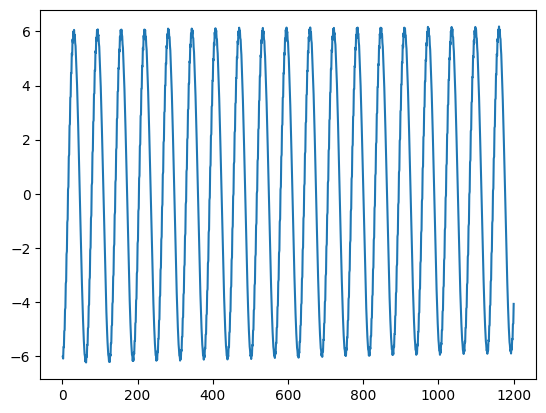

In [3]:
import numpy as np

##############################################################################
# 1. Define discrete sets based on the new specifications:
#    - Outer mass: [10, 20]
#    - Period ratio: 300 points evenly spaced between 1.4 and 2.1
#    - Fixed parameters: both ecc = 0, inc = 90, omega = 0,
#      inner mass = 5, inner period = 10
##############################################################################
outer_mass_set  = [10, 20]
period_ratios   = np.linspace(1.4, 2.1, 300)  # 300 evenly spaced points

# Fixed outer parameters
outer_ecc = 0
outer_incl = 90
outer_omega = 0

##############################################################################
# 2. Build the full list of all combinations: 
#    For each outer mass, use the same period_ratios array.
#    Total sims = 2 * 300 = 600.
##############################################################################
period_ratio_list  = []
outer_mass_list    = []
outer_ecc_list     = []
outer_incl_list    = []
outer_omega_list   = []

for m in outer_mass_set:
    period_ratio_list.extend(period_ratios)
    outer_mass_list.extend([m] * len(period_ratios))
    outer_ecc_list.extend([outer_ecc] * len(period_ratios))
    outer_incl_list.extend([outer_incl] * len(period_ratios))
    outer_omega_list.extend([outer_omega] * len(period_ratios))

all_ratios      = np.array(period_ratio_list)
all_outer_mass  = np.array(outer_mass_list)
all_outer_ecc   = np.array(outer_ecc_list)
all_outer_incl  = np.array(outer_incl_list)
all_outer_omega = np.array(outer_omega_list)

N = len(all_ratios)  # Should be 600
print("Total simulations =", N)

##############################################################################
# 3. Create arrays for the other (fixed) parameters:
#    - Inner mass = 5, inner period = 10, inner ecc = 0,
#      inner inc = 90, inner omega = 0, stellar mass = 1.
##############################################################################
inner_mass_array    = np.full(N, 5)
inner_period_array  = np.full(N, 10)
inner_ecc_array     = np.full(N, 0)
inner_incl_array    = np.full(N, 90.0)
inner_omega_array   = np.full(N, 0.0)
stellar_mass_array  = np.full(N, 1.0)

##############################################################################
# 4. Build the param_ranges dictionary
##############################################################################
param_ranges = {
    "period_ratio":       all_ratios,
    "inner_mass":         inner_mass_array,
    "inner_period":       inner_period_array,
    "outer_mass":         all_outer_mass,
    "inner_eccentricity": inner_ecc_array,
    "outer_eccentricity": all_outer_ecc,
    "inner_inclination":  inner_incl_array,
    "outer_inclination":  all_outer_incl,
    "inner_omega":        inner_omega_array,
    "outer_omega":        all_outer_omega,
    "stellar_mass":       stellar_mass_array,
    "mass_ratio":         None
}

##############################################################################
# 5. Pass param_ranges to your simulation function
##############################################################################
generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)


Total simulations = 6
Planning to run N = 6 simulations (no product).
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Finished no-product simulations.


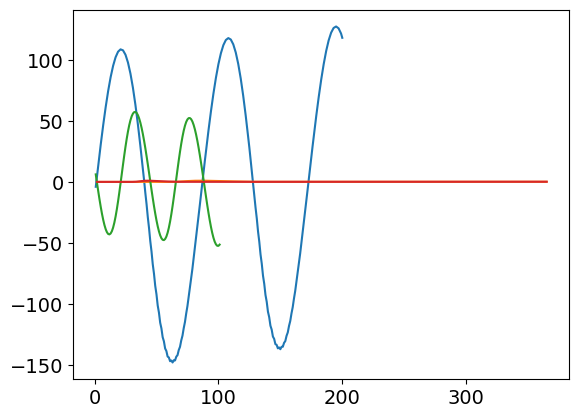

In [14]:
import numpy as np

##############################################################################
# 1. Define 6 simulation combos based on your specifications:
#
#   Combo 1: Outer Mass = 40, outer_ecc = 0, period_ratio = 1.95
#   Combo 2: Outer Mass = 20, outer_ecc = 0, period_ratio = 1.95
#   Combo 3: Outer Mass = 20, outer_ecc = 0.05, period_ratio = 1.95
#   Combo 4: Outer Mass = 20, outer_ecc = 0.1, period_ratio = 1.95
#   Combo 5: Outer Mass = 20, outer_ecc = 0, period_ratio = 1.9
#   Combo 6: Outer Mass = 20, outer_ecc = 0, period_ratio = 1.99
##############################################################################
combos = [
    {"outer_mass": 40, "outer_ecc": 0,    "period_ratio": 1.95},
    {"outer_mass": 20, "outer_ecc": 0,    "period_ratio": 1.95},
    {"outer_mass": 20, "outer_ecc": 0.05, "period_ratio": 1.95},
    {"outer_mass": 20, "outer_ecc": 0.1,  "period_ratio": 1.95},
    {"outer_mass": 20, "outer_ecc": 0,    "period_ratio": 1.9},
    {"outer_mass": 20, "outer_ecc": 0,    "period_ratio": 1.975},
]

N = len(combos)
print("Total simulations =", N)

# Build arrays for the variable parameters:
outer_mass_array   = np.array([c["outer_mass"] for c in combos])
outer_ecc_array    = np.array([c["outer_ecc"]  for c in combos])
period_ratio_array = np.array([c["period_ratio"] for c in combos])

# Fixed outer parameters:
outer_incl = 90
outer_omega = 0
outer_incl_array  = np.full(N, outer_incl)
outer_omega_array = np.full(N, outer_omega)

##############################################################################
# 2. Create arrays for the other (fixed) parameters:
#    Inner mass = 5, inner period = 10, inner eccentricity = 0,
#    inner inclination = 90, inner omega = 0, stellar mass = 1.
##############################################################################
inner_mass_array    = np.full(N, 5)
inner_period_array  = np.full(N, 10)
inner_ecc_array     = np.full(N, 0.05)
inner_incl_array    = np.full(N, 90.0)
inner_omega_array   = np.full(N, 0.0)
stellar_mass_array  = np.full(N, 1.0)

##############################################################################
# 3. Build the param_ranges dictionary:
##############################################################################
param_ranges = {
    "period_ratio":       period_ratio_array,
    "inner_mass":         inner_mass_array,
    "inner_period":       inner_period_array,
    "outer_mass":         outer_mass_array,
    "inner_eccentricity": inner_ecc_array,
    "outer_eccentricity": outer_ecc_array,
    "inner_inclination":  inner_incl_array,
    "outer_inclination":  outer_incl_array,
    "inner_omega":        inner_omega_array,
    "outer_omega":        outer_omega_array,
    "stellar_mass":       stellar_mass_array,
    "mass_ratio":         None
}

##############################################################################
# 4. Pass param_ranges to your simulation function:
##############################################################################
generate_dataset_with_multiple_params_no_product(param_ranges, epochs=200)


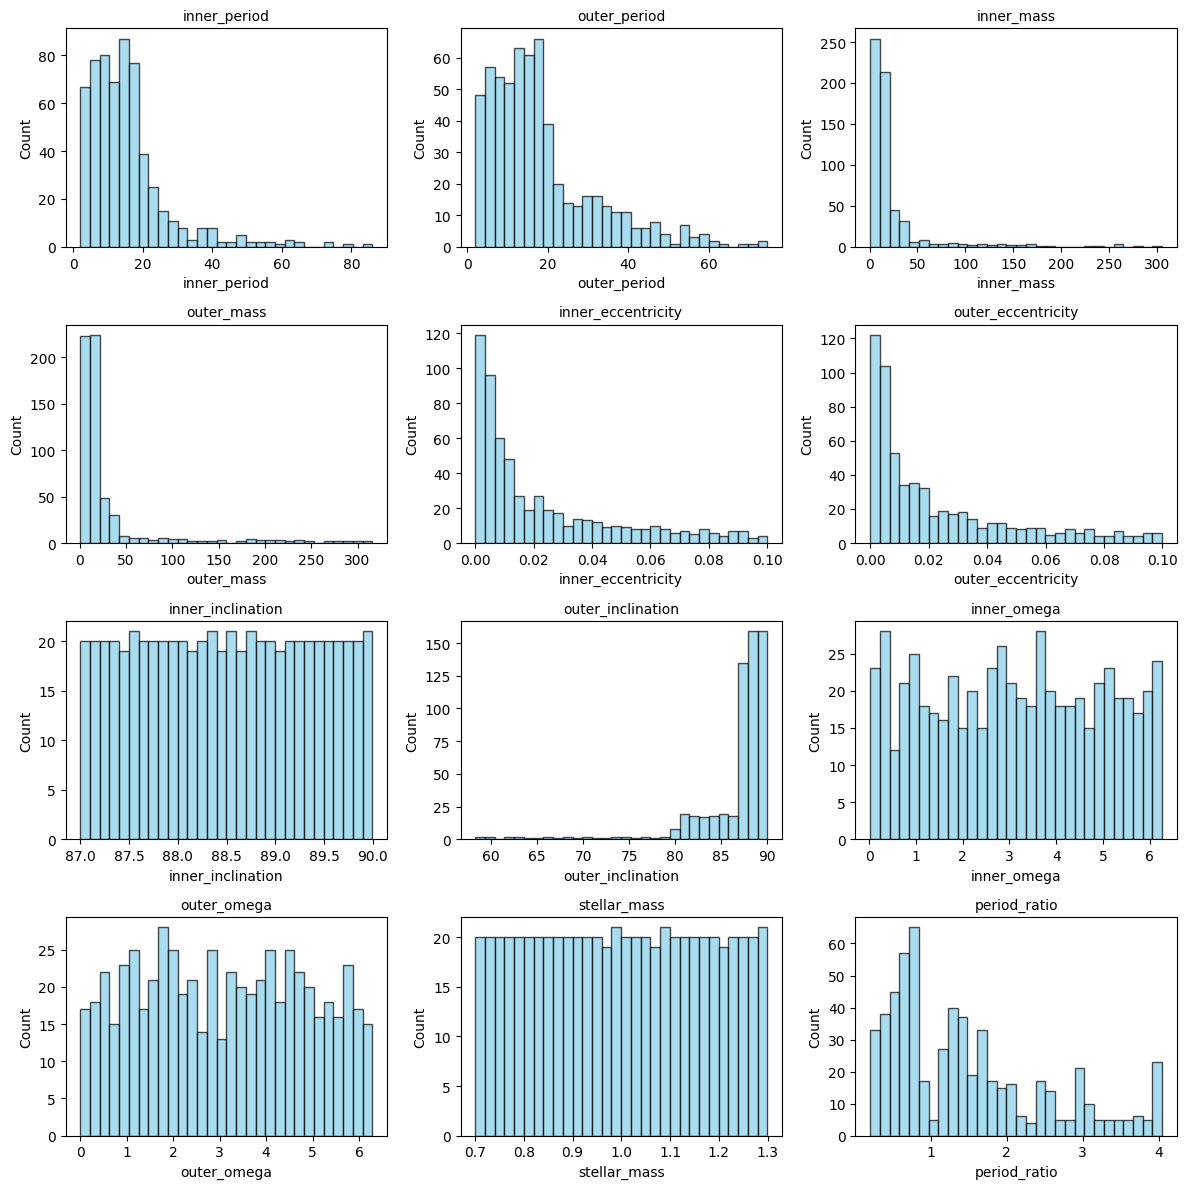

Planning to run N = 600 simulations (no product).
Sim Integrator: ias15


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


Skipping simulation 1 due to instability: Orbits unstable: effective separation 0.001433 AU is < 0.001668 AU.
Sim Integrator: ias15
Skipping simulation 3 due to instability: Orbits unstable: effective separation 0.0008352 AU is < 0.001072 AU.
Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\Temp\ipykernel_30832\2302022342.py:1686: RuntimeWarning: invalid value encountered in sqrt
  amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)


Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\anaconda3\envs\nbody\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)
C:\Users\vikas\AppData\Local\Temp\ipykernel_30832\2302022342.py:1636: RuntimeWarning: invalid value encountered in sqrt
  amplitude_mod_synodic = 2.0 * np.sqrt(refined_synodic_power * variance_y1)
C:\Users\vikas\AppData\Local\Temp\ipykernel_30832\2302022342.py:1683: RuntimeWarning: invalid value encountered in sqrt
  amplitude_synodic_1 = 2.0 * np.sqrt(power_at_synodic_1 * variance_y1)


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\anaconda3\envs\nbody\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:251: RuntimeWarning: invalid value encountered in scalar power
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Skipping simulation 32 due to instability: Orbits unstable: effective separation -0.0003208 AU is < 0.00107 AU.
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Skipping simulation 45 due to instability: Orbits unstable: effective separation -0.0008688 AU is < 0.001083 AU.
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\Temp\ipykernel_30832\2302022342.py:1638: RuntimeWarning: invalid value encountered in sqrt
  amplitude_mod_synodic = 2.0 * np.sqrt(power_synodic_before * variance_y1)


Sim Integrator: ias15


C:\Users\vikas\AppData\Local\anaconda3\envs\nbody\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:140: RuntimeWarning: invalid value encountered in scalar power
  return (1 - z) ** (0.5 * Nk)


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Skipping simulation 61 due to instability: Orbits unstable: effective separation 0.001425 AU is < 0.001474 AU.
Skipping simulation 62 due to instability: Orbits unstable: effective separation 0.0003534 AU is < 0.001335 AU.
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15



KeyboardInterrupt



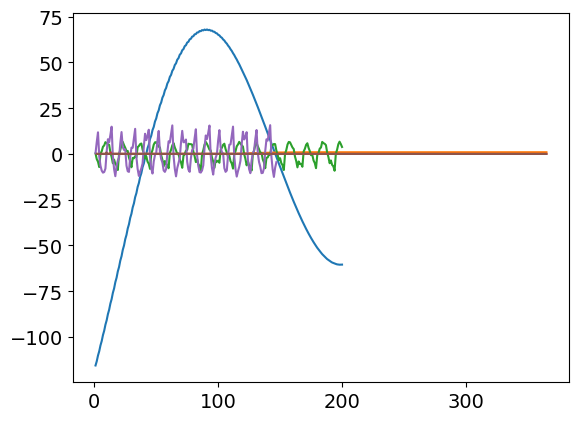

Error in callback <function flush_figures at 0x000001674AD58180> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [5]:
import numpy as np
import random
from scipy.stats import qmc
import math

###############################################################################
# 1) Configuration
###############################################################################

N = 600  # total number of samples

# Updated resonance list per your instructions:
resonances = [
    2/1, 3/2, 4/3, 5/4, 6/5,
    1/2, 2/3, 3/4, 4/5, 5/6,
    1/3, 3/5, 5/7, 3/1, 5/3,
    7/5, 4/1, 5/2, 7/4, 1/4,
    2/5, 4/7
]

###############################################################################
# 2) Single 11D LHS
#
# Columns:
#   0 -> mass_in
#   1 -> mass_out
#   2 -> ecc_in
#   3 -> ecc_out
#   4 -> angles dimension #1  (for w_in, w_out logic)
#   5 -> angles dimension #2  (for w_in, w_out logic)
#   6 -> period_in (physically inner)
#   7 -> period_ratio
#   8 -> transiting_incl
#   9 -> nontrans_incl
#  10 -> stellar_mass
###############################################################################

D = 11
sampler = qmc.LatinHypercube(d=D)
lhs_samples = sampler.random(n=N)  # shape (N, 11) in [0,1]

# Unpack columns
u_m_in        = lhs_samples[:, 0]  # physically inner mass
u_m_out       = lhs_samples[:, 1]  # physically outer mass
u_ecc_in      = lhs_samples[:, 2]  # physically inner ecc
u_ecc_out     = lhs_samples[:, 3]  # physically outer ecc
u_angle_col1  = lhs_samples[:, 4]  # for (omega_in, omega_out) scenario
u_angle_col2  = lhs_samples[:, 5]  # for (omega_in, omega_out) random offsets
u_p_in        = lhs_samples[:, 6]  # physically inner period
u_ratio       = lhs_samples[:, 7]  # period ratio
u_incl_trans  = lhs_samples[:, 8]  # transiting planet inclination
u_incl_nontr  = lhs_samples[:, 9]  # non-transiting planet inclination
u_stellar     = lhs_samples[:,10]  # stellar mass

###############################################################################
# 3) Inverse transforms (piecewise) for each dimension
###############################################################################

#--- 3.1) Mass (physically inner): 80% uniform [0.5,20], 20% log-uniform [20,40].
def invert_mass_in(u):
    """
    80% uniform in [0.5, 20],
    20% log-uniform in [20, 40].
    """
    cutoff = 0.80
    if u < cutoff:
        frac = u / cutoff
        return 0.5 + (20.0 - 0.5)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(20.0)
        log_hi = math.log10(40.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.2) Mass (physically outer): 70% uniform [0.5,20], 30% log-uniform [20,320].
def invert_mass_out(u):
    """
    70% uniform in [0.5, 20],
    30% log-uniform in [20, 320].
    """
    cutoff = 0.70
    if u < cutoff:
        frac = u / cutoff
        return 0.5 + (20.0 - 0.5)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(20.0)
        log_hi = math.log10(320.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.3) Ecc (physically inner or outer): 30% uniform [0,0.005], 70% log-uniform [0.005,0.1].
def invert_ecc(u):
    """
    30% uniform in [0, 0.005],
    70% log-uniform in [0.005, 0.1].
    """
    cutoff = 0.30
    if u < cutoff:
        frac = u / cutoff
        return 0.0 + (0.005 - 0.0)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(0.005)
        log_hi = math.log10(0.1)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.4) Period (physically inner) => uniform [2,20] (unchanged).
def invert_period_in(u):
    return 2.0 + (20.0 - 2.0)*u

#--- 3.5) Period Ratio => 25% uniform in [1/4,4], 75% near the listed resonances ±0.05,
#                        with NO clamping.
def invert_period_ratio(u):
    """
    25% uniform in [1/4, 4],
    75% distributed near the listed resonances ±0.05,
    with NO clamping.
    """
    frac_uni = 0.25
    if u < frac_uni:
        # 25% Uniform in [1/4, 4]
        frac = u / frac_uni
        return 0.25 + (4.0 - 0.25)*frac
    else:
        # 75% near resonances ±0.05
        cluster_u = (u - frac_uni) / (1.0 - frac_uni)
        
        n_res = len(resonances)
        block_size = 1.0 / n_res
        idx = int(cluster_u // block_size)
        if idx >= n_res:
            idx = n_res - 1
        
        local_u = (cluster_u - idx*block_size) / block_size
        r = resonances[idx]
        
        tol = 0.05
        lo = r - tol
        hi = r + tol
        width = hi - lo
        
        # Fallback if zero width (unlikely)
        if width <= 0:
            return 0.25 + (4.0 - 0.25)*local_u
        else:
            return lo + width*local_u

#--- 3.6) Stellar Mass => uniform [0.7,1.3].
def invert_stellar_mass(u):
    """
    Uniform in [0.7, 1.3].
    """
    return 0.7 + (1.3 - 0.7)*u

#--- 3.7) Transiting Incl => uniform [87,90].
def invert_incl_trans(u):
    """
    Uniform in [87, 90].
    """
    return 87.0 + (90.0 - 87.0)*u

#--- 3.8) Nontransiting Incl => 75% in [87,90], 20% in [80,87], 5% in [58,80].
def invert_incl_nontrans(u):
    """
    Piecewise distribution:
      - 75% => uniform in [87, 90]
      - 20% => uniform in [80, 87]
      - 5%  => uniform in [58, 80]
    """
    cutoff1 = 0.75  # First 75%
    cutoff2 = 0.95  # Next 20% (from 0.75 to 0.95)

    if u < cutoff1:
        # 75% in [87, 90]
        frac = u / cutoff1
        return 87.0 + (90.0 - 87.0)*frac
    elif u < cutoff2:
        # 20% in [80, 87]
        frac = (u - cutoff1) / (cutoff2 - cutoff1)
        return 80.0 + (87.0 - 80.0)*frac
    else:
        # 5% in [58, 80]
        frac = (u - cutoff2) / (1.0 - cutoff2)
        return 58.0 + (80.0 - 58.0)*frac

#--- 3.9) Angles (omega_in, omega_out) => 70% random scenario, 30% difference scenario.
def invert_omegas(u1, u2):
    """
    70% => random scenario: both angles uniform(0, 2π).
    30% => difference scenario: pick difference from {0, π/2, π, 3π/2} ±5°,
           then define w_out = w_in + difference (mod 2π).
    """
    diff_targets = [0.0, math.pi/2, math.pi, 3*math.pi/2]
    diff_pad = math.radians(5.0)  # ~0.087 rad

    cutoff = 0.70  # 70% random

    if u1 < cutoff:
        # 70% random scenario
        w_in  = 2.0*math.pi * u2
        w_out = 2.0*math.pi * random.random()
        return (w_in, w_out)
    else:
        # 30% difference scenario
        cluster_u = (u1 - cutoff) / (1.0 - cutoff)  # map [0.70,1] to [0,1]
        
        n_diff = len(diff_targets)  # =4
        block_size = 1.0 / n_diff
        idx = int(cluster_u // block_size)
        if idx >= n_diff:
            idx = n_diff - 1
        
        local_u = (cluster_u - idx*block_size) / block_size
        base_diff = diff_targets[idx]
        
        # offset in [-diff_pad, +diff_pad]
        offset = (2.0*local_u - 1.0)*diff_pad
        actual_diff = (base_diff + offset) % (2.0*math.pi)
        
        # w_in from [0,2π] using u2
        w_in = 2.0*math.pi * u2
        w_out = (w_in + actual_diff) % (2.0*math.pi)
        return (w_in, w_out)

###############################################################################
# 4) Generate final arrays by piecewise inverts
###############################################################################

m_in_array    = np.array([invert_mass_in(u)     for u in u_m_in])
m_out_array   = np.array([invert_mass_out(u)    for u in u_m_out])
ecc_in_array  = np.array([invert_ecc(u)         for u in u_ecc_in])
ecc_out_array = np.array([invert_ecc(u)         for u in u_ecc_out])

# For angles, handle in a loop because each pair depends on 2 LHS columns:
omega_in_array  = np.zeros(N)
omega_out_array = np.zeros(N)
for i in range(N):
    w_in, w_out = invert_omegas(u_angle_col1[i], u_angle_col2[i])
    omega_in_array[i]  = w_in
    omega_out_array[i] = w_out

p_in_array      = np.array([invert_period_in(u) for u in u_p_in])
ratio_array     = np.array([invert_period_ratio(u) for u in u_ratio])
stellar_mass_arr= np.array([invert_stellar_mass(u) for u in u_stellar])

incl_trans_array   = np.array([invert_incl_trans(u)   for u in u_incl_trans])
incl_nontrans_array= np.array([invert_incl_nontrans(u) for u in u_incl_nontr])

###############################################################################
# 5) Build the final physically "inner" vs "outer" arrays 
#    and also apply transiting vs. nontransiting incl logic
###############################################################################

inner_period    = np.zeros(N)
outer_period    = np.zeros(N)
inner_mass      = np.zeros(N)
outer_mass      = np.zeros(N)
inner_ecc       = np.zeros(N)
outer_ecc       = np.zeros(N)
inner_omega     = np.zeros(N)
outer_omega     = np.zeros(N)
inner_incl      = np.zeros(N)
outer_incl      = np.zeros(N)

for i in range(N):
    r = ratio_array[i]
    p_in_phys = p_in_array[i]
    
    # If ratio > 1, we keep p_in as physically inside; else swap
    if r > 1:
        # physically inside => keep arrays "as is"
        inner_period[i] = p_in_phys
        outer_period[i] = p_in_phys * r
        
        inner_mass[i]   = m_in_array[i]
        outer_mass[i]   = m_out_array[i]
        inner_ecc[i]    = ecc_in_array[i]
        outer_ecc[i]    = ecc_out_array[i]
        inner_omega[i]  = omega_in_array[i]
        outer_omega[i]  = omega_out_array[i]
        
        # Suppose physically inside => transiting, physically outside => non-trans
        inner_incl[i] = incl_trans_array[i]
        outer_incl[i] = incl_nontrans_array[i]
        
    else:
        # ratio < 1 => physically inside is "outer" in code => swap
        inner_period[i] = p_in_phys / r
        outer_period[i] = p_in_phys
        
        inner_mass[i]   = m_out_array[i]
        outer_mass[i]   = m_in_array[i]
        inner_ecc[i]    = ecc_out_array[i]
        outer_ecc[i]    = ecc_in_array[i]
        inner_omega[i]  = omega_out_array[i]
        outer_omega[i]  = omega_in_array[i]
        
        # Suppose physically inside => transiting, physically outside => non-trans
        inner_incl[i] = incl_trans_array[i]
        outer_incl[i] = incl_nontrans_array[i]

###############################################################################
# 6) param_ranges dictionary
###############################################################################

param_ranges = {
    "inner_period":       inner_period,         
    "outer_period":       outer_period,         
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_inclination":  inner_incl,           
    "outer_inclination":  outer_incl,           
    "inner_omega":        inner_omega,          
    "outer_omega":        outer_omega,          
    "stellar_mass":       stellar_mass_arr,
    "period_ratio":       ratio_array,
    "mass_ratio":         None
}

params_to_plot = {
    "inner_period":        inner_period,
    "outer_period":        outer_period,
    "inner_mass":          inner_mass,
    "outer_mass":          outer_mass,
    "inner_eccentricity":  inner_ecc,
    "outer_eccentricity":  outer_ecc,
    "inner_inclination":   inner_incl,
    "outer_inclination":   outer_incl,
    "inner_omega":         inner_omega,
    "outer_omega":         outer_omega,
    "stellar_mass":        stellar_mass_arr,
    "period_ratio":        ratio_array
}

# Create subplots. Here we make a 4x3 grid to hold 12 histograms.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array to iterate easily
axes = axes.flatten()

# Plot each parameter in a separate subplot
for i, (param_name, param_values) in enumerate(params_to_plot.items()):
    ax = axes[i]
    ax.hist(param_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(param_name, fontsize=10)
    
    # If you want to label axes, e.g. x-label / y-label:
    ax.set_xlabel(param_name)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

###############################################################################
# 7) Pass to your generator
###############################################################################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=200)


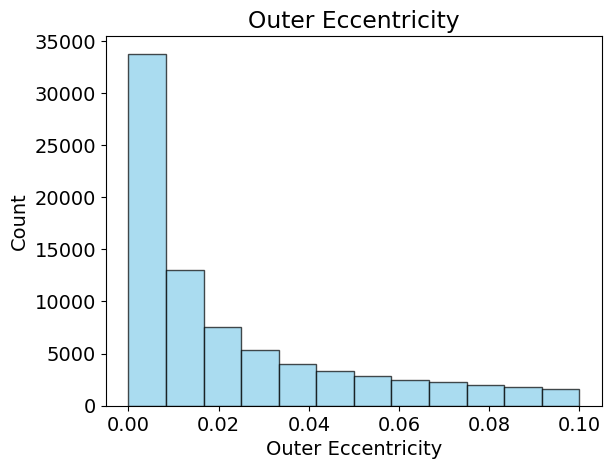

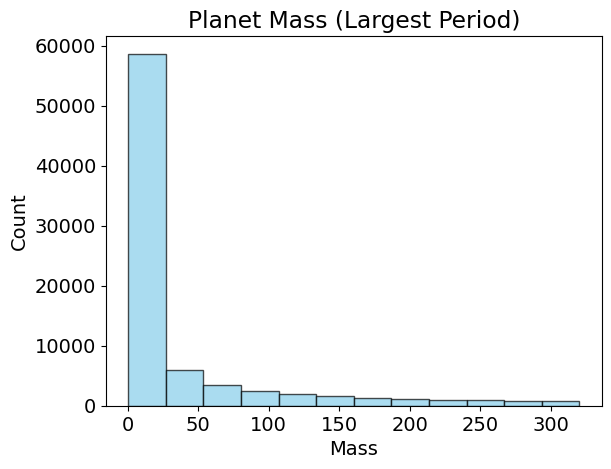

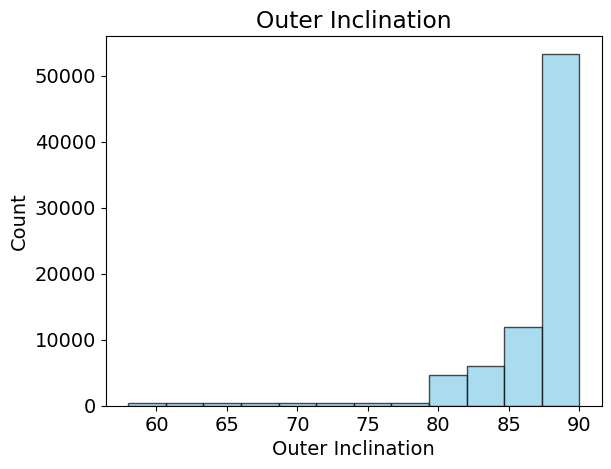

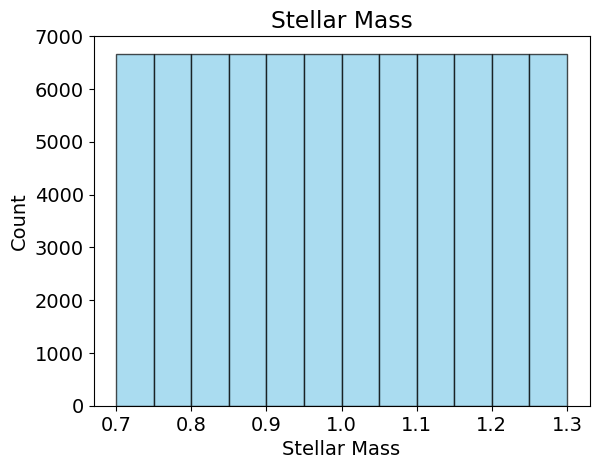

Planning to run N = 80000 simulations (no product).
Sim Integrator: ias15
Skipping simulation 1 due to instability: Orbits unstable: effective separation 0.0004359 AU is < 0.001482 AU.
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\Temp\ipykernel_18224\1029335791.py:1677: RuntimeWarning: invalid value encountered in sqrt
  amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Skipping simulation 9 due to instability: Orbits unstable: effective separation 0.0003616 AU is < 0.0009401 AU.
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\Temp\ipykernel_18224\1029335791.py:1629: RuntimeWarning: invalid value encountered in sqrt
  amplitude_mod_synodic = 2.0 * np.sqrt(power_synodic_before * variance_y1)
C:\Users\vikas\AppData\Local\Temp\ipykernel_18224\1029335791.py:1674: RuntimeWarning: invalid value encountered in sqrt
  amplitude_synodic_1 = 2.0 * np.sqrt(power_at_synodic_1 * variance_y1)


Sim Integrator: ias15
Sim Integrator: ias15
Skipping simulation 19 due to instability: Orbits unstable: effective separation 0.001737 AU is < 0.002193 AU.
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15



KeyboardInterrupt



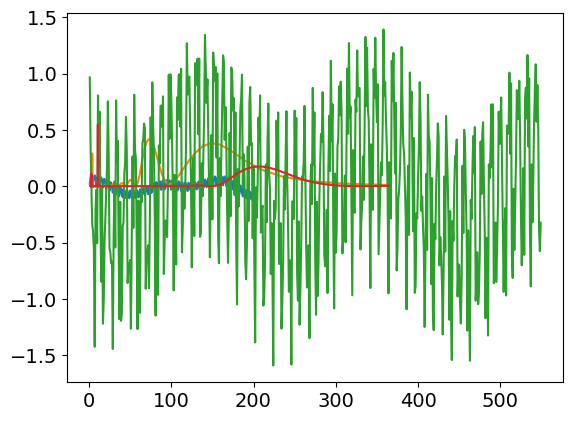

In [8]:
import numpy as np
import random
from scipy.stats import qmc
import math
import matplotlib.pyplot as plt

###############################################################################
# 1) Configuration
###############################################################################

N = 80000  # total number of samples

# Updated resonance list per your instructions:
resonances = [
    2/1, 3/2, 4/3, 5/4, 6/5,
    1/2, 2/3, 3/4, 4/5, 5/6,
    1/3, 3/5, 5/7, 3/1, 5/3,
    7/5, 4/1, 5/2, 7/4, 1/4,
    2/5, 4/7
]

###############################################################################
# 2) Single 11D LHS
###############################################################################

D = 11
sampler = qmc.LatinHypercube(d=D)
lhs_samples = sampler.random(n=N)  # shape (N, 11) in [0,1]

# Unpack columns
u_m_in        = lhs_samples[:, 0]  # physically inner mass
u_m_out       = lhs_samples[:, 1]  # physically outer mass
u_ecc_in      = lhs_samples[:, 2]  # physically inner ecc
u_ecc_out     = lhs_samples[:, 3]  # physically outer ecc
u_angle_col1  = lhs_samples[:, 4]  # for (omega_in, omega_out) scenario
u_angle_col2  = lhs_samples[:, 5]  # for (omega_in, omega_out) random offsets
u_p_in        = lhs_samples[:, 6]  # physically inner period
u_ratio       = lhs_samples[:, 7]  # period ratio
u_incl_trans  = lhs_samples[:, 8]  # transiting planet inclination
u_incl_nontr  = lhs_samples[:, 9]  # non-transiting planet inclination
u_stellar     = lhs_samples[:,10]  # stellar mass

###############################################################################
# 3) Inverse transforms (piecewise) for each dimension
###############################################################################

def invert_mass_in(u):
    cutoff = 0.80
    if u < cutoff:
        frac = u / cutoff
        return 0.5 + (20.0 - 0.5)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(20.0)
        log_hi = math.log10(40.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

def invert_mass_out(u):
    cutoff = 0.70
    if u < cutoff:
        frac = u / cutoff
        return 0.5 + (20.0 - 0.5)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(20.0)
        log_hi = math.log10(320.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

def invert_ecc(u):
    cutoff = 0.30
    if u < cutoff:
        frac = u / cutoff
        return 0.0 + (0.005 - 0.0)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(0.005)
        log_hi = math.log10(0.1)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

def invert_period_in(u):
    return 2.0 + (20.0 - 2.0)*u

def invert_period_ratio(u):
    frac_uni = 0.25
    if u < frac_uni:
        frac = u / frac_uni
        return 0.25 + (4.0 - 0.25)*frac
    else:
        cluster_u = (u - frac_uni) / (1.0 - frac_uni)
        n_res = len(resonances)
        block_size = 1.0 / n_res
        idx = int(cluster_u // block_size)
        if idx >= n_res:
            idx = n_res - 1
        local_u = (cluster_u - idx*block_size) / block_size
        r = resonances[idx]
        tol = 0.05
        lo = r - tol
        hi = r + tol
        width = hi - lo
        if width <= 0:
            return 0.25 + (4.0 - 0.25)*local_u
        else:
            return lo + width*local_u

def invert_stellar_mass(u):
    return 0.7 + (1.3 - 0.7)*u

def invert_incl_trans(u):
    return 87.0 + (90.0 - 87.0)*u

def invert_incl_nontrans(u):
    cutoff1 = 0.75  
    cutoff2 = 0.95  
    if u < cutoff1:
        frac = u / cutoff1
        return 87.0 + (90.0 - 87.0)*frac
    elif u < cutoff2:
        frac = (u - cutoff1) / (cutoff2 - cutoff1)
        return 80.0 + (87.0 - 80.0)*frac
    else:
        frac = (u - cutoff2) / (1.0 - cutoff2)
        return 58.0 + (80.0 - 58.0)*frac

def invert_omegas(u1, u2):
    diff_targets = [0.0, math.pi/2, math.pi, 3*math.pi/2]
    diff_pad = math.radians(5.0)
    cutoff = 0.70  
    if u1 < cutoff:
        w_in  = 2.0*math.pi * u2
        w_out = 2.0*math.pi * random.random()
        return (w_in, w_out)
    else:
        cluster_u = (u1 - cutoff) / (1.0 - cutoff)
        n_diff = len(diff_targets)
        block_size = 1.0 / n_diff
        idx = int(cluster_u // block_size)
        if idx >= n_diff:
            idx = n_diff - 1
        local_u = (cluster_u - idx*block_size) / block_size
        base_diff = diff_targets[idx]
        offset = (2.0*local_u - 1.0)*diff_pad
        actual_diff = (base_diff + offset) % (2.0*math.pi)
        w_in = 2.0*math.pi * u2
        w_out = (w_in + actual_diff) % (2.0*math.pi)
        return (w_in, w_out)

###############################################################################
# 4) Generate final arrays by piecewise inverts
###############################################################################

m_in_array    = np.array([invert_mass_in(u)     for u in u_m_in])
m_out_array   = np.array([invert_mass_out(u)    for u in u_m_out])
ecc_in_array  = np.array([invert_ecc(u)         for u in u_ecc_in])
ecc_out_array = np.array([invert_ecc(u)         for u in u_ecc_out])

omega_in_array  = np.zeros(N)
omega_out_array = np.zeros(N)
for i in range(N):
    w_in, w_out = invert_omegas(u_angle_col1[i], u_angle_col2[i])
    omega_in_array[i]  = w_in
    omega_out_array[i] = w_out

p_in_array      = np.array([invert_period_in(u) for u in u_p_in])
ratio_array     = np.array([invert_period_ratio(u) for u in u_ratio])
stellar_mass_arr= np.array([invert_stellar_mass(u) for u in u_stellar])
incl_trans_array   = np.array([invert_incl_trans(u)   for u in u_incl_trans])
incl_nontrans_array= np.array([invert_incl_nontrans(u) for u in u_incl_nontr])

###############################################################################
# 5) Build the final physically "inner" vs "outer" arrays 
###############################################################################

inner_period    = np.zeros(N)
outer_period    = np.zeros(N)
inner_mass      = np.zeros(N)
outer_mass      = np.zeros(N)
inner_ecc       = np.zeros(N)
outer_ecc       = np.zeros(N)
inner_omega     = np.zeros(N)
outer_omega     = np.zeros(N)
inner_incl      = np.zeros(N)
outer_incl      = np.zeros(N)

for i in range(N):
    r = ratio_array[i]
    p_in_phys = p_in_array[i]
    if r > 1:
        inner_period[i] = p_in_phys
        outer_period[i] = p_in_phys * r
        inner_mass[i]   = m_in_array[i]
        outer_mass[i]   = m_out_array[i]
        inner_ecc[i]    = ecc_in_array[i]
        outer_ecc[i]    = ecc_out_array[i]
        inner_omega[i]  = omega_in_array[i]
        outer_omega[i]  = omega_out_array[i]
        inner_incl[i] = incl_trans_array[i]
        outer_incl[i] = incl_nontrans_array[i]
    else:
        inner_period[i] = p_in_phys / r
        outer_period[i] = p_in_phys
        inner_mass[i]   = m_out_array[i]
        outer_mass[i]   = m_in_array[i]
        inner_ecc[i]    = ecc_out_array[i]
        outer_ecc[i]    = ecc_in_array[i]
        inner_omega[i]  = omega_out_array[i]
        outer_omega[i]  = omega_in_array[i]
        inner_incl[i] = incl_trans_array[i]
        outer_incl[i] = incl_nontrans_array[i]

###############################################################################
# 6) param_ranges dictionary
###############################################################################

param_ranges = {
    "inner_period":       inner_period,         
    "outer_period":       outer_period,         
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_inclination":  inner_incl,           
    "outer_inclination":  outer_incl,           
    "inner_omega":        inner_omega,          
    "outer_omega":        outer_omega,          
    "stellar_mass":       stellar_mass_arr,
    "period_ratio":       ratio_array,
    "mass_ratio":         None
}

###############################################################################
# 7) New plotting code per your requirements:
#    - Increase font sizes
#    - Each histogram has 8 bins
#    - Each plot is produced separately
#    - Plot order:
#         1. Outer eccentricity
#         2. Planet mass (for the planet with the largest period)
#         3. Outer inclination
#         4. Stellar mass
###############################################################################

# Increase default font sizes globally.
plt.rcParams.update({'font.size': 14})

# 1. Outer Eccentricity Plot
plt.figure()
plt.hist(outer_ecc, bins=12, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Outer Eccentricity")
plt.xlabel("Outer Eccentricity")
plt.ylabel("Count")
plt.show()

# 2. Mass Plot:
#    For each system, choose the mass corresponding to the planet with the larger period.
#    (If period_ratio > 1, the outer planet has the larger period; otherwise, the inner does.)
mass_big = np.where(ratio_array > 1, outer_mass, inner_mass)
plt.figure()
plt.hist(mass_big, bins=12, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Planet Mass (Largest Period)")
plt.xlabel("Mass")
plt.ylabel("Count")
plt.show()

# 3. Outer Inclination Plot
plt.figure()
plt.hist(outer_incl, bins=12, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Outer Inclination")
plt.xlabel("Outer Inclination")
plt.ylabel("Count")
plt.show()

# 4. Stellar Mass Plot
plt.figure()
plt.hist(stellar_mass_arr, bins=12, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Stellar Mass")
plt.xlabel("Stellar Mass")
plt.ylabel("Count")
plt.show()

###############################################################################
# 8) Pass to your generator
###############################################################################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=200)


In [ ]:
import numpy as np

##############################################################################
# 1. Helper function (same as CODE 1) to build the period_ratio block
##############################################################################
def build_resonance_block_with_gap(center, gap=0.005, halfwidth=0.05, npoints=50):
    return np.linspace(center - halfwidth, center - gap, npoints)

##############################################################################
# 2. Define all discrete sets (identical to CODE 1)
##############################################################################
centers         = [2.0, 1.5]
outer_mass_set  = [5, 10]
outer_ecc_set   = [0, 0.02]
outer_incl_set  = [90, 87]
outer_omega_set = [0, 90]

##############################################################################
# 3. Build the full list of all combinations
##############################################################################
all_combos = []
for center in centers:
    ratio_block = build_resonance_block_with_gap(center, gap=0.005, halfwidth=0.05, npoints=50)
    for m in outer_mass_set:
        for e in outer_ecc_set:
            for inc in outer_incl_set:
                for omg in outer_omega_set:
                    all_combos.append((center, ratio_block, m, e, inc, omg))

assert len(all_combos) == 32

##############################################################################
# 4. Take the LAST 12 combinations → 600 simulations
##############################################################################
combos_2 = all_combos[20:]  # 12 combos × 50 = 600

##############################################################################
# 5. Build arrays for these 600 simulations
##############################################################################
period_ratio_list  = []
outer_mass_list    = []
outer_ecc_list     = []
outer_incl_list    = []
outer_omega_list   = []

for (center, ratio_block, m, e, inc, omg) in combos_2:
    period_ratio_list.extend(ratio_block)
    outer_mass_list.extend([m]*len(ratio_block))
    outer_ecc_list.extend([e]*len(ratio_block))
    outer_incl_list.extend([inc]*len(ratio_block))
    outer_omega_list.extend([omg]*len(ratio_block))

all_ratios       = np.array(period_ratio_list)
all_outer_mass   = np.array(outer_mass_list)
all_outer_ecc    = np.array(outer_ecc_list)
all_outer_incl   = np.array(outer_incl_list)
all_outer_omega  = np.array(outer_omega_list)

N = len(all_ratios)  # Should be 600
print("CODE 2: Total simulations =", N)

##############################################################################
# 6. Create arrays for the other (fixed) parameters
##############################################################################
inner_mass_array    = np.full(N, 5)
inner_period_array  = np.full(N, 10)
inner_ecc_array     = np.full(N, 0)
inner_incl_array    = np.full(N, 90.0)
inner_omega_array   = np.full(N, 0.0)
stellar_mass_array  = np.full(N, 1.0)

##############################################################################
# 7. Build param_ranges dictionary
##############################################################################
param_ranges_2 = {
    "period_ratio":       all_ratios,
    "inner_mass":         inner_mass_array,
    "inner_period":       inner_period_array,
    "outer_mass":         all_outer_mass,
    "inner_eccentricity": inner_ecc_array,
    "outer_eccentricity": all_outer_ecc,
    "inner_inclination":  inner_incl_array,
    "outer_inclination":  all_outer_incl,
    "inner_omega":        inner_omega_array,
    "outer_omega":        all_outer_omega,
    "stellar_mass":       stellar_mass_array,
    "mass_ratio":         None
}

##############################################################################
# 8. Pass param_ranges_2 to your simulation function
##############################################################################
# e.g.
generate_dataset_with_multiple_params_no_product(param_ranges_2, epochs=1200)


In [ ]:
import numpy as np

##############################################################################
# 1. Build the period_ratio array of length = 1000
##############################################################################

def build_resonance_block_with_gap(center, gap=0.005, halfwidth=0.1, npoints=200):
    """
    Build 'npoints' around 'center' in [center - halfwidth, center + halfwidth],
    excluding (center - gap, center + gap). We split 'npoints' across
    the lower and upper sub-ranges.
    """
    # We'll place half of them in the lower side, half in the upper side.
    half_n = npoints // 2
    lower_side = np.linspace(center - halfwidth, center - gap, half_n)
    upper_side = np.linspace(center + gap,       center + halfwidth, half_n)
    return np.concatenate([lower_side, upper_side])

# Build the four resonance blocks (each 200 points)
resonant_centers = [2.0, 1.5]
blocks = []
for rc in resonant_centers:
    blocks.append(build_resonance_block_with_gap(rc, gap=0.005, halfwidth=0.1, npoints=200))

# Block 5: uniform in [2.2, 2.8] with 200 points
blocks.append(np.linspace(1.6, 1.9, 100))
#blocks.append(np.linspace(2.1, 2.3, 80))



# Concatenate into one array of length = 1000
all_ratios = np.concatenate(blocks)
assert len(all_ratios) == 500

outer_mass_set = [5,10]

all_ratios_list     = []
all_outer_mass_list = []

for im in outer_mass_set:
    for r in all_ratios:
        all_ratios_list.append(r)
        all_outer_mass_list.append(im)

# Convert to NumPy arrays
all_ratios     = np.array(all_ratios_list)     # length = 800
all_outer_mass = np.array(all_outer_mass_list) # length = 800

##############################################################################
# 2. Create arrays for all other parameters (also length = 1000)
##############################################################################
# Fixed values, repeated
inner_mass_array    = np.full(1000, 5)
inner_period_array  = np.full(1000, 10)
#outer_mass_array    = np.full(1000, 10)
inner_ecc_array     = np.full(1000, 0)
outer_ecc_array     = np.full(1000, 0.04)
inner_incl_array    = np.full(1000, 90.0)
outer_incl_array    = np.full(1000, 90.0)
inner_omega_array   = np.full(1000, 0.0)
outer_omega_array   = np.full(1000, 0.0)
stellar_mass_array  = np.full(1000, 1.0)

##############################################################################
# 3. Build dictionary with each param array
##############################################################################
param_ranges = {
    "period_ratio":       all_ratios,
    "inner_mass":         inner_mass_array,
    "inner_period":       inner_period_array,
    "outer_mass":         all_outer_mass,
    "inner_eccentricity": inner_ecc_array,
    "outer_eccentricity": outer_ecc_array,
    "inner_inclination":  inner_incl_array,
    "outer_inclination":  outer_incl_array,
    "inner_omega":        inner_omega_array,
    "outer_omega":        outer_omega_array,
    "stellar_mass":       stellar_mass_array,
    "mass_ratio":         None
}

print(f"Total simulations = {len(all_ratios)}")
#plot_param_distributions(param_ranges)


##############################################################################
# 4. Pass to your simulation function (as needed)
##############################################################################
generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

###############################################################################
# 1) Load CSV and prepare
###############################################################################
df = pd.read_csv("F:/exoplanet_systems_keystone_plus_2_transiting.csv")

# The CSV has columns of interest:
#   Planet Name
#   Star Mass
#   Planet Orbital Period
#   Planet Eccentricity
#   Planet Mass
#   Planet Orbital Inclination
#   Planet Argument of Periastron (pl_orblper)
#
# We'll define a "SystemName" by stripping off the trailing planet letter.
# E.g. "Kepler-18 c" => "Kepler-18", "Kepler-18 d" => "Kepler-18"
# Then we can group by "SystemName", assuming each group has exactly 2 planets.
def extract_system_name(name):
    # This splits off the last space+letter(s), e.g. "Kepler-18 c" => "Kepler-18"
    return name.rsplit(' ', 1)[0]

df['SystemName'] = df['Planet Name'].apply(extract_system_name)

# Group by system; each group is 2 rows (2 planets).
groups = df.groupby('SystemName')

# We will store combined arrays for all pairs (each system) and each arrangement.
all_inner_period    = []
all_outer_period    = []
all_inner_mass      = []
all_outer_mass      = []
all_inner_ecc       = []
all_outer_ecc       = []
all_inner_omega     = []
all_outer_omega     = []
all_inner_incl      = []
all_outer_incl      = []
all_stellar_mass    = []
all_period_ratio    = []

###############################################################################
# 2) Build "inner" vs "outer" arrays for each 2-planet system
###############################################################################
#
# For each system with two planets, we will create TWO sets of params:
#   1) planet1 => inner, planet2 => outer
#   2) planet2 => inner, planet1 => outer
#
# 'Inner' vs 'Outer' is just a label for your function, so we do not assume
# actual physical ordering. We simply create both permutations.
#

for system_name, group in groups:
    # Expecting exactly 2 rows. If there's more, you'd adapt or skip.
    if len(group) != 2:
        continue

    rows = list(group.to_dict('records'))
    p1 = rows[0]
    p2 = rows[1]
    
    # Extract the star mass (should be same for both if it's indeed the same system).
    # But we'll just take from p1 for consistency:
    star_mass = p1['Star Mass']
    
    # We'll define a small helper to convert argument of periastron to radians
    # if your CSV is in degrees. If already in radians, omit the conversion.
    def to_radians(deg):
        return math.radians(deg)
    
    # For convenience:
    # Planet1
    p1_period = p1['Planet Orbital Period']
    p1_mass   = p1['Planet Mass']
    p1_ecc    = p1['Planet Eccentricity']
    p1_incl   = p1['Planet Orbital Inclination']
    p1_omega  = to_radians(p1['Planet Argument of Periastron (pl_orblper)'])
    
    # Planet2
    p2_period = p2['Planet Orbital Period']
    p2_mass   = p2['Planet Mass']
    p2_ecc    = p2['Planet Eccentricity']
    p2_incl   = p2['Planet Orbital Inclination']
    p2_omega  = to_radians(p2['Planet Argument of Periastron (pl_orblper)'])
    
    # -----------------------------
    # Arrangement #1: p1=inner, p2=outer
    # -----------------------------
    # Just adopt "inner" arrays from planet1, "outer" from planet2
    # Then compute ratio as outer/inner:
    all_inner_period.append(p1_period)
    all_outer_period.append(p2_period)
    
    all_inner_mass.append(p1_mass)
    all_outer_mass.append(p2_mass)
    
    all_inner_ecc.append(p1_ecc)
    all_outer_ecc.append(p2_ecc)
    
    all_inner_omega.append(p1_omega)
    all_outer_omega.append(p2_omega)
    
    # For inclination, you may decide that "inner => transiting, outer => non-trans."
    # OR simply use the planet's actual inclinations from the CSV. 
    # Shown here, we just keep the CSV values directly:
    all_inner_incl.append(p1_incl)
    all_outer_incl.append(p2_incl)
    
    all_stellar_mass.append(star_mass)
    ratio_1 = p2_period / p1_period if p1_period != 0 else np.nan
    all_period_ratio.append(ratio_1)
    
    # -----------------------------
    # Arrangement #2: p2=inner, p1=outer
    # -----------------------------
    all_inner_period.append(p2_period)
    all_outer_period.append(p1_period)
    
    all_inner_mass.append(p2_mass)
    all_outer_mass.append(p1_mass)
    
    all_inner_ecc.append(p2_ecc)
    all_outer_ecc.append(p1_ecc)
    
    all_inner_omega.append(p2_omega)
    all_outer_omega.append(p1_omega)
    
    all_inner_incl.append(p2_incl)
    all_outer_incl.append(p1_incl)
    
    all_stellar_mass.append(star_mass)
    ratio_2 = p1_period / p2_period if p2_period != 0 else np.nan
    all_period_ratio.append(ratio_2)

###############################################################################
# 3) Convert lists -> numpy arrays and build param_ranges dict
###############################################################################

inner_period    = np.array(all_inner_period)
outer_period    = np.array(all_outer_period)
inner_mass      = np.array(all_inner_mass)
outer_mass      = np.array(all_outer_mass)
inner_ecc       = np.array(all_inner_ecc)
outer_ecc       = np.array(all_outer_ecc)
inner_omega     = np.array(all_inner_omega)
outer_omega     = np.array(all_outer_omega)
inner_incl      = np.array(all_inner_incl)
outer_incl      = np.array(all_outer_incl)
stellar_mass_arr= np.array(all_stellar_mass)
ratio_array     = np.array(all_period_ratio)

# You can define mass_ratio if you like, or keep it as None as in your original code.
# For example:
mass_ratio = None
# Or if you prefer outer_mass/inner_mass:
# mass_ratio = outer_mass / inner_mass

param_ranges = {
    "inner_period":       inner_period,
    "outer_period":       outer_period,
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_inclination":  inner_incl,
    "outer_inclination":  outer_incl,
    "inner_omega":        inner_omega,
    "outer_omega":        outer_omega,
    "stellar_mass":       stellar_mass_arr,
    "period_ratio":       ratio_array,
    "mass_ratio":         mass_ratio
}

###############################################################################
# 4) (Optional) Plot histograms of these parameters (similar to original code)
###############################################################################

params_to_plot = {
    "inner_period":        inner_period,
    "outer_period":        outer_period,
    "inner_mass":          inner_mass,
    "outer_mass":          outer_mass,
    "inner_eccentricity":  inner_ecc,
    "outer_eccentricity":  outer_ecc,
    "inner_inclination":   inner_incl,
    "outer_inclination":   outer_incl,
    "inner_omega":         inner_omega,
    "outer_omega":         outer_omega,
    "stellar_mass":        stellar_mass_arr,
    "period_ratio":        ratio_array
}

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
axes = axes.flatten()

for i, (param_name, param_values) in enumerate(params_to_plot.items()):
    ax = axes[i]
    ax.hist(param_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(param_name, fontsize=10)
    ax.set_xlabel(param_name)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

###############################################################################
# 5) Pass to your generator
###############################################################################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)


In [ ]:
import numpy as np

##############################################################################
# 1. Build the base ratio array of length = 200
##############################################################################
def build_resonance_block_with_gap(center, gap=0.005, halfwidth=0.1, npoints=200):
    """
    Build 'npoints' around 'center' in [center - halfwidth, center + halfwidth],
    excluding (center - gap, center + gap).
    """
    half_n = npoints // 2
    lower_side = np.linspace(center - halfwidth, center - gap, half_n)
    upper_side = np.linspace(center + gap,       center + halfwidth, half_n)
    return np.concatenate([lower_side, upper_side])

ratio_values = build_resonance_block_with_gap(
    center=2.0, 
    gap=0.005, 
    halfwidth=0.1, 
    npoints=200
)
assert len(ratio_values) == 200

##############################################################################
# 2. Outer mass set and forming the product
##############################################################################
inner_eccentricity_set = [0, 0.01, 0.02]
outer_eccentricity_set = [0, 0.02, 0.04]

# We'll build arrays of length 800. We'll do it by enumerating every combination.
all_ratios_list      = []
all_inner_eccentricity_list  = []
all_outer_eccentricity_list  = []

for om in inner_eccentricity_set:
    for r in ratio_values:
        all_ratios_list.append(r)
        all_inner_eccentricity_list.append(om)

for om in outer_eccentricity_set:
    for r in ratio_values:
        #all_ratios_list.append(r)
        all_outer_eccentricity_list.append(om)

# Convert to numpy arrays
all_ratios     = np.array(all_ratios_list)      # length = 800
all_inner_eccentricity = np.array(all_inner_eccentricity_list)  # length = 800
all_outer_eccentricity = np.array(all_outer_eccentricity_list)  # length = 800


##############################################################################
# 3. Create the other param arrays, each length = 800
##############################################################################
inner_mass_array   = np.full(600, 5)
outer_mass_array   = np.full(600, 17)
inner_period_array   = np.full(600, 10)
inner_ecc_array    = np.full(600, 0.0)
outer_ecc_array    = np.full(600, 0.0)
inner_incl_array   = np.full(600, 90.0)
outer_incl_array   = np.full(600, 90.0)
inner_omega_array  = np.full(600, 0.0)
outer_omega_array  = np.full(600, 0.0)
stellar_mass_array = np.full(600, 1.0)

##############################################################################
# 4. Build dictionary
##############################################################################
param_ranges = {
    "period_ratio":       all_ratios,
    "inner_mass":         inner_mass_array,
    "inner_period":       inner_period_array,
    "outer_mass":         outer_mass_array,
    "inner_eccentricity": all_inner_eccentricity,
    "outer_eccentricity": all_outer_eccentricity,
    "inner_inclination":  inner_incl_array,
    "outer_inclination":  outer_incl_array,
    "inner_omega":        inner_omega_array,
    "outer_omega":        outer_omega_array,
    "stellar_mass":       stellar_mass_array,
    "mass_ratio":         None
}

print(f"Total simulations = {len(all_ratios)}")

import numpy as np
import matplotlib.pyplot as plt


#plot_param_distributions(param_ranges)

##############################################################################
# 5. Pass to your simulation function
##############################################################################
generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)


In [ ]:
import numpy as np
import random
from scipy.stats import qmc
import math
import matplotlib.pyplot as plt

###############################################################################
# 1) Fixed inner planet parameters
###############################################################################
FIXED_INNER_PERIOD = 7.64159       # days
FIXED_INNER_MASS   = 17.3       # e.g., 1 Jupiter mass
FIXED_INNER_ECC    = 0
FIXED_INNER_INCL   = 87.68 # degrees
FIXED_INNER_OMEGA  = 0.0       # radians

###############################################################################
# 2) Configuration
###############################################################################
N = 600  # number of samples

# Original resonance list, including sub-1 resonances
resonances = [
    2/1, 3/2, 4/3, 5/4, 6/5,
    1/2, 2/3, 3/4, 4/5, 5/6,
    1/3, 3/5, 5/7, 3/1, 5/3,
    7/5, 4/1, 5/2, 7/4, 1/4,
    2/5, 4/7
]

###############################################################################
# 3) Construct LHS for outer planet + star
#
# Columns:
#   0 -> mass_out
#   1 -> ecc_out
#   2 -> angle_scenario (random vs difference)
#   3 -> angle_val      (secondary random or offset)
#   4 -> period_ratio
#   5 -> nontrans_incl (outer planet)
#   6 -> stellar_mass
###############################################################################
D = 7
sampler = qmc.LatinHypercube(d=D)
lhs_samples = sampler.random(n=N)  # shape (N,7) in [0,1]

u_m_out      = lhs_samples[:, 0]
u_ecc_out    = lhs_samples[:, 1]
u_angle_scen = lhs_samples[:, 2]
u_angle_val  = lhs_samples[:, 3]
u_ratio      = lhs_samples[:, 4]
u_incl_nontr = lhs_samples[:, 5]
u_stellar    = lhs_samples[:, 6]

###############################################################################
# 4) Piecewise Inverse Transforms
###############################################################################

#--- 4.1) Mass (outer): 70% uniform [0.5,20], 30% log-uniform [20,320].
def invert_mass_out(u):
    cutoff = 0.70
    if u < cutoff:
        frac = u / cutoff
        return 0.5 + (20.0 - 0.5)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(20.0)
        log_hi = math.log10(320.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 4.2) Ecc (outer): 30% uniform [0,0.005], 70% log-uniform [0.005,0.1].
def invert_ecc(u):
    cutoff = 0.30
    if u < cutoff:
        frac = u / cutoff
        return 0.0 + (0.005 - 0.0)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(0.005)
        log_hi = math.log10(0.1)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 4.3) Period Ratio => 25% uniform in [0.25,4], 75% near the listed resonances ±0.05.
def invert_period_ratio(u):
    """
    25% uniform in [1/4, 4],
    75% near the listed resonances ±0.05,
    with NO clamping.
    """
    frac_uni = 0.25
    if u < frac_uni:
        # 25% Uniform in [0.25, 4]
        frac = u / frac_uni
        return 0.25 + (4.0 - 0.25)*frac
    else:
        # 75% near resonances ±0.05
        cluster_u = (u - frac_uni) / (1.0 - frac_uni)
        
        n_res = len(resonances)
        block_size = 1.0 / n_res
        idx = int(cluster_u // block_size)
        if idx >= n_res:
            idx = n_res - 1
        
        local_u = (cluster_u - idx*block_size) / block_size
        r = resonances[idx]
        
        tol = 0.05
        lo = r - tol
        hi = r + tol
        width = hi - lo
        
        if width <= 0:
            # fallback if something is off
            return 0.25 + (4.0 - 0.25)*local_u
        else:
            return lo + width*local_u

#--- 4.4) Stellar Mass => uniform [0.7,1.3].
def invert_stellar_mass(u):
    return 0.7 + (1.3 - 0.7)*u

#--- 4.5) Nontransiting Incl => 75% in [87,90], 20% in [80,87], 5% in [58,80].
def invert_incl_nontrans(u):
    cutoff1 = 0.75
    cutoff2 = 0.95
    if u < cutoff1:
        # 75% in [87,90]
        frac = u / cutoff1
        return 87.0 + 3.0*frac
    elif u < cutoff2:
        # 20% in [80,87]
        frac = (u - cutoff1) / (cutoff2 - cutoff1)
        return 80.0 + 7.0*frac
    else:
        # 5% in [58,80]
        frac = (u - cutoff2) / (1.0 - cutoff2)
        return 58.0 + 22.0*frac

#--- 4.6) Angles (omega_out) => 70% random, 30% difference from {0, π/2, π, 3π/2} ±5°
#     with inner_omega fixed = 0.0
def invert_omega_out(u_scen, u_val):
    diff_targets = [0.0, math.pi/2, math.pi, 3*math.pi/2]
    diff_pad = math.radians(5.0)
    cutoff = 0.70
    
    if u_scen < cutoff:
        # 70% random scenario
        return 2.0*math.pi * u_val
    else:
        # 30% difference scenario
        cluster_u = (u_scen - cutoff) / (1.0 - cutoff)
        n_diff = len(diff_targets)
        block_size = 1.0 / n_diff
        idx = int(cluster_u // block_size)
        if idx >= n_diff:
            idx = n_diff - 1
        
        local_u = (cluster_u - idx*block_size) / block_size
        base_diff = diff_targets[idx]
        offset = (2.0*local_u - 1.0)*diff_pad
        actual_diff = (base_diff + offset) % (2.0*math.pi)
        return actual_diff

###############################################################################
# 5) Generate arrays for the "outer" planet + star
###############################################################################
m_out_array      = np.array([invert_mass_out(u)        for u in u_m_out])
ecc_out_array    = np.array([invert_ecc(u)             for u in u_ecc_out])
omega_out_array  = np.array([
    invert_omega_out(u_scen, u_val) 
    for (u_scen, u_val) in zip(u_angle_scen, u_angle_val)
])
ratio_array      = np.array([invert_period_ratio(u) for u in u_ratio])
incl_nontrans_arr= np.array([invert_incl_nontrans(u) for u in u_incl_nontr])
stellar_mass_arr = np.array([invert_stellar_mass(u)  for u in u_stellar])

###############################################################################
# 6) Build final arrays, with inner planet fixed
###############################################################################
# Inner planet = fixed
inner_period =    np.full(N, FIXED_INNER_PERIOD)
inner_mass   =    np.full(N, FIXED_INNER_MASS)
inner_ecc    =    np.full(N, FIXED_INNER_ECC)
inner_incl   =    np.full(N, FIXED_INNER_INCL)
inner_omega  =    np.full(N, FIXED_INNER_OMEGA)

# Outer planet uses the ratio and the LHS draws
outer_period =    inner_period * ratio_array
outer_mass   =    m_out_array
outer_ecc    =    ecc_out_array
outer_incl   =    incl_nontrans_arr
outer_omega  =    omega_out_array

###############################################################################
# 7) Build the dictionaries for your generator
###############################################################################
param_ranges = {
    "inner_period":       inner_period,
    "outer_period":       outer_period,
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_inclination":  inner_incl,
    "outer_inclination":  outer_incl,
    "inner_omega":        inner_omega,
    "outer_omega":        outer_omega,
    "stellar_mass":       stellar_mass_arr,
    "period_ratio":       ratio_array,
    "mass_ratio":         None
}

params_to_plot = {
    "inner_period":        inner_period,
    "outer_period":        outer_period,
    "inner_mass":          inner_mass,
    "outer_mass":          outer_mass,
    "inner_eccentricity":  inner_ecc,
    "outer_eccentricity":  outer_ecc,
    "inner_inclination":   inner_incl,
    "outer_inclination":   outer_incl,
    "inner_omega":         inner_omega,
    "outer_omega":         outer_omega,
    "stellar_mass":        stellar_mass_arr,
    "period_ratio":        ratio_array
}

###############################################################################
# 8) Quick example histograms
###############################################################################
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
axes = axes.flatten()

for i, (param_name, param_values) in enumerate(params_to_plot.items()):
    ax = axes[i]
    ax.hist(param_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(param_name, fontsize=10)
    ax.set_xlabel(param_name)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

###############################################################################
# 9) Generate the dataset with your function
###############################################################################
generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)


In [ ]:
import numpy as np

##############################################################################
# 1. Build the base ratio array of length = 150 (uniform in [2.1, 2.9])
##############################################################################
ratio_values = np.linspace(2.1, 2.9, 150)
assert len(ratio_values) == 150

##############################################################################
# 2. Outer mass set and forming the product (4 × 150 = 600)
##############################################################################
outer_mass_set = [10]

all_ratios_list      = []
all_outer_mass_list  = []

for om in outer_mass_set:
    for r in ratio_values:
        all_ratios_list.append(r)
        all_outer_mass_list.append(om)

# Convert to numpy arrays
all_ratios     = np.array(all_ratios_list)      # length = 600
all_outer_mass = np.array(all_outer_mass_list)  # length = 600

##############################################################################
# 3. Create the other param arrays, each length = 600
##############################################################################
inner_mass_array   = np.full(150, 1.0)
inner_period_array = np.full(150, 5.0)
inner_ecc_array    = np.full(150, 0.0)
outer_ecc_array    = np.full(150, 0.0)
inner_incl_array   = np.full(150, 90.0)
outer_incl_array   = np.full(150, 90.0)
inner_omega_array  = np.full(150, 0.0)
outer_omega_array  = np.full(150, 0.0)
stellar_mass_array = np.full(150, 1.0)

##############################################################################
# 4. Build dictionary
##############################################################################
param_ranges = {
    "period_ratio":       all_ratios,
    "inner_mass":         inner_mass_array,
    "inner_period":       inner_period_array,
    "outer_mass":         all_outer_mass,
    "inner_eccentricity": inner_ecc_array,
    "outer_eccentricity": outer_ecc_array,
    "inner_inclination":  inner_incl_array,
    "outer_inclination":  outer_incl_array,
    "inner_omega":        inner_omega_array,
    "outer_omega":        outer_omega_array,
    "stellar_mass":       stellar_mass_array,
    "mass_ratio":         None
}

print(f"Total simulations = {len(all_ratios)}")

##############################################################################
# 5. Plot parameter distributions (optional, before running simulation)
##############################################################################
import matplotlib.pyplot as plt

def plot_param_distributions(param_dict):
    keys = sorted(param_dict.keys())
    # Remove "mass_ratio" if None, so it doesn't break the plotting
    if "mass_ratio" in keys and param_dict["mass_ratio"] is None:
        keys.remove("mass_ratio")
    
    n_params = len(keys)
    ncols = 3
    nrows = (n_params + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()
    
    for i, key in enumerate(keys):
        data = param_dict[key]
        axes[i].hist(data, bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(key)
        axes[i].set_xlabel(key)
        axes[i].set_ylabel("Count")
    
    # Hide unused subplots
    for j in range(i+1, nrows*ncols):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot the distributions (optional)
plot_param_distributions(param_ranges)

##############################################################################
# 6. Pass to your simulation function
##############################################################################
generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)


In [ ]:
def plot_param_distributions(param_ranges):
    """
    Given a dictionary param_ranges, where each key is a parameter name and each
    value is a NumPy array of length N (the number of simulations), this function
    creates a subplot of histograms for all parameters.
    """
    # Sort the keys so plots have a consistent order (optional)
    keys = sorted(param_ranges.keys())

    # Figure out a grid of subplots based on how many parameters we have
    n_params = len(keys)
    ncols = 3
    nrows = int(np.ceil(n_params / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()  # Flatten in case nrows > 1

    for i, key in enumerate(keys):
        ax = axes[i]
        data = param_ranges[key]
        ax.hist(data, bins=30, alpha=0.7, edgecolor='black')
        ax.set_title(key)
        ax.set_xlabel(key)
        ax.set_ylabel('Count')

    # Hide any unused subplots if the total isn't a perfect multiple of ncols
    for j in range(i+1, nrows*ncols):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

##############################################################################
# 1. Build the period_ratio array of length = 1000
##############################################################################

def build_resonance_block_with_gap(center, gap=0.005, halfwidth=0.1, npoints=200):
    """
    Build 'npoints' around 'center' in [center - halfwidth, center + halfwidth],
    excluding (center - gap, center + gap). We split 'npoints' across
    the lower and upper sub-ranges.
    """
    # We'll place half of them in the lower side, half in the upper side.
    half_n = npoints // 2
    lower_side = np.linspace(center - halfwidth, center - gap, half_n)
    upper_side = np.linspace(center + gap,       center + halfwidth, half_n)
    return np.concatenate([lower_side, upper_side])

# Build the four resonance blocks (each 200 points)
resonant_centers = [2.0, 1.5, 3.0, 4.0]
blocks = []
for rc in resonant_centers:
    blocks.append(build_resonance_block_with_gap(rc, gap=0.005, halfwidth=0.1, npoints=200))

# Block 5: uniform in [2.2, 2.8] with 200 points
blocks.append(np.linspace(2.2, 2.8, 200))

# Concatenate into one array of length = 1000
all_ratios = np.concatenate(blocks)
assert len(all_ratios) == 1000

##############################################################################
# 2. Create arrays for all other parameters (also length = 1000)
##############################################################################
# Fixed values, repeated
inner_mass_array    = np.full(1000, 1.0)
inner_period_array  = np.full(1000, 5)
outer_mass_array    = np.full(1000, 5.0)
inner_ecc_array     = np.full(1000, 0.0)
outer_ecc_array     = np.full(1000, 0.0)
inner_incl_array    = np.full(1000, 90.0)
outer_incl_array    = np.full(1000, 90.0)
inner_omega_array   = np.full(1000, 0.0)
outer_omega_array   = np.full(1000, 0.0)
stellar_mass_array  = np.full(1000, 1.0)

##############################################################################
# 3. Build dictionary with each param array
##############################################################################
param_ranges = {
    "period_ratio":       all_ratios,
    "inner_mass":         inner_mass_array,
    "inner_period":       inner_period_array,
    "outer_mass":         outer_mass_array,
    "inner_eccentricity": inner_ecc_array,
    "outer_eccentricity": outer_ecc_array,
    "inner_inclination":  inner_incl_array,
    "outer_inclination":  outer_incl_array,
    "inner_omega":        inner_omega_array,
    "outer_omega":        outer_omega_array,
    "stellar_mass":       stellar_mass_array,
    "mass_ratio":         None
}

print(f"Total simulations = {len(all_ratios)}")
#plot_param_distributions(param_ranges)


##############################################################################
# 4. Pass to your simulation function (as needed)
##############################################################################
generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)


In [ ]:
import numpy as np

##############################################################################
# 1. Build the base ratio array of length = 200
##############################################################################
def build_resonance_block_with_gap(center, gap=0.005, halfwidth=0.1, npoints=200):
    """
    Build 'npoints' around 'center' in [center - halfwidth, center + halfwidth],
    excluding (center - gap, center + gap).
    """
    half_n = npoints // 2
    lower_side = np.linspace(center - halfwidth, center - gap, half_n)
    upper_side = np.linspace(center + gap,       center + halfwidth, half_n)
    return np.concatenate([lower_side, upper_side])

ratio_values = build_resonance_block_with_gap(
    center=2.0, 
    gap=0.005, 
    halfwidth=0.1, 
    npoints=200
)
assert len(ratio_values) == 200

##############################################################################
# 2. Outer mass set and forming the product
##############################################################################
outer_mass_set = [50]

# We'll build arrays of length 800. We'll do it by enumerating every combination.
all_ratios_list      = []
all_outer_mass_list  = []

for om in outer_mass_set:
    for r in ratio_values:
        all_ratios_list.append(r)
        all_outer_mass_list.append(om)

# Convert to numpy arrays
all_ratios     = np.array(all_ratios_list)      # length = 800
all_outer_mass = np.array(all_outer_mass_list)  # length = 800

##############################################################################
# 3. Create the other param arrays, each length = 800
##############################################################################
inner_mass_array   = np.full(200, 1.0)
inner_period_array   = np.full(200, 5)
inner_ecc_array    = np.full(200, 0.0)
outer_ecc_array    = np.full(200, 0.0)
inner_incl_array   = np.full(200, 90.0)
outer_incl_array   = np.full(200, 90.0)
inner_omega_array  = np.full(200, 0.0)
outer_omega_array  = np.full(200, 0.0)
stellar_mass_array = np.full(200, 1.0)

##############################################################################
# 4. Build dictionary
##############################################################################
param_ranges = {
    "period_ratio":       all_ratios,
    "inner_mass":         inner_mass_array,
    "inner_period":       inner_period_array,
    "outer_mass":         all_outer_mass,
    "inner_eccentricity": inner_ecc_array,
    "outer_eccentricity": outer_ecc_array,
    "inner_inclination":  inner_incl_array,
    "outer_inclination":  outer_incl_array,
    "inner_omega":        inner_omega_array,
    "outer_omega":        outer_omega_array,
    "stellar_mass":       stellar_mass_array,
    "mass_ratio":         None
}

print(f"Total simulations = {len(all_ratios)}")

import numpy as np
import matplotlib.pyplot as plt


#plot_param_distributions(param_ranges)

##############################################################################
# 5. Pass to your simulation function
##############################################################################
generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)


In [ ]:
import numpy as np
import pandas as pd

##############################################################################
# 1. Build the period_ratio array in [1.9, 2.1] \ excluding [1.995, 2.005]
##############################################################################

def build_resonance_block_with_gap(center, gap=0.005, halfwidth=0.1, npoints=200):
    """
    Build 'npoints' around 'center' in [center-halfwidth, center+halfwidth],
    but exclude (center-gap, center+gap). We split 'npoints' across the
    lower and upper sub-ranges.
    """
    half_n = npoints // 2
    lower_side = np.linspace(center - halfwidth, center - gap, half_n)
    upper_side = np.linspace(center + gap,       center + halfwidth, half_n)
    return np.concatenate([lower_side, upper_side])

# Resonance at 2.0: sub-ranges are [1.9, 1.995] and [2.005, 2.1]
ratio_array = build_resonance_block_with_gap(center=2.0, 
                                             gap=0.005, 
                                             halfwidth=0.1, 
                                             npoints=200)

##############################################################################
# 2. Define the outer mass array
##############################################################################
outer_mass_values = [0.5, 5, 15, 90]

##############################################################################
# 3. Build the product of (period_ratio) × (outer_mass)
##############################################################################
# We will have 200 (ratio points) × 4 (outer mass choices) = 800 total rows.

INNER_MASS    = 1
INNER_ECC     = 0
OUTER_ECC     = 0
INNER_INCL    = 90
OUTER_INCL    = 90
INNER_OMEGA   = 0
OUTER_OMEGA   = 0
STELLAR_MASS  = 1

rows = []
for r in ratio_array:
    for m_out in outer_mass_values:
        rows.append([
            r,           # period_ratio
            INNER_MASS,  # inner_mass
            m_out,       # outer_mass
            INNER_ECC,
            OUTER_ECC,
            INNER_INCL,
            OUTER_INCL,
            INNER_OMEGA,
            OUTER_OMEGA,
            STELLAR_MASS
        ])

##############################################################################
# 4. Create a table (DataFrame)
##############################################################################
df = pd.DataFrame(rows, columns=[
    "period_ratio",
    "inner_mass",
    "outer_mass",
    "inner_ecc",
    "outer_ecc",
    "inner_incl",
    "outer_incl",
    "inner_omega",
    "outer_omega",
    "stellar_mass"
])

print(f"Number of simulations: {len(df)}")  # should be 800
print(df.head(10))  # show the first 10 rows

# If needed, save or pass to your function:
# df.to_csv("params_2to1_only.csv", index=False)
# generate_dataset_with_multiple_params_no_product(df, epochs=1200)


In [ ]:
import numpy as np
import random
from scipy.stats import qmc
import math

###############################################################################
# 1) Configuration
###############################################################################

N = 600  # total number of samples

# Updated resonance list per your instructions:
resonances = [
    2/1, 3/2, 4/3, 5/4, 6/5,
    1/2, 2/3, 3/4, 4/5, 5/6,
    1/3, 3/5, 5/7, 3/1, 5/3,
    7/5, 4/1, 5/2, 7/4, 1/4,
    2/5, 4/7
]

###############################################################################
# 2) Single 11D LHS
#
# Columns:
#   0 -> mass_in
#   1 -> mass_out
#   2 -> ecc_in
#   3 -> ecc_out
#   4 -> angles dimension #1  (for w_in, w_out logic)
#   5 -> angles dimension #2  (for w_in, w_out logic)
#   6 -> period_in (physically inner)
#   7 -> period_ratio
#   8 -> transiting_incl
#   9 -> nontrans_incl
#  10 -> stellar_mass
###############################################################################

D = 11
sampler = qmc.LatinHypercube(d=D)
lhs_samples = sampler.random(n=N)  # shape (N, 11) in [0,1]

# Unpack columns
u_m_in        = lhs_samples[:, 0]  # physically inner mass
u_m_out       = lhs_samples[:, 1]  # physically outer mass
u_ecc_in      = lhs_samples[:, 2]  # physically inner ecc
u_ecc_out     = lhs_samples[:, 3]  # physically outer ecc
u_angle_col1  = lhs_samples[:, 4]  # for (omega_in, omega_out) scenario
u_angle_col2  = lhs_samples[:, 5]  # for (omega_in, omega_out) random offsets
u_p_in        = lhs_samples[:, 6]  # physically inner period
u_ratio       = lhs_samples[:, 7]  # period ratio
u_incl_trans  = lhs_samples[:, 8]  # transiting planet inclination
u_incl_nontr  = lhs_samples[:, 9]  # non-transiting planet inclination
u_stellar     = lhs_samples[:,10]  # stellar mass

###############################################################################
# 3) Inverse transforms (piecewise) for each dimension
###############################################################################

#--- 3.1) Mass (physically inner): 80% uniform [0.5,20], 20% log-uniform [20,40].
def invert_mass_in(u):
    """
    80% uniform in [0.5, 20],
    20% log-uniform in [20, 40].
    """
    cutoff = 0.80
    if u < cutoff:
        frac = u / cutoff
        return 0.5 + (20.0 - 0.5)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(20.0)
        log_hi = math.log10(40.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.2) Mass (physically outer): 70% uniform [0.5,20], 30% log-uniform [20,320].
def invert_mass_out(u):
    """
    70% uniform in [0.5, 20],
    30% log-uniform in [20, 320].
    """
    cutoff = 0.70
    if u < cutoff:
        frac = u / cutoff
        return 0.5 + (20.0 - 0.5)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(20.0)
        log_hi = math.log10(320.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.3) Ecc (physically inner or outer): 30% uniform [0,0.005], 70% log-uniform [0.005,0.1].
def invert_ecc(u):
    """
    30% uniform in [0, 0.005],
    70% log-uniform in [0.005, 0.1].
    """
    cutoff = 0.30
    if u < cutoff:
        frac = u / cutoff
        return 0.0 + (0.005 - 0.0)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(0.005)
        log_hi = math.log10(0.1)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.4) Period (physically inner) => uniform [2,20] (unchanged).
def invert_period_in(u):
    return 2.0 + (20.0 - 2.0)*u

#--- 3.5) Period Ratio => 25% uniform in [1/4,4], 75% near the listed resonances ±0.05,
#                        with NO clamping.
def invert_period_ratio(u):
    """
    25% uniform in [1/4, 4],
    75% distributed near the listed resonances ±0.05,
    with NO clamping.
    """
    frac_uni = 0.25
    if u < frac_uni:
        # 25% Uniform in [1/4, 4]
        frac = u / frac_uni
        return 0.25 + (4.0 - 0.25)*frac
    else:
        # 75% near resonances ±0.05
        cluster_u = (u - frac_uni) / (1.0 - frac_uni)
        
        n_res = len(resonances)
        block_size = 1.0 / n_res
        idx = int(cluster_u // block_size)
        if idx >= n_res:
            idx = n_res - 1
        
        local_u = (cluster_u - idx*block_size) / block_size
        r = resonances[idx]
        
        tol = 0.05
        lo = r - tol
        hi = r + tol
        width = hi - lo
        
        # Fallback if zero width (unlikely)
        if width <= 0:
            return 0.25 + (4.0 - 0.25)*local_u
        else:
            return lo + width*local_u

#--- 3.6) Stellar Mass => uniform [0.7,1.3].
def invert_stellar_mass(u):
    """
    Uniform in [0.7, 1.3].
    """
    return 0.7 + (1.3 - 0.7)*u

#--- 3.7) Transiting Incl => uniform [87,90].
def invert_incl_trans(u):
    """
    Uniform in [87, 90].
    """
    return 87.0 + (90.0 - 87.0)*u

#--- 3.8) Nontransiting Incl => 75% in [87,90], 20% in [80,87], 5% in [58,80].
def invert_incl_nontrans(u):
    """
    Piecewise distribution:
      - 75% => uniform in [87, 90]
      - 20% => uniform in [80, 87]
      - 5%  => uniform in [58, 80]
    """
    cutoff1 = 0.75  # First 75%
    cutoff2 = 0.95  # Next 20% (from 0.75 to 0.95)

    if u < cutoff1:
        # 75% in [87, 90]
        frac = u / cutoff1
        return 87.0 + (90.0 - 87.0)*frac
    elif u < cutoff2:
        # 20% in [80, 87]
        frac = (u - cutoff1) / (cutoff2 - cutoff1)
        return 80.0 + (87.0 - 80.0)*frac
    else:
        # 5% in [58, 80]
        frac = (u - cutoff2) / (1.0 - cutoff2)
        return 58.0 + (80.0 - 58.0)*frac

#--- 3.9) Angles (omega_in, omega_out) => 70% random scenario, 30% difference scenario.
def invert_omegas(u1, u2):
    """
    70% => random scenario: both angles uniform(0, 2π).
    30% => difference scenario: pick difference from {0, π/2, π, 3π/2} ±5°,
           then define w_out = w_in + difference (mod 2π).
    """
    diff_targets = [0.0, math.pi/2, math.pi, 3*math.pi/2]
    diff_pad = math.radians(5.0)  # ~0.087 rad

    cutoff = 0.70  # 70% random

    if u1 < cutoff:
        # 70% random scenario
        w_in  = 2.0*math.pi * u2
        w_out = 2.0*math.pi * random.random()
        return (w_in, w_out)
    else:
        # 30% difference scenario
        cluster_u = (u1 - cutoff) / (1.0 - cutoff)  # map [0.70,1] to [0,1]
        
        n_diff = len(diff_targets)  # =4
        block_size = 1.0 / n_diff
        idx = int(cluster_u // block_size)
        if idx >= n_diff:
            idx = n_diff - 1
        
        local_u = (cluster_u - idx*block_size) / block_size
        base_diff = diff_targets[idx]
        
        # offset in [-diff_pad, +diff_pad]
        offset = (2.0*local_u - 1.0)*diff_pad
        actual_diff = (base_diff + offset) % (2.0*math.pi)
        
        # w_in from [0,2π] using u2
        w_in = 2.0*math.pi * u2
        w_out = (w_in + actual_diff) % (2.0*math.pi)
        return (w_in, w_out)

###############################################################################
# 4) Generate final arrays by piecewise inverts
###############################################################################

m_in_array    = np.array([invert_mass_in(u)     for u in u_m_in])
m_out_array   = np.array([invert_mass_out(u)    for u in u_m_out])
ecc_in_array  = np.array([invert_ecc(u)         for u in u_ecc_in])
ecc_out_array = np.array([invert_ecc(u)         for u in u_ecc_out])

# For angles, handle in a loop because each pair depends on 2 LHS columns:
omega_in_array  = np.zeros(N)
omega_out_array = np.zeros(N)
for i in range(N):
    w_in, w_out = invert_omegas(u_angle_col1[i], u_angle_col2[i])
    omega_in_array[i]  = w_in
    omega_out_array[i] = w_out

p_in_array      = np.array([invert_period_in(u) for u in u_p_in])
ratio_array     = np.array([invert_period_ratio(u) for u in u_ratio])
stellar_mass_arr= np.array([invert_stellar_mass(u) for u in u_stellar])

incl_trans_array   = np.array([invert_incl_trans(u)   for u in u_incl_trans])
incl_nontrans_array= np.array([invert_incl_nontrans(u) for u in u_incl_nontr])

###############################################################################
# 5) Build the final physically "inner" vs "outer" arrays 
#    and also apply transiting vs. nontransiting incl logic
###############################################################################

inner_period    = np.zeros(N)
outer_period    = np.zeros(N)
inner_mass      = np.zeros(N)
outer_mass      = np.zeros(N)
inner_ecc       = np.zeros(N)
outer_ecc       = np.zeros(N)
inner_omega     = np.zeros(N)
outer_omega     = np.zeros(N)
inner_incl      = np.zeros(N)
outer_incl      = np.zeros(N)

for i in range(N):
    r = ratio_array[i]
    p_in_phys = p_in_array[i]
    
    # If ratio > 1, we keep p_in as physically inside; else swap
    if r > 1:
        # physically inside => keep arrays "as is"
        inner_period[i] = p_in_phys
        outer_period[i] = p_in_phys * r
        
        inner_mass[i]   = m_in_array[i]
        outer_mass[i]   = m_out_array[i]
        inner_ecc[i]    = ecc_in_array[i]
        outer_ecc[i]    = ecc_out_array[i]
        inner_omega[i]  = omega_in_array[i]
        outer_omega[i]  = omega_out_array[i]
        
        # Suppose physically inside => transiting, physically outside => non-trans
        inner_incl[i] = incl_trans_array[i]
        outer_incl[i] = incl_nontrans_array[i]
        
    else:
        # ratio < 1 => physically inside is "outer" in code => swap
        inner_period[i] = p_in_phys / r
        outer_period[i] = p_in_phys
        
        inner_mass[i]   = m_out_array[i]
        outer_mass[i]   = m_in_array[i]
        inner_ecc[i]    = ecc_out_array[i]
        outer_ecc[i]    = ecc_in_array[i]
        inner_omega[i]  = omega_out_array[i]
        outer_omega[i]  = omega_in_array[i]
        
        # Suppose physically inside => transiting, physically outside => non-trans
        inner_incl[i] = incl_trans_array[i]
        outer_incl[i] = incl_nontrans_array[i]

###############################################################################
# 6) param_ranges dictionary
###############################################################################

param_ranges = {
    "inner_period":       inner_period,         
    "outer_period":       outer_period,         
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_inclination":  inner_incl,           
    "outer_inclination":  outer_incl,           
    "inner_omega":        inner_omega,          
    "outer_omega":        outer_omega,          
    "stellar_mass":       stellar_mass_arr,
    "period_ratio":       ratio_array,
    "mass_ratio":         None
}

params_to_plot = {
    "inner_period":        inner_period,
    "outer_period":        outer_period,
    "inner_mass":          inner_mass,
    "outer_mass":          outer_mass,
    "inner_eccentricity":  inner_ecc,
    "outer_eccentricity":  outer_ecc,
    "inner_inclination":   inner_incl,
    "outer_inclination":   outer_incl,
    "inner_omega":         inner_omega,
    "outer_omega":         outer_omega,
    "stellar_mass":        stellar_mass_arr,
    "period_ratio":        ratio_array
}

# Create subplots. Here we make a 4x3 grid to hold 12 histograms.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array to iterate easily
axes = axes.flatten()

# Plot each parameter in a separate subplot
for i, (param_name, param_values) in enumerate(params_to_plot.items()):
    ax = axes[i]
    ax.hist(param_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(param_name, fontsize=10)
    
    # If you want to label axes, e.g. x-label / y-label:
    ax.set_xlabel(param_name)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

###############################################################################
# 7) Pass to your generator
###############################################################################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)


In [ ]:
def generate_custom_combos():
    """
    Generate 750 parameter combos with:
      - 5 (paired inner_period, inner_mass) sets
      - 3 base period ratios (2.0, 1.5, 1.3333)
      - 10 deltas for each base ratio: [-0.05, -0.04, -0.03, -0.02, -0.01, +0.01, +0.02, +0.03, +0.04, +0.05]
      - 5 outer_mass values: [5, 10, 13, 15, 16]
    Fixed at:
      - inner_ecc = 0.01, outer_ecc = 0.01
      - inner_inclination = 90, outer_inclination = 90
      - inner_omega = 0, outer_omega = 0
    Total combos = 5 * (3 * 10) * 5 = 750
    """
    # 1) The 5 locked (inner_period, inner_mass) pairs
    period_mass_pairs = [
        (7.642, 17.3),
        (6.239, 8.1),
        (7.107, 4.8),
        (5.912, 3.8),
        (5.901, 7.2)
    ]
    
    # 2) Base ratios and the small +/- deltas
    base_ratios = [2.0, 1.5, 1.3333]
    deltas = [-0.05, -0.04, -0.03, -0.02, -0.01, 
               0.01,  0.02,  0.03,  0.04,  0.05]
    
    # 3) Outer Mass values
    outer_mass_values = [5, 10, 13, 15, 16]
    
    # 4) Fixed parameters
    e_in  = 0.01
    e_out = 0.01
    i_in  = 90
    i_out = 90
    w_in  = 0
    w_out = 0
    star_m = 1.0  # If you want a different stellar mass, edit here
    
    combos = []
    # Build up the combos
    for (p_in, M_in) in period_mass_pairs:
        for r_base in base_ratios:
            for delta in deltas:
                r_final = r_base + delta
                # Outer period is simply inner_period * final ratio
                p_out = p_in * r_final
                for M_out in outer_mass_values:
                    combo = {
                        "inner_period":       p_in,
                        "outer_period":       p_out,
                        "inner_mass":         M_in,
                        "outer_mass":         M_out,
                        "inner_ecc":          e_in,
                        "outer_ecc":          e_out,
                        "inner_inclination":  i_in,
                        "outer_inclination":  i_out,
                        "inner_omega":        w_in,
                        "outer_omega":        w_out,
                        "stellar_mass":       star_m,
                        "period_ratio":       r_final
                    }
                    combos.append(combo)
    return combos

# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    # Generate the 750 combos
    custom_combos = generate_custom_combos()
    print(f"Number of combos: {len(custom_combos)}")  # should print 750

    # Convert them to param_ranges
    param_ranges = build_param_ranges_from_combos(custom_combos)

    # Then run your usual simulation/data generation:
    generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1200)


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

###############################################################################
# 1) Define the Step1, Step2, Step3 combos as separate functions
###############################################################################


def generate_step1():
    """
    Step #1:
      - M_in in [1, 2, 5, 10]
      - M_out in [0.5, 1, 2, 5, 10, 20, 100]
      - e_in = 0.001, e_out = 0.001
      - ratio in [2.0, 2.05], 70 points
    """
    p_in   = 2.5
    i_in   = 90
    i_out  = 90
    w_in   = 0.0
    w_out  = 0.0
    star_m = 0.98300
    
    e_in  = 0
    e_out = 0
    
    M_in_values  = [17.3]
    M_out_values = [16.4]
    
    ratio_array  = np.linspace(1.9445, 1.9445, 1)
    
    combos = []
    for M_in in M_in_values:
        for M_out in M_out_values:
            for r in ratio_array:
                p_out = p_in * r
                combo = {
                    "inner_period":       p_in,
                    "outer_period":       p_out,
                    "inner_mass":         M_in,
                    "outer_mass":         M_out,
                    "inner_ecc":          e_in,
                    "outer_ecc":          e_out,
                    "inner_inclination":  i_in,
                    "outer_inclination":  i_out,
                    "inner_omega":        w_in,
                    "outer_omega":        w_out,
                    "stellar_mass":       star_m,
                    "period_ratio":       r
                }
                combos.append(combo)
    
    return combos

def generate_step2():
    """
    Step #2:
      - M_in = 1 (fixed)
      - M_out in [0.5, 1, 2, 5, 10, 20, 100]
      - e_in in [0.001, 0.01, 0.02, 0.05, 0.1]
      - e_out = 0.001 (fixed)
      - ratio in [2.0, 2.05], 70 points
    """
    p_in   = 2.5
    i_in   = 90.0
    i_out  = 90.0
    w_in   = 0.0
    w_out  = 0.0
    star_m = 1.0
    
    M_in         = 1.0
    M_out_values = [0.5, 1, 2, 5, 10, 20, 100]
    
    e_in_values  = [0.01, 0.02, 0.05, 0.1]
    e_out        = 0.001  # fixed
    
    ratio_array  = np.linspace(2.0, 2.05, 70)
    
    combos = []
    for e_in in e_in_values:
        for M_out in M_out_values:
            for r in ratio_array:
                p_out = p_in * r
                combo = {
                    "inner_period":       p_in,
                    "outer_period":       p_out,
                    "inner_mass":         M_in,
                    "outer_mass":         M_out,
                    "inner_ecc":          e_in,
                    "outer_ecc":          e_out,
                    "inner_inclination":  i_in,
                    "outer_inclination":  i_out,
                    "inner_omega":        w_in,
                    "outer_omega":        w_out,
                    "stellar_mass":       star_m,
                    "period_ratio":       r
                }
                combos.append(combo)
    
    return combos

def generate_step3():
    """
    Step #3:
      - M_in = 1 (fixed)
      - M_out in [0.5, 1, 2, 5, 10, 20, 100]
      - e_in = 0.001 (fixed)
      - e_out in [0.001, 0.01, 0.02, 0.05, 0.1]
      - ratio in [2.0, 2.05], 70 points
    """
    p_in   = 2.5
    i_in   = 90.0
    i_out  = 90.0
    w_in   = 0.0
    w_out  = 0.0
    star_m = 1.0
    
    M_in         = 1.0
    M_out_values = [0.5, 1, 2, 5, 10, 20, 100]
    
    e_in         = 0.001
    e_out_values = [0.001, 0.01, 0.02, 0.05, 0.1]
    
    ratio_array  = np.linspace(2.0, 2.05, 70)
    
    combos = []
    for e_out in e_out_values:
        for M_out in M_out_values:
            for r in ratio_array:
                p_out = p_in * r
                combo = {
                    "inner_period":       p_in,
                    "outer_period":       p_out,
                    "inner_mass":         M_in,
                    "outer_mass":         M_out,
                    "inner_ecc":          e_in,
                    "outer_ecc":          e_out,
                    "inner_inclination":  i_in,
                    "outer_inclination":  i_out,
                    "inner_omega":        w_in,
                    "outer_omega":        w_out,
                    "stellar_mass":       star_m,
                    "period_ratio":       r
                }
                combos.append(combo)
    
    return combos

###############################################################################
# 2) Helper to convert a list of combos into a param_ranges dictionary
###############################################################################

def build_param_ranges_from_combos(all_combos):
    """
    all_combos: list of dicts, each dict has keys:
        "inner_period",       "outer_period",      
        "inner_mass",         "outer_mass",
        "inner_ecc",          "outer_ecc",
        "inner_inclination",  "outer_inclination",
        "inner_omega",        "outer_omega",
        "stellar_mass",       "period_ratio"
    """
    inner_period    = np.array([c["inner_period"]      for c in all_combos])
    outer_period    = np.array([c["outer_period"]      for c in all_combos])
    inner_mass      = np.array([c["inner_mass"]        for c in all_combos])
    outer_mass      = np.array([c["outer_mass"]        for c in all_combos])
    inner_ecc       = np.array([c["inner_ecc"]         for c in all_combos])
    outer_ecc       = np.array([c["outer_ecc"]         for c in all_combos])
    inner_incl      = np.array([c["inner_inclination"] for c in all_combos])
    outer_incl      = np.array([c["outer_inclination"] for c in all_combos])
    inner_omega     = np.array([c["inner_omega"]       for c in all_combos])
    outer_omega     = np.array([c["outer_omega"]       for c in all_combos])
    stellar_mass    = np.array([c["stellar_mass"]      for c in all_combos])
    period_ratio    = np.array([c["period_ratio"]      for c in all_combos])
    
    # mass_ratio can be computed or left as None
    mass_ratio = None
    
    param_ranges = {
        "inner_period":       inner_period,
        "outer_period":       outer_period,
        "inner_mass":         inner_mass,
        "outer_mass":         outer_mass,
        "inner_eccentricity": inner_ecc,
        "outer_eccentricity": outer_ecc,
        "inner_inclination":  inner_incl,
        "outer_inclination":  outer_incl,
        "inner_omega":        inner_omega,
        "outer_omega":        outer_omega,
        "stellar_mass":       stellar_mass,
        "period_ratio":       period_ratio,
        "mass_ratio":         mass_ratio
    }
    return param_ranges


###############################################################################
# 3) Your actual "generator" function
###############################################################################


###############################################################################
# 4) Example usage: Run Step 1, Step 2, Step 3 separately
###############################################################################
if __name__ == "__main__":
    # --- STEP 1 ---

    

    plot_dir = "E:/SIMS49/TTV_Plots"
    data_dir = "E:/SIMS49/TTV_Data"
    report_dir = "E:/SIMS49/Report_Plots"  # New directory for report plots
    frequency_dir = "E:/SIMS49/Frequency_Plots"  # New directory for report plots

    os.makedirs(plot_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(report_dir, exist_ok=True)
    os.makedirs(frequency_dir, exist_ok=True)
    
    step1_combos = generate_step1()
    print(f"STEP 1 combos: {len(step1_combos)}")
    param_ranges_1 = build_param_ranges_from_combos(step1_combos)
    generate_dataset_with_multiple_params_no_product(param_ranges_1, epochs=200)

    

    plot_dir = "E:/SIMS46/TTV_Plots"
    data_dir = "E:/SIMS46/TTV_Data"
    report_dir = "E:/SIMS46/Report_Plots"  # New directory for report plots
    frequency_dir = "E:/SIMS46/Frequency_Plots"  # New directory for report plots

    os.makedirs(plot_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(report_dir, exist_ok=True)
    os.makedirs(frequency_dir, exist_ok=True)
    
    # --- STEP 2 ---
    step2_combos = generate_step2()
    print(f"STEP 2 combos: {len(step2_combos)}")
    param_ranges_2 = build_param_ranges_from_combos(step2_combos)
    generate_dataset_with_multiple_params_no_product(param_ranges_2, epochs=200)

    plot_dir = "E:/SIMS47/TTV_Plots"
    data_dir = "E:/SIMS47/TTV_Data"
    report_dir = "E:/SIMS47/Report_Plots"  # New directory for report plots
    frequency_dir = "E:/SIMS47/Frequency_Plots"  # New directory for report plots

    os.makedirs(plot_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(report_dir, exist_ok=True)
    os.makedirs(frequency_dir, exist_ok=True)
    
    # --- STEP 3 ---
    step3_combos = generate_step3()
    print(f"STEP 3 combos: {len(step3_combos)}")
    param_ranges_3 = build_param_ranges_from_combos(step3_combos)
    generate_dataset_with_multiple_params_no_product(param_ranges_3, epochs=200)

    

In [ ]:
param_ranges

In [ ]:
import numpy as np
import random
from scipy.stats import qmc
import math

###############################################################################
# 1) Configuration
###############################################################################

N = 600  # total number of samples

resonances = [
    2/1, 3/2, 1/2, 2/3, 3/4, 4/5, 4/3, 5/4,
    1/3, 3/5, 5/7, 3/1, 5/3, 7/5
]

###############################################################################
# 2) Single 11D LHS
#
#    We'll define the 11 columns as follows:
#      0 -> mass_in
#      1 -> mass_out
#      2 -> ecc_in
#      3 -> ecc_out
#      4 -> angles dimension #1  (for w_in, w_out logic)
#      5 -> angles dimension #2  (for w_in, w_out logic)
#      6 -> period_in (physically inner)
#      7 -> period_ratio
#      8 -> transiting_incl
#      9 -> nontrans_incl
#     10 -> stellar_mass
###############################################################################

D = 11
sampler = qmc.LatinHypercube(d=D)
lhs_samples = sampler.random(n=N)  # shape (N, 11) in [0,1]

# Unpack columns
u_m_in        = lhs_samples[:, 0]  # physically inner mass
u_m_out       = lhs_samples[:, 1]  # physically outer mass
u_ecc_in      = lhs_samples[:, 2]  # physically inner ecc
u_ecc_out     = lhs_samples[:, 3]  # physically outer ecc
u_angle_col1  = lhs_samples[:, 4]  # for (omega_in, omega_out) scenario
u_angle_col2  = lhs_samples[:, 5]  # for (omega_in, omega_out) random offsets
u_p_in        = lhs_samples[:, 6]  # physically inner period
u_ratio       = lhs_samples[:, 7]  # period ratio
u_incl_trans  = lhs_samples[:, 8]  # transiting planet inclination
u_incl_nontr  = lhs_samples[:, 9]  # non-transiting planet inclination
u_stellar     = lhs_samples[:,10]  # stellar mass

###############################################################################
# 3) Inverse transforms (piecewise) for each dimension
###############################################################################

#--- 3.1) Mass (physically inner): 
#     50% uniform [0.5,2], 50% log-uniform [2,30].
def invert_mass_in(u):
    if u < 0.5:
        # uniform in [0.5, 2]
        frac = u / 0.5  # rescale to [0,1]
        return 0.5 + (2.0 - 0.5)*frac
    else:
        # log-uniform in [2,30]
        frac = (u - 0.5) / 0.5  # rescale to [0,1]
        # log10(2) ~ 0.3010, log10(20) ~ 1.3010
        log_lo = math.log10(2.0)
        log_hi = math.log10(30.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.2) Mass (physically outer): 
#     50% uniform [0.5,2], 50% log-uniform [2,100].
def invert_mass_out(u):
    if u < 0.5:
        # uniform in [0.5,2]
        frac = u / 0.5
        return 0.5 + (2.0 - 0.5)*frac
    else:
        # log-uniform in [2,100]
        frac = (u - 0.5)/0.5
        log_lo = math.log10(2.0)     # ~0.3010
        log_hi = math.log10(100.0)   # 2.0
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.3) Ecc (physically inner or outer): 
#     20% uniform [0,0.005], 80% log-uniform [0.005, 0.05].
def invert_ecc(u):
    if u < 0.2:
        # uniform in [0, 0.005]
        frac = u / 0.2
        return 0.0 + (0.005 - 0.0)*frac
    else:
        # log-uniform in [0.005, 0.05]
        frac = (u - 0.2)/0.8
        log_lo = math.log10(0.005)  # ~ -2.3010
        log_hi = math.log10(0.05)   # ~ -1.3010
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.4) Period (physically inner) => uniform [2,20].
def invert_period_in(u):
    return 2.0 + (20.0 - 2.0)*u

#--- 3.5) Period Ratio => 30% uniform in [1/3,3], 70% near resonances ±0.05,
#        excluding ±0.005 from each center. 
#        We'll replicate your old approach in a single invert, for demonstration.
def invert_period_ratio(u, resonances, tolerance=0.05, exclusion=0.005):
    # We'll do a piecewise approach:
    #  if u<0.30 => uniform in [1/3,3]
    #  else => near-resonance portion
    frac_uni = 0.30
    if u < frac_uni:
        # uniform portion
        frac = u / frac_uni
        return (1.0/3.0) + (3.0 - 1.0/3.0)*frac
    else:
        # cluster portion
        cluster_u = (u - frac_uni)/(1.0 - frac_uni)  # in [0,1]
        # We'll subdivide that cluster portion among the len(resonances).
        n_res = len(resonances)
        block_size = 1.0 / n_res
        idx = int(cluster_u // block_size)
        if idx >= n_res:
            idx = n_res - 1
        local_u = (cluster_u - idx*block_size)/block_size
        
        r = resonances[idx]
        lo = max(r - tolerance, 1/3)
        hi = min(r + tolerance, 3.0)
        # Exclude ±exclusion around r
        left_hi  = r - exclusion
        right_lo = r + exclusion
        if left_hi < lo: 
            left_hi = lo
        if right_lo > hi:
            right_lo = hi
        
        left_width  = max(0.0, left_hi - lo)
        right_width = max(0.0, hi - right_lo)
        total_width = left_width + right_width
        
        if total_width <= 0.0:
            # fallback if resonance block is fully excluded
            return lo + (hi - lo)*local_u
        
        frac_left = left_width / total_width
        if local_u < frac_left:
            # pick in left region
            f = local_u / frac_left
            return lo + left_width*f
        else:
            # pick in right region
            f = (local_u - frac_left)/(1 - frac_left)
            return right_lo + right_width*f

#--- 3.6) Stellar Mass => uniform [0.8,1.2].
def invert_stellar_mass(u):
    return 0.8 + (1.2 - 0.8)*u

#--- 3.7) Transiting Incl => uniform [89,90].
def invert_incl_trans(u):
    return 89.0 + (90.0 - 89.0)*u

#--- 3.8) Nontransiting Incl => 70% in [89,90], 30% in [85,89].
def invert_incl_nontrans(u):
    if u < 0.7:
        frac = u/0.7
        return 89.0 + (90.0 - 89.0)*frac
    else:
        frac = (u - 0.7)/0.3
        return 85.0 + (89.0 - 85.0)*frac

#--- 3.9) Angles (omega_in, omega_out).
#
#   We have 2 columns (u_angle_col1, u_angle_col2).
#   We'll interpret them as:
#     * The first dimension decides "50% random / 50% difference scenario"
#     * The second dimension picks the actual angles or difference offsets.
#
#   Then we return (omega_in, omega_out).
#
#   "Random scenario": each angle uniform(0,2pi).
#   "Difference scenario": pick a difference from {0, pi/2, pi, 3pi/2} ± 5° (0.087 rad).
#   We'll pick which difference in 4 equal sub-blocks of the second dimension,
#   then pick a small offset in [-0.087, +0.087].
#   We also pick an overall "center" for w_in or w_out, etc.
#
#   This piece is somewhat approximate. A more robust approach might use extra dims.
#
diff_targets = [0.0, math.pi/2, math.pi, 3*math.pi/2]
diff_pad = math.radians(5.0)  # ~0.087 rad

def invert_omegas(u1, u2):
    """
    Return (omega_in, omega_out) in [0,2pi], implementing:
      - if u1 < 0.5 => random scenario
      - else => difference scenario
    """
    if u1 < 0.5:
        # random scenario: both uniform(0,2pi)
        w_in  = 2.0*math.pi * u2   # just use u2 for w_in
        w_out = 2.0*math.pi * random.random()  
        # we used a random draw for w_out so each system is random. 
        # We could do a 2D approach, but let's keep it simple. 
        return (w_in, w_out)
    else:
        # difference scenario
        # We'll subdivide [0,1] for u2 into 4 blocks => each block picks one of the diff_targets.
        block_width = 1.0/4.0
        idx = int(u2 // block_width)
        if idx >= 4:
            idx = 3
        local_u = (u2 - idx*block_width)/block_width  # in [0,1)
        
        base_diff = diff_targets[idx]
        # small offset in [-diff_pad, diff_pad]
        offset = (2.0*local_u - 1.0)*diff_pad  # in [-diff_pad, +diff_pad]
        actual_diff = base_diff + offset
        # wrap in [0,2pi]
        actual_diff = actual_diff % (2*math.pi)
        
        # Now pick w_in in [0,2pi] at random, then define w_out = w_in + actual_diff (mod 2pi).
        w_in  = 2*math.pi*random.random()  # random again
        w_out = (w_in + actual_diff) % (2*math.pi)
        return (w_in, w_out)

###############################################################################
# 4) Generate final arrays by piecewise inverts
###############################################################################

m_in_array   = np.array([invert_mass_in(u)     for u in u_m_in])
m_out_array  = np.array([invert_mass_out(u)    for u in u_m_out])
ecc_in_array = np.array([invert_ecc(u)         for u in u_ecc_in])
ecc_out_array= np.array([invert_ecc(u)         for u in u_ecc_out])

# For angles, we do them in a loop because each pair depends on 2 LHS columns
omega_in_array  = np.zeros(N)
omega_out_array = np.zeros(N)
for i in range(N):
    w_in, w_out = invert_omegas(u_angle_col1[i], u_angle_col2[i])
    omega_in_array[i]  = w_in
    omega_out_array[i] = w_out

p_in_array      = np.array([invert_period_in(u) 
                            for u in u_p_in])

ratio_array     = np.array([invert_period_ratio(u, resonances) 
                            for u in u_ratio])

stellar_mass_arr= np.array([invert_stellar_mass(u)
                            for u in u_stellar])

incl_trans_array= np.array([invert_incl_trans(u)
                            for u in u_incl_trans])

incl_nontrans_array= np.array([invert_incl_nontrans(u)
                               for u in u_incl_nontr])

###############################################################################
# 5) Build the final physically "inner" vs "outer" arrays 
#    and also apply transiting vs. nontransiting incl logic
#
#    We'll do physically inside/outside for mass, ecc, omega, period as usual:
#      if ratio>1 => p_in is truly inside, else swap.
#
#    For inclination, we must decide which planet is transiting vs. nontransiting.
#    If your code says "the planet labeled 'inner' is the transiting one," then
#    you always give it incl_trans_array. But you said you want to handle them
#    at the end if physically inside is actually the transiting planet or not.
#    For now, let's assume "physically inside => transiting" if ratio>1. Otherwise
#    physically inside => nontrans.  Adapt as needed for your scenario.
###############################################################################

inner_period    = np.zeros(N)
outer_period    = np.zeros(N)
inner_mass      = np.zeros(N)
outer_mass      = np.zeros(N)
inner_ecc       = np.zeros(N)
outer_ecc       = np.zeros(N)
inner_omega     = np.zeros(N)
outer_omega     = np.zeros(N)
inner_incl      = np.zeros(N)
outer_incl      = np.zeros(N)

for i in range(N):
    r = ratio_array[i]
    p_in_phys = p_in_array[i]
    
    # "inner" planet in code => physically inside if ratio>1, else outside.
    # So let's store the physically inside planet as "inner" in the final arrays:
    if r > 1:
        # physically inside => keep arrays "as is" for planet_in
        inner_period[i] = p_in_phys
        outer_period[i] = p_in_phys * r
        
        inner_mass[i]   = m_in_array[i]
        outer_mass[i]   = m_out_array[i]
        inner_ecc[i]    = ecc_in_array[i]
        outer_ecc[i]    = ecc_out_array[i]
        inner_omega[i]  = omega_in_array[i]
        outer_omega[i]  = omega_out_array[i]
        
        # Suppose we decide physically inside => transiting => use incl_trans
        # while physically outside => non-trans => use incl_nontrans
        inner_incl[i]   = incl_trans_array[i]    # convert deg->rad
        outer_incl[i]   = incl_nontrans_array[i]
        
    else:
        # ratio<1 => physically inside is the "outer" in code => we swap
        inner_period[i] = p_in_phys * r
        outer_period[i] = p_in_phys
        
        inner_mass[i]   = m_out_array[i]
        outer_mass[i]   = m_in_array[i]
        inner_ecc[i]    = ecc_out_array[i]
        outer_ecc[i]    = ecc_in_array[i]
        inner_omega[i]  = omega_out_array[i]
        outer_omega[i]  = omega_in_array[i]
        
        # Suppose physically inside => nontrans, physically outside => trans
        # if ratio<1. Or vice versa, adapt logic as you wish:
        inner_incl[i]   = incl_trans_array[i]
        outer_incl[i]   = incl_nontrans_array[i]

###############################################################################
# 6) param_ranges dictionary
###############################################################################

param_ranges = {
    "inner_period":       inner_period,         # physically inside's period
    "outer_period":       outer_period,         # physically outside's period
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_inclination":  inner_incl,           # in radians
    "outer_inclination":  outer_incl,           # in radians
    "inner_omega":        inner_omega,          # in radians
    "outer_omega":        outer_omega,          # in radians
    "stellar_mass":       stellar_mass_arr,
    "period_ratio":       ratio_array,
    "mass_ratio": None
}

###############################################################################
# 7) Pass to your generator
###############################################################################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1000)


In [ ]:
import numpy as np
import random
from scipy.stats import qmc

###############################################################################
# 1) Global Config
###############################################################################
N = 500  # number of samples for each individual parameter sweep

# Resonances for period ratio
resonances = [
    2/1, 3/2, 1/2, 2/3, 3/4, 4/5, 4/3, 5/4,
    1/3, 3/5, 5/7, 3/1, 5/3, 7/5
]

###############################################################################
# 2) Period ratio generation if it is the *varied* parameter
###############################################################################
def create_period_ratio_array(N, resonances, tolerance=0.05, exclusion=0.005):
    """
    Return an array of length N in [1/3, 3].
    70% near those resonances +/- tolerance, excluding +/-exclusion around each.
    30% uniform in [1/3,3].
    """
    n_cluster = int(0.70 * N)
    n_uniform = N - n_cluster
    n_res = len(resonances)
    per_res = n_cluster // n_res
    cluster_vals = []

    for r in resonances:
        lo = max(r - tolerance, 1/3)
        hi = min(r + tolerance, 3)
        candidate_points = np.linspace(lo, hi, 5 * per_res)
        filtered = candidate_points[np.abs(candidate_points - r) >= exclusion]
        num_pick = min(per_res, len(filtered))
        chosen = np.random.choice(filtered, size=num_pick, replace=False)
        cluster_vals.extend(chosen)

    cluster_vals = np.array(cluster_vals)
    if len(cluster_vals) < n_cluster:
        shortfall = n_cluster - len(cluster_vals)
        fill = np.random.uniform(1/3, 3, size=shortfall)
        cluster_vals = np.concatenate([cluster_vals, fill])

    uniform_vals = np.random.uniform(1/3, 3, size=n_uniform)
    ratio_array = np.concatenate([cluster_vals, uniform_vals])
    np.random.shuffle(ratio_array)
    ratio_array = ratio_array[:N]
    return ratio_array

###############################################################################
# 3) 1D LHS Helper
###############################################################################
def lhs_1d_samples(N):
    """Produce N samples in [0,1] for a single parameter via 1D LHS."""
    sampler = qmc.LatinHypercube(d=1)
    return sampler.random(n=N)[:, 0]  # shape (N,1) => flatten to (N,)

###############################################################################
# 4) Inverse CDF / scaling for each parameter range
###############################################################################
def invert_cdf_p_in(u):
    # [2.5, 20]
    return 2.5 + (20.0 - 2.5)*u

def invert_cdf_mass_in(u):
    # [1, 20]
    return 1.0 + (20.0 - 1.0)*u

def invert_cdf_mass_out(u):
    # [1, 30]
    return 1.0 + (30.0 - 1.0)*u

def invert_cdf_ecc_in(u):
    # [0, 0.04]
    return 0.04*u

def invert_cdf_ecc_out(u):
    # [0, 0.06]
    return 0.06*u

def invert_cdf_incl_in(u):
    # [89, 90]
    return 89.0 + (90.0 - 89.0)*u

def invert_cdf_incl_out(u):
    # [85, 90]
    return 85.0 + (90.0 - 85.0)*u

def invert_cdf_omega(u):
    # [-pi, pi]
    return -np.pi + 2.0*np.pi*u

def invert_cdf_stellar_mass(u):
    # [0.8, 1.2]
    return 0.8 + (1.2 - 0.8)*u

###############################################################################
# 5) Choose a baseline for every parameter
#    (So that when a parameter is NOT the one being varied, it stays constant.)
###############################################################################
baseline_ratio       = 1.96    # e.g. P_out == P_in by default
baseline_p_in        = 2.5  # midpoint of [2.5,20] = ~11.25
baseline_m_in        = 1   # midpoint of [1,20] = ~10.5
baseline_m_out       = 1   # midpoint of [1,30] = ~15.5
baseline_ecc_in      = 0.01   # midpoint of [0,0.04]
baseline_ecc_out     = 0.01   # midpoint of [0,0.06]
baseline_incl_in     = 90   # midpoint of [89,90] 
baseline_incl_out    = 90   # midpoint of [85,90]
baseline_omega_in    = 0.0    # midpoint of [-pi, pi] is 0
baseline_omega_out   = 0.0
baseline_stellar_mass= 1.0    # midpoint of [0.8,1.2] is 1.0

###############################################################################
# 6) Generic function that, given arrays for each parameter, does the
#    'inner vs. outer' logic => final param_ranges => calls generator
###############################################################################
def build_and_run_dataset(
    p_in_array, ratio_array,
    m_in_array, m_out_array,
    ecc_in_array, ecc_out_array,
    incl_in_array, incl_out_array,
    omega_in_array, omega_out_array,
    stellar_mass_array
):
    """
    Build final arrays of length N, apply inside/outside logic,
    and then call generate_dataset_with_multiple_params_no_product(...).
    """
    N = len(p_in_array)  # should match ratio_array, etc.
    
    inner_period    = np.zeros(N)
    outer_period    = np.zeros(N)
    inner_mass      = np.zeros(N)
    outer_mass      = np.zeros(N)
    inner_ecc       = np.zeros(N)
    outer_ecc       = np.zeros(N)
    inner_incl      = np.zeros(N)
    outer_incl      = np.zeros(N)
    inner_omega     = np.zeros(N)
    outer_omega     = np.zeros(N)

    for i in range(N):
        r = ratio_array[i]
        p_base = p_in_array[i]

        # "inner" planet in code => transiting
        inner_period[i] = p_base
        outer_period[i] = p_base * r

        # inside vs outside logic
        if r > 1:
            # physically inside => "inner" gets the 'in' arrays
            inner_mass[i] = m_in_array[i]
            outer_mass[i] = m_out_array[i]
            inner_ecc[i]  = ecc_in_array[i]
            outer_ecc[i]  = ecc_out_array[i]
            inner_incl[i] = incl_in_array[i]
            outer_incl[i] = incl_out_array[i]
        else:
            # physically outside => swap
            inner_mass[i] = m_out_array[i]
            outer_mass[i] = m_in_array[i]
            inner_ecc[i]  = ecc_out_array[i]
            outer_ecc[i]  = ecc_in_array[i]
            inner_incl[i] = incl_out_array[i]
            outer_incl[i] = incl_in_array[i]

        # Arg of pericenter: no swap needed
        inner_omega[i] = omega_in_array[i]
        outer_omega[i] = omega_out_array[i]

    # build param_ranges
    param_ranges = {
        "inner_period":       inner_period,
        "outer_period":       outer_period,
        "inner_mass":         inner_mass,
        "outer_mass":         outer_mass,
        "inner_eccentricity": inner_ecc,
        "outer_eccentricity": outer_ecc,
        "inner_inclination":  inner_incl,
        "outer_inclination":  outer_incl,
        "inner_omega":        inner_omega,
        "outer_omega":        outer_omega,
        "stellar_mass":       stellar_mass_array,
        "period_ratio":       ratio_array,
        "mass_ratio": None
    }

    # call your generator
    generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1000)


###############################################################################
# 7) Now produce a separate run for each parameter
###############################################################################
def vary_one_param_at_a_time(N):
    """
    For each parameter, we produce N samples (via 1D LHS or the custom ratio approach)
    while all other parameters remain at their baseline.
    We call your dataset generator for each parameter sweep.
    """

    # We'll do this in a series of runs, each with N samples.
    
    # A) Vary period_ratio, keep everything else baseline:
    #    Use your custom "resonance" approach for ratio, LHS for p_in if you want,
    #    or keep p_in at baseline. We'll keep p_in baseline to highlight ratio variation.
    ratio_array = create_period_ratio_array(N, resonances)
    
    # p_in baseline repeated N times:
    p_in_array = np.full(N, baseline_p_in)
    # The rest also repeated N times:
    m_in_array      = np.full(N, baseline_m_in)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_in_array   = np.full(N, baseline_incl_in)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_in_array  = np.full(N, baseline_omega_in)
    omega_out_array = np.full(N, baseline_omega_out)
    stellar_array   = np.full(N, baseline_stellar_mass)
    
    print("=== Sweeping period_ratio, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # B) Vary p_in, keep ratio at baseline_ratio => 1D LHS for p_in
    #    Then everything else is constant at baseline.
    u = lhs_1d_samples(N)
    p_in_array = np.array([invert_cdf_p_in(val) for val in u])
    ratio_array = np.full(N, baseline_ratio)
    
    # Other baseline arrays
    m_in_array      = np.full(N, baseline_m_in)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_in_array   = np.full(N, baseline_incl_in)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_in_array  = np.full(N, baseline_omega_in)
    omega_out_array = np.full(N, baseline_omega_out)
    stellar_array   = np.full(N, baseline_stellar_mass)
    
    print("=== Sweeping p_in, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # C) Vary m_in, keep others baseline
    u = lhs_1d_samples(N)
    m_in_array = np.array([invert_cdf_mass_in(val) for val in u])
    # everything else baseline
    p_in_array      = np.full(N, baseline_p_in)
    ratio_array     = np.full(N, baseline_ratio)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_in_array   = np.full(N, baseline_incl_in)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_in_array  = np.full(N, baseline_omega_in)
    omega_out_array = np.full(N, baseline_omega_out)
    stellar_array   = np.full(N, baseline_stellar_mass)
    
    print("=== Sweeping mass_in, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # D) Vary m_out, keep others baseline
    u = lhs_1d_samples(N)
    m_out_array = np.array([invert_cdf_mass_out(val) for val in u])
    p_in_array      = np.full(N, baseline_p_in)
    ratio_array     = np.full(N, baseline_ratio)
    m_in_array      = np.full(N, baseline_m_in)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_in_array   = np.full(N, baseline_incl_in)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_in_array  = np.full(N, baseline_omega_in)
    omega_out_array = np.full(N, baseline_omega_out)
    stellar_array   = np.full(N, baseline_stellar_mass)

    print("=== Sweeping mass_out, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # E) Vary ecc_in, keep others baseline
    u = lhs_1d_samples(N)
    ecc_in_array = np.array([invert_cdf_ecc_in(val) for val in u])
    p_in_array      = np.full(N, baseline_p_in)
    ratio_array     = np.full(N, baseline_ratio)
    m_in_array      = np.full(N, baseline_m_in)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_in_array   = np.full(N, baseline_incl_in)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_in_array  = np.full(N, baseline_omega_in)
    omega_out_array = np.full(N, baseline_omega_out)
    stellar_array   = np.full(N, baseline_stellar_mass)

    print("=== Sweeping ecc_in, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # F) Vary ecc_out, keep others baseline
    u = lhs_1d_samples(N)
    ecc_out_array = np.array([invert_cdf_ecc_out(val) for val in u])
    p_in_array      = np.full(N, baseline_p_in)
    ratio_array     = np.full(N, baseline_ratio)
    m_in_array      = np.full(N, baseline_m_in)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    incl_in_array   = np.full(N, baseline_incl_in)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_in_array  = np.full(N, baseline_omega_in)
    omega_out_array = np.full(N, baseline_omega_out)
    stellar_array   = np.full(N, baseline_stellar_mass)

    print("=== Sweeping ecc_out, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # G) Vary incl_in
    u = lhs_1d_samples(N)
    incl_in_array = np.array([invert_cdf_incl_in(val) for val in u])
    p_in_array      = np.full(N, baseline_p_in)
    ratio_array     = np.full(N, baseline_ratio)
    m_in_array      = np.full(N, baseline_m_in)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_in_array  = np.full(N, baseline_omega_in)
    omega_out_array = np.full(N, baseline_omega_out)
    stellar_array   = np.full(N, baseline_stellar_mass)

    print("=== Sweeping incl_in, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # H) Vary incl_out
    u = lhs_1d_samples(N)
    incl_out_array = np.array([invert_cdf_incl_out(val) for val in u])
    p_in_array      = np.full(N, baseline_p_in)
    ratio_array     = np.full(N, baseline_ratio)
    m_in_array      = np.full(N, baseline_m_in)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_in_array   = np.full(N, baseline_incl_in)
    omega_in_array  = np.full(N, baseline_omega_in)
    omega_out_array = np.full(N, baseline_omega_out)
    stellar_array   = np.full(N, baseline_stellar_mass)

    print("=== Sweeping incl_out, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # I) Vary omega_in
    u = lhs_1d_samples(N)
    omega_in_array = np.array([invert_cdf_omega(val) for val in u])
    p_in_array      = np.full(N, baseline_p_in)
    ratio_array     = np.full(N, baseline_ratio)
    m_in_array      = np.full(N, baseline_m_in)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_in_array   = np.full(N, baseline_incl_in)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_out_array = np.full(N, baseline_omega_out)
    stellar_array   = np.full(N, baseline_stellar_mass)

    print("=== Sweeping omega_in, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # J) Vary omega_out
    u = lhs_1d_samples(N)
    omega_out_array = np.array([invert_cdf_omega(val) for val in u])
    p_in_array      = np.full(N, baseline_p_in)
    ratio_array     = np.full(N, baseline_ratio)
    m_in_array      = np.full(N, baseline_m_in)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_in_array   = np.full(N, baseline_incl_in)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_in_array  = np.full(N, baseline_omega_in)
    stellar_array   = np.full(N, baseline_stellar_mass)

    print("=== Sweeping omega_out, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )

    # K) Vary stellar_mass
    u = lhs_1d_samples(N)
    stellar_array = np.array([invert_cdf_stellar_mass(val) for val in u])
    p_in_array      = np.full(N, baseline_p_in)
    ratio_array     = np.full(N, baseline_ratio)
    m_in_array      = np.full(N, baseline_m_in)
    m_out_array     = np.full(N, baseline_m_out)
    ecc_in_array    = np.full(N, baseline_ecc_in)
    ecc_out_array   = np.full(N, baseline_ecc_out)
    incl_in_array   = np.full(N, baseline_incl_in)
    incl_out_array  = np.full(N, baseline_incl_out)
    omega_in_array  = np.full(N, baseline_omega_in)
    omega_out_array = np.full(N, baseline_omega_out)

    print("=== Sweeping stellar_mass, other params constant ===")
    build_and_run_dataset(
        p_in_array, ratio_array,
        m_in_array, m_out_array,
        ecc_in_array, ecc_out_array,
        incl_in_array, incl_out_array,
        omega_in_array, omega_out_array,
        stellar_array
    )


###############################################################################
# 8) Finally, run our "one param at a time" sweeps
###############################################################################
vary_one_param_at_a_time(N=500)


In [ ]:
import numpy as np
import random
from scipy.stats import qmc

###############################################################################
# 1) Configuration
###############################################################################

N = 25000  # total number of samples

# Resonance-like values for period ratio, with 70% near them
resonances = [
    2/1, 3/2, 1/2, 2/3, 3/4, 4/5, 4/3, 5/4,
    1/3, 3/5, 5/7, 3/1, 5/3, 7/5
]

###############################################################################
# 2) Create period_ratio array in [1/3, 3]
#    - 70% near resonances +/- 0.05, excluding +/-0.005
#    - 30% uniform in [1/3,3]
###############################################################################
def create_period_ratio_array(N, resonances, tolerance=0.05, exclusion=0.005):
    """
    Return an array of length N in [1/3, 3].
    70%: near resonances +/- tolerance, excluding +/-exclusion around each resonance.
    30%: uniform in [1/3,3].
    """
    n_cluster = int(0.70 * N)
    n_uniform = N - n_cluster
    n_res = len(resonances)
    per_res = n_cluster // n_res
    cluster_vals = []

    for r in resonances:
        lo = max(r - tolerance, 1/3)
        hi = min(r + tolerance, 3)
        candidate_points = np.linspace(lo, hi, 5 * per_res)
        # Exclude points within 'exclusion' of the exact resonance
        filtered = candidate_points[np.abs(candidate_points - r) >= exclusion]
        num_pick = min(per_res, len(filtered))
        chosen = np.random.choice(filtered, size=num_pick, replace=False)
        cluster_vals.extend(chosen)

    cluster_vals = np.array(cluster_vals)
    # If we have fewer than n_cluster total, fill remainder from uniform
    if len(cluster_vals) < n_cluster:
        shortfall = n_cluster - len(cluster_vals)
        fill = np.random.uniform(1/3, 3, size=shortfall)
        cluster_vals = np.concatenate([cluster_vals, fill])

    # Now pick uniform portion
    uniform_vals = np.random.uniform(1/3, 3, size=n_uniform)

    # Combine & shuffle
    ratio_array = np.concatenate([cluster_vals, uniform_vals])
    np.random.shuffle(ratio_array)
    ratio_array = ratio_array[:N]
    return ratio_array

ratio_array = create_period_ratio_array(N, resonances)

###############################################################################
# 3) 1D Latin Hypercube Sampling for Each Parameter
#    We do d=1 for each parameter, so each is a separate LHS call.
###############################################################################

def lhs_1d_samples(N):
    """Helper: produce N samples in [0,1] for a single parameter via LHS."""
    sampler = qmc.LatinHypercube(d=1)
    # shape (N,1)
    return sampler.random(n=N)[:, 0]  # Flatten to 1D

###############################################################################
# Define inverse CDF (or direct scaling) for each parameter's range
###############################################################################

def invert_cdf_p_in(u):
    # [2.5, 20]
    return 2.5 + (20.0 - 2.5)*u

def invert_cdf_mass_in(u):
    # [1, 20]
    return 1.0 + (20.0 - 1.0)*u

def invert_cdf_mass_out(u):
    # [1, 30]
    return 1.0 + (30.0 - 1.0)*u

def invert_cdf_ecc_in(u):
    # [0, 0.04]
    return 0.04 * u

def invert_cdf_ecc_out(u):
    # [0, 0.06]
    return 0.06 * u

def invert_cdf_incl_in(u):
    # [89, 90]
    return 89.0 + (90.0 - 89.0)*u

def invert_cdf_incl_out(u):
    # [85, 90]
    return 85.0 + (90.0 - 85.0)*u

def invert_cdf_omega(u):
    # [-pi, pi]
    return -np.pi + 2.0*np.pi*u

def invert_cdf_stellar_mass(u):
    # [0.8, 1.2]
    return 0.8 + (1.2 - 0.8)*u

###############################################################################
# 4) Generate each parameter array with 1D LHS => Invert => store
###############################################################################

# For P_in:
u_p_in = lhs_1d_samples(N)
p_in_array = np.array([invert_cdf_p_in(v) for v in u_p_in])

# For mass_in:
u_m_in = lhs_1d_samples(N)
m_in_array = np.array([invert_cdf_mass_in(v) for v in u_m_in])

# For mass_out:
u_m_out = lhs_1d_samples(N)
m_out_array = np.array([invert_cdf_mass_out(v) for v in u_m_out])

# For ecc_in:
u_ecc_in = lhs_1d_samples(N)
ecc_in_array = np.array([invert_cdf_ecc_in(v) for v in u_ecc_in])

# For ecc_out:
u_ecc_out = lhs_1d_samples(N)
ecc_out_array = np.array([invert_cdf_ecc_out(v) for v in u_ecc_out])

# For incl_in:
u_incl_in = lhs_1d_samples(N)
incl_in_array = np.array([invert_cdf_incl_in(v) for v in u_incl_in])

# For incl_out:
u_incl_out = lhs_1d_samples(N)
incl_out_array = np.array([invert_cdf_incl_out(v) for v in u_incl_out])

# For omega_in:
u_omega_in = lhs_1d_samples(N)
omega_in_array = np.array([invert_cdf_omega(v) for v in u_omega_in])

# For omega_out:
u_omega_out = lhs_1d_samples(N)
omega_out_array = np.array([invert_cdf_omega(v) for v in u_omega_out])

# For stellar mass:
u_stellar_mass = lhs_1d_samples(N)
stellar_mass_arr = np.array([invert_cdf_stellar_mass(v) for v in u_stellar_mass])

###############################################################################
# 5) Combine into final "inner"/"outer" arrays based on ratio>1 => physically inside
###############################################################################

inner_period    = np.zeros(N)
outer_period    = np.zeros(N)
inner_mass      = np.zeros(N)
outer_mass      = np.zeros(N)
inner_ecc       = np.zeros(N)
outer_ecc       = np.zeros(N)
inner_incl      = np.zeros(N)
outer_incl      = np.zeros(N)
inner_omega     = np.zeros(N)
outer_omega     = np.zeros(N)

for i in range(N):
    r = ratio_array[i]
    p_base = p_in_array[i]
    
    # "inner" planet in code => transiting
    inner_period[i] = p_base
    outer_period[i] = p_base * r
    
    if r > 1:
        # physically inside => "inner" gets the 'in' arrays
        inner_mass[i] = m_in_array[i]
        outer_mass[i] = m_out_array[i]
        inner_ecc[i]  = ecc_in_array[i]
        outer_ecc[i]  = ecc_out_array[i]
        inner_incl[i] = incl_in_array[i]
        outer_incl[i] = incl_out_array[i]
    else:
        # physically outside => swap
        inner_mass[i] = m_out_array[i]
        outer_mass[i] = m_in_array[i]
        inner_ecc[i]  = ecc_out_array[i]
        outer_ecc[i]  = ecc_in_array[i]
        inner_incl[i] = incl_out_array[i]
        outer_incl[i] = incl_in_array[i]
    
    # Arg of pericenter: no swap needed
    inner_omega[i] = omega_in_array[i]
    outer_omega[i] = omega_out_array[i]

###############################################################################
# 6) Build param_ranges dict & pass to your generator
###############################################################################

param_ranges = {
    "inner_period":       inner_period,
    "outer_period":       outer_period,
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_inclination":  inner_incl,
    "outer_inclination":  outer_incl,
    "inner_omega":        inner_omega,
    "outer_omega":        outer_omega,
    "stellar_mass":       stellar_mass_arr,
    "period_ratio":       ratio_array,
    "mass_ratio": None
}

# Your function call:
generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1000)


In [ ]:
import numpy as np
import random
from scipy.stats import qmc

###############################################################################
# 1) Configuration
###############################################################################

N = 5000  # Number of total samples (adjust as needed)

# Resonance-like values where we want 70% of the period ratios:
resonances = [
    2/1, 3/2, 1/2, 2/3, 3/4, 4/5, 4/3, 5/4,
    1/3, 3/5, 5/7, 3/1, 5/3, 7/5
]

###############################################################################
# 2) Create period_ratio array in [1/3, 3]
#    - 70% near resonances +/- 0.05, but excluding +/-0.005
#    - 30% uniform in [1/3, 3]
###############################################################################
def create_period_ratio_array(N, resonances, tolerance=0.05, exclusion=0.005):
    """
    Return an array of length N in [1/3, 3].
    70%: near the 'resonances' +/- tolerance (excluding +/-exclusion).
    30%: uniform in [1/3,3].
    """
    n_cluster = int(0.70 * N)  
    n_uniform = N - n_cluster

    n_res = len(resonances)
    per_res = n_cluster // n_res  # #samples allocated to each resonance
    cluster_vals = []

    for r in resonances:
        # Build candidate points in [r - tolerance, r + tolerance], clipped to [1/3,3]
        lo = max(r - tolerance, 1/3)
        hi = min(r + tolerance, 3)
        candidate_points = np.linspace(lo, hi, 5 * per_res)
        # Exclude points within 'exclusion' of the exact resonance
        filtered = candidate_points[np.abs(candidate_points - r) >= exclusion]
        
        # Pick 'per_res' (or as many as exist if filtered is smaller)
        num_pick = min(per_res, len(filtered))
        chosen = np.random.choice(filtered, size=num_pick, replace=False)
        cluster_vals.extend(chosen)

    cluster_vals = np.array(cluster_vals)
    
    # If total cluster picks < n_cluster, fill remainder from uniform
    if len(cluster_vals) < n_cluster:
        shortfall = n_cluster - len(cluster_vals)
        fill = np.random.uniform(1/3, 3, size=shortfall)
        cluster_vals = np.concatenate([cluster_vals, fill])
    
    # Uniform portion for 30%
    uniform_vals = np.random.uniform(1/3, 3, size=n_uniform)

    # Combine & shuffle
    ratio_array = np.concatenate([cluster_vals, uniform_vals])
    np.random.shuffle(ratio_array)
    # If overshoot, truncate
    ratio_array = ratio_array[:N]
    return ratio_array

ratio_array = create_period_ratio_array(N, resonances)

###############################################################################
# 3) Use SciPy's LatinHypercube for other parameters:
#    We'll now do a 10D LHS for:
#      p_in, m_in, m_out, ecc_in, ecc_out, incl_in, incl_out,
#      omega_in, omega_out, stellar_mass
###############################################################################

D = 10
sampler = qmc.LatinHypercube(d=D)
lhs_samples = sampler.random(n=N)  # shape (N,10) in [0,1]

###############################################################################
# 4) Define inverse CDFs (or direct scaling) for each dimension
###############################################################################

def invert_cdf_p_in(u):
    # [2.5, 20]
    return 2.5 + (20.0 - 2.5)*u

def invert_cdf_mass_in(u):
    # [1, 20]
    return 1.0 + (20.0 - 1.0)*u

def invert_cdf_mass_out(u):
    # [1, 30]
    return 1.0 + (30.0 - 1.0)*u

def invert_cdf_ecc_in(u):
    # [0, 0.04]
    return 0.04*u

def invert_cdf_ecc_out(u):
    # [0, 0.06]
    return 0.06*u

def invert_cdf_incl_in(u):
    # [89, 90]
    return 89.0 + (90.0 - 89.0)*u

def invert_cdf_incl_out(u):
    # [85, 90]
    return 85.0 + (90.0 - 85.0)*u

def invert_cdf_omega(u):
    # [-pi, pi]
    return -np.pi + 2.0*np.pi*u

def invert_cdf_stellar_mass(u):
    # [0.8,1.2]
    return 0.8 + (1.2 - 0.8)*u

###############################################################################
# 5) Unpack columns & invert
###############################################################################
u_p_in         = lhs_samples[:,0]
u_m_in         = lhs_samples[:,1]
u_m_out        = lhs_samples[:,2]
u_ecc_in       = lhs_samples[:,3]
u_ecc_out      = lhs_samples[:,4]
u_incl_in      = lhs_samples[:,5]
u_incl_out     = lhs_samples[:,6]
u_omega_in     = lhs_samples[:,7]
u_omega_out    = lhs_samples[:,8]
u_stellar_mass = lhs_samples[:,9]

p_in_array       = np.array([invert_cdf_p_in(u)         for u in u_p_in])
m_in_array       = np.array([invert_cdf_mass_in(u)      for u in u_m_in])
m_out_array      = np.array([invert_cdf_mass_out(u)     for u in u_m_out])
ecc_in_array     = np.array([invert_cdf_ecc_in(u)       for u in u_ecc_in])
ecc_out_array    = np.array([invert_cdf_ecc_out(u)      for u in u_ecc_out])
incl_in_array    = np.array([invert_cdf_incl_in(u)      for u in u_incl_in])
incl_out_array   = np.array([invert_cdf_incl_out(u)     for u in u_incl_out])
omega_in_array   = np.array([invert_cdf_omega(u)        for u in u_omega_in])
omega_out_array  = np.array([invert_cdf_omega(u)        for u in u_omega_out])
stellar_mass_arr = np.array([invert_cdf_stellar_mass(u) for u in u_stellar_mass])

###############################################################################
# 6) Combine into final "inner" (transiting) vs. "outer" (perturbing) arrays
#    based on whether ratio>1 => physically inside planet, else physically outside
###############################################################################

inner_period    = np.zeros(N)
outer_period    = np.zeros(N)
inner_mass      = np.zeros(N)
outer_mass      = np.zeros(N)
inner_ecc       = np.zeros(N)
outer_ecc       = np.zeros(N)
inner_incl      = np.zeros(N)
outer_incl      = np.zeros(N)
inner_omega     = np.zeros(N)
outer_omega     = np.zeros(N)

for i in range(N):
    r = ratio_array[i]
    p_base = p_in_array[i]
    
    # "inner" in code => transiting planet
    inner_period[i] = p_base
    outer_period[i] = p_base * r
    
    if r > 1:
        # physically inside => use "in" arrays
        inner_mass[i] = m_in_array[i]
        outer_mass[i] = m_out_array[i]
        inner_ecc[i]  = ecc_in_array[i]
        outer_ecc[i]  = ecc_out_array[i]
        inner_incl[i] = incl_in_array[i]
        outer_incl[i] = incl_out_array[i]
    else:
        # physically outside => swap
        inner_mass[i] = m_out_array[i]
        outer_mass[i] = m_in_array[i]
        inner_ecc[i]  = ecc_out_array[i]
        outer_ecc[i]  = ecc_in_array[i]
        inner_incl[i] = incl_out_array[i]
        outer_incl[i] = incl_in_array[i]
    
    # Arg of pericenter is not swapped
    inner_omega[i] = omega_in_array[i]
    outer_omega[i] = omega_out_array[i]

###############################################################################
# 7) Build param_ranges dict (including "stellar_mass")
###############################################################################

param_ranges = {
    "inner_period":       inner_period,
    "outer_period":       outer_period,
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_inclination":  inner_incl,
    "outer_inclination":  outer_incl,
    "inner_omega":        inner_omega,
    "outer_omega":        outer_omega,
    "stellar_mass":       stellar_mass_arr,
    "period_ratio":       ratio_array,
}

###############################################################################
# 8) Pass to your simulator
###############################################################################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1000)


In [ ]:
import numpy as np
import random
N_params = 8000
########################
# Step 0: We define custom arrays for each parameter
########################

# 1) Weighted random draws for `inner_period`
#    e.g. 25% in short [5,10], 50% in mid [10,100], 25% in long [100,200]
def create_random_inner_period_array(N=N_params):
    # This function returns an array of length N
    # with the desired piecewise weighting
    arr = []
    # 25% short
    #n_short = int(0.25 * N)
    #for _ in range(n_short):
    #    arr.append(random.uniform(2,5))

    # 50% mid
    n_mid = int(0.75 * N)
    for _ in range(n_mid):
        arr.append(random.uniform(2,20))

    # 25% long
    n_long = N - n_mid
    for _ in range(n_long):
        arr.append(random.uniform(20,100))
        
    arr = np.array(arr)
    np.random.shuffle(arr)
    return arr


# 2) Weighted random draws for `outer_inclination` 
#    e.g. 60% near-coplanar [89,90], 30% moderate [60,89], 10% high [30,60]
def create_random_outer_incl_array(N=N_params):
    arr = []
    # 60% near-coplanar
    n_near = int(0.80 * N)
    for _ in range(n_near):
        arr.append(random.uniform(85, 90))

    # 30% moderate
    n_mod = int(0.10 * N)
    for _ in range(n_mod):
        arr.append(random.uniform(60, 85))

    # 10% high
    n_high = N - n_near - n_mod
    for _ in range(n_high):
        arr.append(random.uniform(30, 60))

    arr = np.array(arr)
    np.random.shuffle(arr)
    return arr

def create_random_outer_mass_array(N=N_params):
    arr = []
    # 60% near-coplanar
    n_near = int(0.50 * N)
    for _ in range(n_near):
        arr.append(random.uniform(0.5, 30))

    # 30% moderate
    n_mod = int(0.5 * N)
    for _ in range(n_mod):
        arr.append(random.uniform(30,100))


    arr = np.array(arr)
    np.random.shuffle(arr)
    return arr

# Similarly, you can define arrays for e.g. stellar_mass or 
# inner_eccentricity if you want them random with weighting, etc.

########################
# Step 1: EXACT code from your snippet for period_ratio
########################

ratios = [2/1, 3/2, 1/2, 2/3, 3/4, 4/5, 4/3, 5/4, 1/3, 3/5, 5/7, 3/1, 5/3, 7/5]
tolerance = 0.05   # +/- 0.05
num_values = 1400  # total number of period_ratio values

# How many values per ratio (after filtering)
values_per_ratio = num_values // len(ratios)

period_r_list = []

for ratio in ratios:
    candidate_points = np.linspace(ratio - tolerance,
                                   ratio + tolerance,
                                   3 * values_per_ratio)
    # Filter out points within 0.001 of ratio
    filtered_points = candidate_points[np.abs(candidate_points - ratio) >= 0.005]
    # Randomly pick the desired number
    chosen_points = np.random.choice(filtered_points, size=values_per_ratio, replace=False)
    period_r_list.append(chosen_points)

period_r = np.concatenate(period_r_list)

########################
# Step 2: BUILD ARRAYS for the other parameters
#         using your custom approaches
########################

  # or however many you want
# We'll create arrays for 'inner_period' and 'outer_inclination'
#   that have that many random draws. Then in the final product, you'll combine them.

# Weighted arrays
inner_period_array = create_random_inner_period_array(N_params)
outer_incl_array   = create_random_outer_incl_array(N_params)
outer_mass_array = create_random_outer_mass_array(N_params)

# For mass_ratio, you want discrete array [5,10,15,20,1/3,1/2,1,2] => no random needed
# For stellar_mass in [0.8,1.2] => you might do uniform or discrete. 
#   If you want uniform random, let's do it once here:
stellar_mass_array = np.random.uniform(0.8,1.2,size=N_params)

# Or if you want (0.8,1.2) enumerated, you'd do something else. 
# Just an example of random.

# For inner_eccentricity, outer_eccentricity => random in (0,0.06) or your advanced approach
inner_ecc_array  = np.random.uniform(0, 0.05, size=N_params)
outer_ecc_array  = np.random.uniform(0, 0.05, size=N_params)

# For inner_omega, outer_omega => random in (-pi, pi)
inner_omega_array = np.random.uniform(-np.pi, np.pi, size=N_params)
outer_omega_array = np.random.uniform(-np.pi, np.pi, size=N_params)

########################
# Step 3: Now incorporate these arrays into the param_ranges
########################

param_ranges = {
    # if you want enumerated for period_ratio, keep it:
    'period_ratio': period_r,
    'inner_mass': np.random.uniform(0.5,20, size=N_params),

    # if you want enumerated for mass_ratio, keep it:
    #'mass_ratio': np.array([5, 10, 15, 20, 1/3, 1/2, 1, 2]),
    'outer_mass': outer_mass_array,

    # if you want enumerated or random for stellar_mass => let's store the random array
    'stellar_mass': stellar_mass_array,

    # Now store the random arrays:
    'inner_period': inner_period_array,
    'outer_inclination': outer_incl_array,
    'inner_inclination': np.random.uniform(89.9, 90.0, size=N_params),  # or your advanced approach
    # e.g. do random between 89.9–90 in a uniform approach

    'inner_eccentricity': inner_ecc_array,
    'outer_eccentricity': outer_ecc_array,
    'inner_omega': inner_omega_array,
    'outer_omega': outer_omega_array,
    'mass_ratio': None,
    'period_ratio': period_r,

    # or if you want old enumerations for something else:
    # e.g. "inner_period": (1,20) => replaced w the array now
}

########################
# Step 4: Now call your function
########################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1000)


In [ ]:
import numpy as np
import random

# Let's assume your dataset size:
N_params = 8000

############################################################################
# Step 1: Generate an array of period ratios (same approach as you had)
############################################################################

ratios = [2/1, 3/2, 1/2, 2/3, 3/4, 4/5, 4/3, 5/4, 1/3, 3/5, 5/7, 3/1, 5/3, 7/5]
tolerance = 0.05
num_values = N_params  
values_per_ratio = num_values // len(ratios)

period_r_list = []
for ratio in ratios:
    candidate_points = np.linspace(ratio - tolerance,
                                   ratio + tolerance,
                                   3 * values_per_ratio)
    # Filter out points within 0.005 of ratio
    filtered_points = candidate_points[np.abs(candidate_points - ratio) >= 0.005]
    chosen_points = np.random.choice(filtered_points, size=values_per_ratio, replace=False)
    period_r_list.append(chosen_points)

period_ratio_array = np.concatenate(period_r_list)
np.random.shuffle(period_ratio_array)

############################################################################
# Step 2: Define a "base" period array for the transiting (inner) planet.
#         (Same logic or function as you had before.)
############################################################################

def create_random_inner_period_array(N=N_params):
    """
    Weighted random draws for `inner_period`:
    75% in [2,20], 25% in [20,100]
    """
    arr = []
    n_mid = int(0.75 * N)
    for _ in range(n_mid):
        arr.append(random.uniform(2, 20))

    n_long = N - n_mid
    for _ in range(n_long):
        arr.append(random.uniform(20, 100))
        
    arr = np.array(arr)
    np.random.shuffle(arr)
    return arr

base_period_array = create_random_inner_period_array(N_params)

############################################################################
# Step 3: "Inside" vs. "Outside" mass draws
#         We'll show:
#           * inside => uniform in [0.5, 20]
#           * outside => 50% chance in [0.5, 30], 50% chance in [30, 100]
############################################################################

def draw_mass_physically_inside():
    """Return one random mass from e.g. uniform(0.5, 20)."""
    return np.random.uniform(0.5, 20)

def draw_mass_physically_outside():
    """Return one random mass from a 2-part weighted distribution:
       50% in [0.5, 30], 50% in [30, 100]."""
    coin_flip = np.random.rand()
    if coin_flip < 0.8:
        # 50% chance in [0.5, 30]
        return np.random.uniform(0.5, 30)
    else:
        # 50% chance in [30, 100]
        return np.random.uniform(30, 100)

############################################################################
# Step 4: "Inside" vs. "Outside" distributions for incl/ecc, etc.
############################################################################

def draw_incl_physically_inside():
    return np.random.uniform(89, 90)

def draw_incl_physically_outside():
    # Weighted or uniform, your choice. 
    # Example: uniform(30, 88).
    return np.random.uniform(30, 88)

def draw_ecc_physically_inside():
    return np.random.uniform(0, 0.05)

def draw_ecc_physically_outside():
    return np.random.uniform(0, 0.2)

def draw_omega_physically_any():
    return np.random.uniform(-np.pi, np.pi)

############################################################################
# Step 5: Allocate final arrays labeled "inner"/"outer" = transiting/perturbing
############################################################################

inner_period    = np.zeros(N_params)
outer_period    = np.zeros(N_params)
inner_mass      = np.zeros(N_params)
outer_mass      = np.zeros(N_params)
inner_incl      = np.zeros(N_params)
outer_incl      = np.zeros(N_params)
inner_ecc       = np.zeros(N_params)
outer_ecc       = np.zeros(N_params)
inner_omega     = np.zeros(N_params)
outer_omega     = np.zeros(N_params)

############################################################################
# Step 6: Loop over each system, fill arrays
############################################################################

for i in range(N_params):
    ratio = period_ratio_array[i]
    p_base = base_period_array[i]
    
    # "inner" planet in code => the transiting planet
    # "outer" planet in code => the perturbing planet
    inner_period[i] = p_base
    outer_period[i] = p_base * ratio
    
    # If ratio > 1 => physically inside for 'inner' planet
    if ratio > 1:
        inner_mass[i] = draw_mass_physically_inside()
        outer_mass[i] = draw_mass_physically_outside()
        
        inner_incl[i] = draw_incl_physically_inside()
        outer_incl[i] = draw_incl_physically_outside()
        
        inner_ecc[i]  = draw_ecc_physically_inside()
        outer_ecc[i]  = draw_ecc_physically_outside()
        
    else:
        # ratio < 1 => the transiting planet is physically outside
        inner_mass[i] = draw_mass_physically_outside()
        outer_mass[i] = draw_mass_physically_inside()
        
        inner_incl[i] = draw_incl_physically_outside()
        outer_incl[i] = draw_incl_physically_inside()
        
        inner_ecc[i]  = draw_ecc_physically_outside()
        outer_ecc[i]  = draw_ecc_physically_inside()
    
    # For argument of pericenter, you might not differentiate inside/outside:
    inner_omega[i] = draw_omega_physically_any()
    outer_omega[i] = draw_omega_physically_any()

############################################################################
# Step 7: (Optional) Additional parameters, e.g. stellar_mass
############################################################################

stellar_mass_array = np.random.uniform(0.8, 1.2, size=N_params)

############################################################################
# Step 8: Put everything into param_ranges
############################################################################

param_ranges = {
    "inner_period":       inner_period,
    "outer_period":       outer_period,
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_inclination":  inner_incl,
    "outer_inclination":  outer_incl,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_omega":        inner_omega,
    "outer_omega":        outer_omega,
    "stellar_mass":       stellar_mass_array,
    "period_ratio":       period_ratio_array,
}

############################################################################
# Step 9: Call your generator
############################################################################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1000)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read the CSV file
df = pd.read_csv("E:/Kepler.csv")

# 2. List of parameter columns (excluding planet_name if it's just an identifier)
cols = ["period_days", "eccentricity", "inclination_deg", "omega_deg", "mass_j", "radius_j"]

# 3. Print distribution statistics for each parameter
print("Distribution Statistics:\n")
for col in cols:
    data = df[col].dropna()  # drop any NaNs to avoid errors
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    min_val = data.min()
    max_val = data.max()
    
    # Calculate selected percentiles
    percentiles = data.quantile([0.25, 0.5, 0.75, 0.90])  # add more if desired
    p25 = percentiles[0.25]
    p50 = percentiles[0.50]  # same as median, just for clarity
    p75 = percentiles[0.75]
    p90 = percentiles[0.90]
    
    # Calculate ±1, ±2, ±3 std ranges
    std1_lower, std1_upper = mean_val - std_val, mean_val + std_val
    std2_lower, std2_upper = mean_val - 2*std_val, mean_val + 2*std_val
    std3_lower, std3_upper = mean_val - 3*std_val, mean_val + 3*std_val
    
    print(f"--- {col} ---")
    print(f"Mean:   {mean_val:.3f}")
    print(f"Median: {median_val:.3f}")
    print(f"Std:    {std_val:.3f}")
    print(f"Min:    {min_val:.3f}")
    print(f"Max:    {max_val:.3f}")
    print(f"25th percentile: {p25:.3f}")
    print(f"50th percentile: {p50:.3f}")  # same as median
    print(f"75th percentile: {p75:.3f}")
    print(f"90th percentile: {p90:.3f}")
    print(f"±1σ: [{std1_lower:.3f}, {std1_upper:.3f}]")
    print(f"±2σ: [{std2_lower:.3f}, {std2_upper:.3f}]")
    print(f"±3σ: [{std3_lower:.3f}, {std3_upper:.3f}]")
    print()

# 4. Plot the distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)  # hist + KDE overlay
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np

# For astroquery-based fetching of stellar params:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive

# If your N-body code has these:
from nbody.tools import msun, mearth, mjup

###############################################################################
# 1) Helper: parse star_name from planet_name
###############################################################################
def parse_star_name(planet_name):
    """
    E.g. 'Kepler-18 b' -> 'Kepler-18'
         'Kepler-9 d'  -> 'Kepler-9'
    by splitting on the last space.
    """
    planet_name = planet_name.strip()
    parts = planet_name.split()
    if len(parts) > 1:
        # e.g. ["Kepler-9", "b"] -> "Kepler-9"
        return " ".join(parts[:-1])
    else:
        return planet_name

###############################################################################
# 2) Astroquery-based function to get stellar mass from "pscomppars"
###############################################################################
def query_stellar_mass_with_astroquery(star_name):
    """
    Queries the NASA Exoplanet Archive "pscomppars" table for 'star_name'.
    Returns the star's mass in solar masses (float),
    or None if not found / missing.

    We'll pick the first row if multiple exist.
    """
    star_name = star_name.strip()
    try:
        # Query the pscomppars table for this star name
        stellar_data = NasaExoplanetArchive.query_object(star_name, table="pscomppars")

        # If empty or no mass column, return None
        if len(stellar_data) == 0:
            # Means star_name not recognized in pscomppars
            print(f"[INFO] No results for '{star_name}' in pscomppars.")
            return None

        # Convert to a pandas DataFrame for convenience
        df_star = stellar_data.to_pandas()

        # If 'st_mass' column is not present or is all NaNs, skip
        if "st_mass" not in df_star.columns or df_star["st_mass"].isna().all():
            print(f"[INFO] 'st_mass' missing or NaN for '{star_name}'.")
            return None

        # We'll just take the first row's st_mass
        st_mass_value = df_star["st_mass"].iloc[0]
        if pd.isna(st_mass_value):
            return None

        print(f"[INFO] Found st_mass={st_mass_value} Msun for '{star_name}' in pscomppars.")
        return float(st_mass_value)

    except Exception as e:
        print(f"[ERROR] Exception while querying star '{star_name}': {e}")
        return None

###############################################################################
# 3) 2-planet rows -> final dictionary
###############################################################################
def two_planet_rows_to_dict(star_mass_msun, row_inner, row_outer):
    """
    Build the single dictionary per star:
       {
         "stellar_mass": ...,
         "inner_mass": ...,
         "outer_mass": ...,
         "inner_period": ...,
         "outer_period": ...,
         ...
       }
    Planet mass is 'mass_j' in Jupiter masses -> Earth masses:
       mass_earth = mass_j * (mjup / mearth).
    """
    inner_mass_earth = row_inner["mass_j"] * (mjup / mearth)
    outer_mass_earth = row_outer["mass_j"] * (mjup / mearth)

    dict_params = {
        "stellar_mass": star_mass_msun,

        "inner_mass": inner_mass_earth,
        "outer_mass": outer_mass_earth,

        "inner_period": row_inner["period_days"],
        "outer_period": row_outer["period_days"],

        "inner_eccentricity": row_inner["eccentricity"],
        "outer_eccentricity": row_outer["eccentricity"],

        "inner_inclination": row_inner["inclination_deg"],
        "outer_inclination": row_outer["inclination_deg"],

        "inner_omega": np.radians(row_inner["omega_deg"]),
        "outer_omega": np.radians(row_outer["omega_deg"]),

        # By default, we do not override outer_period or outer_mass automatically:
        "period_ratio": None,
        "mass_ratio": None
    }
    return dict_params

###############################################################################
# 4) Main CSV->list-of-dicts function
###############################################################################
def csv_to_predefined_params_list(csv_file):
    """
    Reads exoplanet data from 'csv_file' with columns like:
      planet_name, period_days, eccentricity, inclination_deg, omega_deg, mass_j, ...
    1) parse star_name from planet_name
    2) fill missing columns (ecc=0, incl=90, etc.)
    3) group by star_name
    4) expect exactly 2 planets -> sort by period -> label 'inner' vs 'outer'
    5) query star mass from pscomppars (astroquery)
    6) build dict, fallback to 1.0 Msun if not found
    7) return list of dicts
    """
    df = pd.read_csv(csv_file)

    # parse star_name
    df["star_name"] = df["planet_name"].apply(parse_star_name)

    # fill missing columns
    if "period_days" in df.columns:
        # if any planet lacks period_days, skip that star
        pass
    if "eccentricity" in df.columns:
        df["eccentricity"] = df["eccentricity"].fillna(0.0)
    if "inclination_deg" in df.columns:
        df["inclination_deg"] = df["inclination_deg"].fillna(90.0)
    if "omega_deg" in df.columns:
        df["omega_deg"] = df["omega_deg"].fillna(0.0)
    if "mass_j" in df.columns:
        df["mass_j"] = df["mass_j"].fillna(0.0)

    # Now group by star
    predefined_params_list = []
    grouped = df.groupby("star_name")

    for star_name, group_df in grouped:
        # skip if any row is missing period_days
        if group_df["period_days"].isna().any():
            print(f"Skipping '{star_name}' because period_days is missing.")
            continue

        # We want exactly 2 planets
        if len(group_df) != 2:
            print(f"Skipping star '{star_name}', found {len(group_df)} planet rows (need exactly 2).")
            continue

        # Query astroquery to get st_mass
        st_mass_val = query_stellar_mass_with_astroquery(star_name)
        if st_mass_val is None:
            st_mass_val = 1.0
            print(f"Stellar mass missing for '{star_name}' => defaulting to 1.0 Msun.")

        # sort by period to define who is 'inner' vs 'outer'
        group_sorted = group_df.sort_values("period_days")
        row_inner = group_sorted.iloc[0]
        row_outer = group_sorted.iloc[1]

        dict_params = two_planet_rows_to_dict(st_mass_val, row_inner, row_outer)
        predefined_params_list.append(dict_params)

    return predefined_params_list

###############################################################################
# 5) Convert list-of-dicts -> dict-of-arrays
###############################################################################
def list_of_dicts_to_param_ranges(my_params_list):
    """
    If your old function 'generate_dataset_with_multiple_params_no_product(...)'
    expects a dictionary of arrays, this helper converts the new
    list-of-per-system-dicts format to the old format.
    """
    if not my_params_list:
        return {}

    # Assume each dict has the same keys
    keys = list(my_params_list[0].keys())
    param_ranges = {k: [] for k in keys}

    for p in my_params_list:
        for k in keys:
            param_ranges[k].append(p[k])

    # convert each list to a numpy array
    for k in param_ranges:
        param_ranges[k] = np.array(param_ranges[k], dtype=object)

    return param_ranges

###############################################################################
# 6) Example usage
###############################################################################
if __name__ == "__main__":
    csv_file = "exoplanet_kepler.csv"

    # 1) Build a list of 2-planet systems
    my_params_list = csv_to_predefined_params_list(csv_file)
    print(f"\nBuilt {len(my_params_list)} two-planet systems from {csv_file}.")

    # 2) Convert that list to param_ranges (dict-of-arrays):
    param_ranges = list_of_dicts_to_param_ranges(my_params_list)
    print("\nparam_ranges keys:", list(param_ranges.keys()))

    # 3) (Optional) feed this into your existing function:
    generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1000)
    # 
    # e.g. for i in range(len(param_ranges["stellar_mass"])):
    #     star_mass_i = param_ranges["stellar_mass"][i]
    #     ...


In [ ]:
url = query_stellar_mass_from_exoplanet_archive

In [ ]:
# Each dictionary is one complete set of parameters for a single simulation.
# Adjust to however many sets you want (doesn't have to be 10).
#Kepler-9,Kepler-18, Kepler-26
predefined_params_list = {
        "stellar_mass": np.array([1.0240, 0.98300, 0.593]),
        "inner_mass":  np.array([43.4, 5.49, 5.12]),  # Earth masses
        "outer_mass":  np.array([29.9, 16.4, 6.20]),  # Earth masses
        "inner_period":  np.array([19.23891, 7.64159, 12.2800]),  # days
        "outer_period":  np.array([38.9853, 14.85888, 17.2559]),
        "inner_eccentricity":  np.array([0.0609, 0, 0.021]),
        "outer_eccentricity":  np.array([0.06691, 0, 0.013]),
        "inner_inclination":  np.array([88.982, 87.68, 90]),
        "outer_inclination":  np.array([89.188, 88.07, 90]),
        "inner_omega":  np.array([np.radians(357), 0, 0]),
        "outer_omega":  np.array([np.radians(167.5), 0, np.radians(170)]),
        "period_ratio": None,  # If you want to override outer_period automatically
        "mass_ratio": None     # If you want to override outer_mass automatically
    }

generate_dataset_with_multiple_params_no_product(predefined_params_list, epochs=1000)


In [ ]:
import numpy as np
import random

########################
# Step 0: We define custom arrays for each parameter
########################

# 1) Weighted random draws for `inner_period`
#    e.g. 25% in short [5,10], 50% in mid [10,100], 25% in long [100,200]
def create_random_inner_period_array(N=1000):
    # This function returns an array of length N
    # with the desired piecewise weighting
    arr = []
    # 25% short
    n_short = int(0.25 * N)
    for _ in range(n_short):
        arr.append(random.uniform(5,10))

    # 50% mid
    n_mid = int(0.50 * N)
    for _ in range(n_mid):
        arr.append(random.uniform(10,100))

    # 25% long
    n_long = N - n_short - n_mid
    for _ in range(n_long):
        arr.append(random.uniform(100,200))

    return np.array(arr)


# 2) Weighted random draws for `outer_inclination` 
#    e.g. 60% near-coplanar [89,90], 30% moderate [60,89], 10% high [30,60]
def create_random_outer_incl_array(N=1000):
    arr = []
    # 60% near-coplanar
    n_near = int(0.60 * N)
    for _ in range(n_near):
        arr.append(random.uniform(89, 90))

    # 30% moderate
    n_mod = int(0.30 * N)
    for _ in range(n_mod):
        arr.append(random.uniform(60, 89))

    # 10% high
    n_high = N - n_near - n_mod
    for _ in range(n_high):
        arr.append(random.uniform(30, 60))

    return np.array(arr)

# Similarly, you can define arrays for e.g. stellar_mass or 
# inner_eccentricity if you want them random with weighting, etc.

########################
# Step 1: EXACT code from your snippet for period_ratio
########################

ratios = [2/1, 3/2, 1/2, 2/3, 3/4, 4/5, 4/3, 5/4, 1/3, 3/5, 5/7, 3/1, 5/3, 7/5]
tolerance = 0.05   # +/- 0.05
num_values = 1400  # total number of period_ratio values

# How many values per ratio (after filtering)
values_per_ratio = num_values // len(ratios)

period_r_list = []

for ratio in ratios:
    candidate_points = np.linspace(ratio - tolerance,
                                   ratio + tolerance,
                                   3 * values_per_ratio)
    # Filter out points within 0.001 of ratio
    filtered_points = candidate_points[np.abs(candidate_points - ratio) >= 0.005]
    # Randomly pick the desired number
    chosen_points = np.random.choice(filtered_points, size=values_per_ratio, replace=False)
    period_r_list.append(chosen_points)

period_r = np.concatenate(period_r_list)

########################
# Step 2: BUILD ARRAYS for the other parameters
#         using your custom approaches
########################

N_params = 2000  # or however many you want
# We'll create arrays for 'inner_period' and 'outer_inclination'
#   that have that many random draws. Then in the final product, you'll combine them.

# Weighted arrays
inner_period_array = create_random_inner_period_array(N_params)
outer_incl_array   = create_random_outer_incl_array(N_params)

# For mass_ratio, you want discrete array [5,10,15,20,1/3,1/2,1,2] => no random needed
# For stellar_mass in [0.8,1.2] => you might do uniform or discrete. 
#   If you want uniform random, let's do it once here:
stellar_mass_array = np.random.uniform(0.8,1.2,size=N_params)

# Or if you want (0.8,1.2) enumerated, you'd do something else. 
# Just an example of random.

# For inner_eccentricity, outer_eccentricity => random in (0,0.06) or your advanced approach
inner_ecc_array  = np.random.uniform(0, 0.06, size=N_params)
outer_ecc_array  = np.random.uniform(0, 0.06, size=N_params)

# For inner_omega, outer_omega => random in (-pi, pi)
inner_omega_array = np.random.uniform(-np.pi, np.pi, size=N_params)
outer_omega_array = np.random.uniform(-np.pi, np.pi, size=N_params)

########################
# Step 3: Now incorporate these arrays into the param_ranges
########################

param_ranges = {
    # if you want enumerated for period_ratio, keep it:
    'period_ratio': period_r,
    'inner_mass': np.array([1,2,3,5]),

    # if you want enumerated for mass_ratio, keep it:
    'mass_ratio': np.array([5, 10, 15, 20, 1/3, 1/2, 1, 2]),

    # if you want enumerated or random for stellar_mass => let's store the random array
    'stellar_mass': stellar_mass_array,

    # Now store the random arrays:
    'inner_period': inner_period_array,
    'outer_inclination': outer_incl_array,
    'inner_inclination': np.random.uniform(89.9, 90.0, size=N_params),  # or your advanced approach
    # e.g. do random between 89.9–90 in a uniform approach

    'inner_eccentricity': inner_ecc_array,
    'outer_eccentricity': outer_ecc_array,
    'inner_omega': inner_omega_array,
    'outer_omega': outer_omega_array,

    # or if you want old enumerations for something else:
    # e.g. "inner_period": (1,20) => replaced w the array now
}

########################
# Step 4: Now call your function
########################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=1000)


In [ ]:
import numpy as np
import random

# Ratios and tolerance
ratios = [2/1, 3/2, 1/2, 2/3, 3/4, 4/5, 4/3, 5/4, 1/3, 3/5, 5/7, 3/1, 5/3, 7/5]
tolerance = 0.05   # +/- 0.05
num_values = 1400  # total number of period_ratio values

# How many values per ratio (after filtering)
values_per_ratio = num_values // len(ratios)

period_r_list = []

for ratio in ratios:
    # Step 1: Generate more candidate points than needed, so we can afford to filter out some
    candidate_points = np.linspace(ratio - tolerance,
                                   ratio + tolerance,
                                   3 * values_per_ratio)  # generate more than needed
   
    # Step 2: Filter out points that lie within 0.001 of the ratio
    filtered_points = candidate_points[np.abs(candidate_points - ratio) >= 0.005]
   
    # Step 3: Randomly pick the desired number of points from the remaining set
    # (make sure the filtered set has enough points to choose from)
    chosen_points = np.random.choice(filtered_points, size=values_per_ratio, replace=False)
   
    period_r_list.append(chosen_points)

# Concatenate all subarrays into the final period_r array
period_r = np.concatenate(period_r_list)

param_ranges = {  
    'stellar_mass': (0.8, 1.2),
    'mass_ratio': np.array([5, 10, 15, 20, 1/3, 1/2, 1, 2]),
    'inner_period': (1, 20),
    'period_ratio': period_r,
    'inner_eccentricity': (0, 0.06),  # randomize between 0 and 0.1
    'outer_eccentricity': (0, 0.06),  # randomize between 0 and 0.1
    'inner_omega': (-np.pi, np.pi),
    'outer_omega': (-np.pi, np.pi),
    'inner_inclination': (89.9, 90),
    'outer_inclination': (89.5, 90)
}

# Call your dataset generation function
generate_dataset_with_multiple_params(param_ranges, epochs=1000)

The code above runs multiple N-body simulations using different parameter combinations and saves the resulting TTV curves and diagnostic plots. Adjust the parameter ranges as needed for your own studies.